In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import global_add_pool
from torch_geometric.utils import add_self_loops, softmax
from torch_scatter import scatter
from typing import Optional, Tuple, List
from torch import Tensor
import numpy as np

################################################################################
#                              GATv2WithLogits                                 #
################################################################################
class GATv2WithLogits(nn.Module):
    """
    Custom GATv2‐style attention layer that explicitly stores raw (pre‐softmax)
    attention logits in `latest_logits`.
    """
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        edge_dim: int = 0,
        heads: int = 1,
        concat: bool = False,
        use_edge_features: bool = False,
        dropout: float = 0.0,
        add_bias: bool = True,
    ):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.edge_dim = edge_dim
        self.heads = heads
        self.concat = concat
        self.use_edge_features = use_edge_features
        self.dropout = dropout
        
        # Node feature projection
        self.lin_node = nn.Linear(in_channels, heads * out_channels, bias=False)
        
        # Edge feature projection (if using edge features)
        if use_edge_features and edge_dim > 0:
            self.lin_edge = nn.Linear(edge_dim, heads * out_channels, bias=False)
            # Attention parameter includes edge features
            self.att = nn.Parameter(torch.Tensor(1, heads, 3 * out_channels))
        else:
            self.lin_edge = None
            # Standard attention parameter (node features only)
            self.att = nn.Parameter(torch.Tensor(1, heads, 2 * out_channels))
        
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.2)
        self.dropout_layer = nn.Dropout(dropout)
        
        # Bias
        if add_bias:
            if concat:
                self.bias = nn.Parameter(torch.Tensor(heads * out_channels))
            else:
                self.bias = nn.Parameter(torch.Tensor(out_channels))
        else:
            self.register_parameter('bias', None)
        
        # Storage for attention logits
        self._raw_logits: Optional[Tensor] = None
        self.latest_logits: Optional[Tensor] = None
        
        self.reset_parameters()
    
    def reset_parameters(self):
        nn.init.xavier_uniform_(self.lin_node.weight)
        if self.lin_edge is not None:
            nn.init.xavier_uniform_(self.lin_edge.weight)
        nn.init.xavier_uniform_(self.att)
        if self.bias is not None:
            nn.init.zeros_(self.bias)
    
    def forward(
        self,
        x: Tensor,                          # [N, in_channels]
        edge_index: Tensor,                 # [2, E]
        edge_attr: Optional[Tensor] = None, # [E, edge_dim]
        return_attention: bool = False
    ) -> Tensor:
        """
        Forward pass with optional edge features.
        """
        N = x.size(0)
        E = edge_index.size(1)
        
        # Project node features
        h = self.lin_node(x)                                    # [N, heads*out_channels]
        h = h.view(N, self.heads, self.out_channels)            # [N, heads, out_channels]
        
        # Get source and destination node embeddings
        src, dst = edge_index                                   # each is [E]
        h_src = h[src]                                          # [E, heads, out_channels]
        h_dst = h[dst]                                          # [E, heads, out_channels]
        
        # Compute attention logits
        if self.use_edge_features and edge_attr is not None and self.lin_edge is not None:
            # Project edge features
            h_edge = self.lin_edge(edge_attr)                   # [E, heads*out_channels]
            h_edge = h_edge.view(E, self.heads, self.out_channels)  # [E, heads, out_channels]
            
            # Concatenate [h_dst || h_src || h_edge]
            h_cat = torch.cat([h_dst, h_src, h_edge], dim=-1)   # [E, heads, 3*out_channels]
        else:
            # Standard concatenation [h_dst || h_src]
            h_cat = torch.cat([h_dst, h_src], dim=-1)           # [E, heads, 2*out_channels]
        
        # Compute raw attention logits
        e = (h_cat * self.att).sum(dim=-1)                      # [E, heads]
        e = self.leaky_relu(e)                                  # [E, heads]
        
        # Store raw logits
        self._raw_logits = e.clone()
        
        # Apply softmax
        alpha = softmax(e, dst, num_nodes=N)                    # [E, heads]
        alpha = self.dropout_layer(alpha)                       # [E, heads]
        
        # Compute messages and aggregate
        m = h_src * alpha.unsqueeze(-1)                         # [E, heads, out_channels]
        out = scatter(m, dst, dim=0, dim_size=N, reduce='sum')  # [N, heads, out_channels]
        
        # Handle head concatenation/averaging
        if self.concat:
            out = out.view(N, self.heads * self.out_channels)   # [N, heads * out_channels]
        else:
            out = out.mean(dim=1)                               # [N, out_channels]
        
        # Add bias
        if self.bias is not None:
            out = out + self.bias
        
        # Store logits if requested
        if return_attention:
            self.latest_logits = self._raw_logits
        else:
            self.latest_logits = None
        
        return out


In [2]:
################################################################################
#                                   MEGANCore                                  #
################################################################################
class MEGANCore(nn.Module):
    """
    MEGAN (Multi‐Explanation Graph Attention Network) core architecture.
    Implements L layers, each with K “explanation” heads, uses raw logits for
    E^{im} and V^{im} as in the paper.
    """
    def __init__(
        self,
        in_channels: int,
        hidden_channels: int = 60,
        out_channels: int = 1,
        edge_dim: int = 0,
        num_layers: int = 4,
        K: int = 2,
        heads_gat: int = 1,
        use_edge_features: bool = False,
        add_self_loops: bool = True,
        dropout: float = 0.1,
        layer_norm: bool = True,
        residual: bool = True,
    ):
        super().__init__()
        self.K = K
        self.num_layers = num_layers
        self.add_self_loops = add_self_loops
        self.use_edge_features = use_edge_features
        self.residual = residual
        
        # Build attention layers
        self.attn_layers = nn.ModuleList()
        for layer_idx in range(self.num_layers):
            curr_in = in_channels if layer_idx == 0 else hidden_channels
            layer_k = nn.ModuleList([
                GATv2WithLogits(
                    in_channels=curr_in,
                    out_channels=hidden_channels,
                    edge_dim=edge_dim,
                    heads=heads_gat,
                    concat=False,
                    use_edge_features=use_edge_features,
                    dropout=dropout,
                )
                for _ in range(K)
            ])
            self.attn_layers.append(layer_k)
        
        # Layer normalization (optional)
        if layer_norm:
            self.layer_norms = nn.ModuleList([
                nn.LayerNorm(hidden_channels) for _ in range(num_layers)
            ])
        else:
            self.layer_norms = None
        
        # Residual projection for first layer (if input != hidden dims)
        if residual and in_channels != hidden_channels:
            self.input_proj = nn.Linear(in_channels, hidden_channels)
        else:
            self.input_proj = None
        
        # Node importance projection units
        self.node_proj_k_units = nn.ModuleList([
            nn.Sequential(
                nn.Linear(hidden_channels, hidden_channels // 2),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.Linear(hidden_channels // 2, 1),
            ) for _ in range(K)
        ])
        
        # Final MLP with better regularization
        self.graph_pred_mlp = nn.Sequential(
            nn.Linear(K * hidden_channels, hidden_channels * 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_channels * 2, hidden_channels),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_channels, out_channels),
        )
    
    def forward(
        self,
        x: Tensor,                          # [V_total, in_channels]
        edge_index: Tensor,                 # [2, E_orig]
        batch: Tensor,                      # [V_total]
        edge_attr: Optional[Tensor] = None  # [E_orig, edge_dim]
    ) -> Tuple[Tensor, Tensor, Tensor]:
        """
        Forward pass with edge features support.
        """
        V_total = x.size(0)
        effective_edge_index = edge_index
        effective_edge_attr = edge_attr
        
        # Add self-loops
        if self.add_self_loops:
            effective_edge_index, _ = add_self_loops(edge_index, num_nodes=V_total)
            
            # Handle edge attributes for self-loops
            if edge_attr is not None:
                # Create zero edge attributes for self-loops
                num_self_loops = V_total
                self_loop_attr = torch.zeros(
                    (num_self_loops, edge_attr.size(1)),
                    device=edge_attr.device,
                    dtype=edge_attr.dtype
                )
                effective_edge_attr = torch.cat([edge_attr, self_loop_attr], dim=0)
        
        E_effective = effective_edge_index.size(1)
        
        # Initialize node representations
        H_current = x
        
        # Accumulate attention logits across layers for each explanation channel
        accumulated_A_lk_logits = [
            torch.zeros(E_effective, device=x.device) for _ in range(self.K)
        ]
        
        # Pass through layers
        for l_idx in range(self.num_layers):
            H_next_list = []
            
            for k_idx in range(self.K):
                gat_layer = self.attn_layers[l_idx][k_idx]
                
                # Forward through GAT layer
                H_lk = gat_layer(
                    H_current,
                    effective_edge_index,
                    edge_attr=effective_edge_attr,
                    return_attention=True
                )
                
                # Apply activation
                H_lk = F.elu(H_lk)
                H_next_list.append(H_lk)
                
                # Accumulate attention logits
                A_lk_raw = gat_layer.latest_logits.mean(dim=1)  # Average over heads
                accumulated_A_lk_logits[k_idx] += A_lk_raw
            
            # Average across explanation channels
            H_next = torch.stack(H_next_list, dim=0).mean(dim=0)
            
            # Residual connection
            if self.residual:
                if l_idx == 0 and self.input_proj is not None:
                    H_current = H_next + self.input_proj(H_current)
                elif l_idx > 0:
                    H_current = H_next + H_current
                else:
                    H_current = H_next
            else:
                H_current = H_next
            
            # Layer normalization
            if self.layer_norms is not None:
                H_current = self.layer_norms[l_idx](H_current)
        
        H_L = H_current
        
        # Compute edge importance (Eim)
        Eim_logits = torch.stack(accumulated_A_lk_logits, dim=1)
        Eim = torch.sigmoid(Eim_logits)
        
        # Compute node importance (Vim)
        Vim_channels = []
        for k_idx in range(self.K):
            # Pool edge importance to nodes
            E_p_k = torch.zeros(V_total, device=x.device)
            E_p_k.index_add_(0, effective_edge_index[1], Eim[:, k_idx])
            
            # Compute learned node importance
            Vtilde_logits = self.node_proj_k_units[k_idx](H_L)
            Vtilde = torch.sigmoid(Vtilde_logits).squeeze(-1)
            
            # Combine edge-pooled and learned importance
            Vim_k = Vtilde * E_p_k
            Vim_channels.append(Vim_k.unsqueeze(1))
        
        Vim = torch.cat(Vim_channels, dim=1)
        
        # Graph-level embedding computation
        graph_embeddings = []
        for k_idx in range(self.K):
            weighted_H_k = H_L * Vim[:, k_idx].unsqueeze(1)
            h_k = global_add_pool(weighted_H_k, batch)
            graph_embeddings.append(h_k)
        
        h_cat = torch.cat(graph_embeddings, dim=1)
        
        # Final prediction
        out_y = self.graph_pred_mlp(h_cat)
        
        return out_y, Eim, Vim


In [3]:
# Example dimensions
F_in_channels = 16
H_hidden_channels = 8
C_out_channels = 2
L_num_layers = 2
K_explanation_channels = 2
GAT_internal_heads = 3
ADD_SELF_LOOPS_FLAG = True

# Suppose we have a batch of 2 graphs:
num_nodes_graph1 = 5
num_edges_graph1 = 8
num_nodes_graph2 = 7
num_edges_graph2 = 10
B_batch_size = 2

V_total_nodes = num_nodes_graph1 + num_nodes_graph2
E_original_edges = num_edges_graph1 + num_edges_graph2

# If we add self‐loops, we get one extra edge per node
E_effective_edges = E_original_edges + (V_total_nodes if ADD_SELF_LOOPS_FLAG else 0)

# Create dummy node features
x_nodes = torch.randn(V_total_nodes, F_in_channels)

# Create dummy edge_index for Graph 1
edge_index1_src = torch.randint(0, num_nodes_graph1, (num_edges_graph1,))
edge_index1_dst = torch.randint(0, num_nodes_graph1, (num_edges_graph1,))
edge_index1 = torch.stack([edge_index1_src, edge_index1_dst], dim=0)

# Create dummy edge_index for Graph 2 (with indices offset by num_nodes_graph1)
edge_index2_src = torch.randint(0, num_nodes_graph2, (num_edges_graph2,)) + num_nodes_graph1
edge_index2_dst = torch.randint(0, num_nodes_graph2, (num_edges_graph2,)) + num_nodes_graph1
edge_index2 = torch.stack([edge_index2_src, edge_index2_dst], dim=0)

# Concatenate to form a single batch edge_index
edge_index_graph_original = torch.cat([edge_index1, edge_index2], dim=1).long()

# Batch vector to indicate which graph each node belongs to
batch_vector = torch.cat([
    torch.zeros(num_nodes_graph1, dtype=torch.long),
    torch.ones(num_nodes_graph2, dtype=torch.long),
])  # [V_total_nodes]

# Instantiate MEGANCore with our corrected GATv2WithLogits
megan_model = MEGANCore(
    in_channels=F_in_channels,
    hidden_channels=H_hidden_channels,
    out_channels=C_out_channels,
    num_layers=L_num_layers,
    K=K_explanation_channels,
    heads_gat=GAT_internal_heads,
    add_self_loops=ADD_SELF_LOOPS_FLAG,
)
megan_model.eval()

# Forward pass
y_pred, Eim_expl, Vim_expl = megan_model(x_nodes, edge_index_graph_original, batch_vector)

# Verify shapes
print("\n--- Shapes & Checks ---")
print(f"x_nodes           : {x_nodes.shape}")                                # [V_total_nodes, 16]
print(f"edge_index        : {edge_index_graph_original.shape}")              # [2, E_orig]
print(f"batch_vector      : {batch_vector.shape}")                           # [V_total_nodes]

print(f"V_total_nodes     : {V_total_nodes}")
print(f"E_original_edges  : {E_original_edges}")
print(f"E_effective_edges : {E_effective_edges}")
print(f"K_explanation     : {K_explanation_channels}")
print(f"B_batch_size      : {B_batch_size}")
print(f"C_out_channels    : {C_out_channels}")

print(f"y_pred shape      : {y_pred.shape}   (Expected: [{B_batch_size}, {C_out_channels}])")
print(f"Eim_expl shape    : {Eim_expl.shape} (Expected: [{E_effective_edges}, {K_explanation_channels}])")
print(f"Vim_expl shape    : {Vim_expl.shape} (Expected: [{V_total_nodes}, {K_explanation_channels}])")

assert y_pred.shape == (B_batch_size, C_out_channels)
assert Eim_expl.shape == (E_effective_edges, K_explanation_channels)
assert Vim_expl.shape == (V_total_nodes, K_explanation_channels)

print("\nAll output shapes match the MEGAN architecture expectations.")


--- Shapes & Checks ---
x_nodes           : torch.Size([12, 16])
edge_index        : torch.Size([2, 18])
batch_vector      : torch.Size([12])
V_total_nodes     : 12
E_original_edges  : 18
E_effective_edges : 30
K_explanation     : 2
B_batch_size      : 2
C_out_channels    : 2
y_pred shape      : torch.Size([2, 2])   (Expected: [2, 2])
Eim_expl shape    : torch.Size([30, 2]) (Expected: [30, 2])
Vim_expl shape    : torch.Size([12, 2]) (Expected: [12, 2])

All output shapes match the MEGAN architecture expectations.


In [4]:
################################################################################
#       Training Configuration (with the best result from smart search)        #
################################################################################

class MEGANConfig:
    """Configuration class for MEGAN hyperparameters with presets."""
    
    def __init__(self, preset: str = "default"):
        if preset == "default":
            self.setup_default()
        elif preset == "large":
            self.setup_large()
        elif preset == "small":
            self.setup_small()
        elif preset == "edge_focused":
            self.setup_edge_focused()
        elif preset == "loss_balanced":
            self.setup_loss_balanced()
        else:
            raise ValueError(f"Unknown preset: {preset}")
    
    def setup_default(self):
        """Default configuration similar to original implementation."""
        self.hidden_channels = 60
        self.num_layers = 4
        self.K = 2
        self.heads_gat = 1
        self.use_edge_features = True
        self.dropout = 0.1
        self.layer_norm = True
        self.residual = True
        self.learning_rate = 5e-4
        self.weight_decay = 1e-5
        self.batch_size = 32
        self.epochs = 150
        # Loss weights 
        self.gamma_exp = 0.1
        self.beta_sparsity = 0.01
        self.delta_decor = 0.05
    
    def setup_large(self):
        """Larger model for complex datasets."""
        self.hidden_channels = 128
        self.num_layers = 6
        self.K = 4
        self.heads_gat = 2
        self.use_edge_features = True
        self.dropout = 0.15
        self.layer_norm = True
        self.residual = True
        self.learning_rate = 3e-4
        self.weight_decay = 1e-4
        self.batch_size = 16
        self.epochs = 200
        # Loss weights for larger model 
        self.gamma_exp = 0.05
        self.beta_sparsity = 0.02
        self.delta_decor = 0.1
    
    def setup_small(self):
        """Smaller model for quick experiments."""
        self.hidden_channels = 32
        self.num_layers = 3
        self.K = 2
        self.heads_gat = 1
        self.use_edge_features = False
        self.dropout = 0.05
        self.layer_norm = False
        self.residual = False
        self.learning_rate = 1e-3
        self.weight_decay = 1e-6
        self.batch_size = 64
        self.epochs = 100
        # Loss weights for small model
        self.gamma_exp = 0.2
        self.beta_sparsity = 0.005
        self.delta_decor = 0.02
    
    def setup_edge_focused(self):
        """Configuration optimized for edge feature utilization."""
        self.hidden_channels = 128
        self.num_layers = 3
        self.K = 2
        self.heads_gat = 4
        self.use_edge_features = True
        self.dropout = 0.1
        self.layer_norm = False
        self.residual = True
        self.learning_rate = 0.001
        self.weight_decay = 1e-06
        self.batch_size = 16
        self.epochs = 175
        # Loss weights for edge-focused model 
        self.gamma_exp = 0.1
        self.beta_sparsity = 0.01
        self.delta_decor = 0.05
    
    def setup_loss_balanced(self):
        """Configuration focused on balanced loss components."""
        self.hidden_channels = 80
        self.num_layers = 4
        self.K = 3
        self.heads_gat = 2
        self.use_edge_features = True
        self.dropout = 0.12
        self.layer_norm = True
        self.residual = True
        self.learning_rate = 4e-4
        self.weight_decay = 5e-5
        self.batch_size = 24
        self.epochs = 160
        # Carefully balanced loss weights 
        self.gamma_exp = 0.08
        self.beta_sparsity = 0.012
        self.delta_decor = 0.06


In [5]:
################################################################################
#                              Learning Rate Scheduler                         #
################################################################################
class WarmupCosineScheduler:
    """Custom learning rate scheduler with warmup and cosine annealing."""
    
    def __init__(self, optimizer, warmup_epochs: int, total_epochs: int, 
                 base_lr: float, min_lr: float = 1e-6):
        self.optimizer = optimizer
        self.warmup_epochs = warmup_epochs
        self.total_epochs = total_epochs
        self.base_lr = base_lr
        self.min_lr = min_lr
        self.current_epoch = 0
    
    def step(self):
        if self.current_epoch < self.warmup_epochs:
            # Warmup phase
            lr = self.base_lr * (self.current_epoch + 1) / self.warmup_epochs
        else:
            # Cosine annealing phase
            progress = (self.current_epoch - self.warmup_epochs) / (self.total_epochs - self.warmup_epochs)
            lr = self.min_lr + (self.base_lr - self.min_lr) * 0.5 * (1 + np.cos(np.pi * progress))
        
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = lr
        
        self.current_epoch += 1
        return lr
    

In [6]:
################################################################################
#                       Fidelity* Computation for Explanations                 #
################################################################################

def compute_fidelity_star(model, x, edge_index, batch, edge_attr, k_mask_index, Vim, K):
    """
    Computes Fidelity* by masking the k-th explanation channel.
    
    Args:
        model: Trained MEGAN model
        x: Node features [V, F]
        edge_index: Edge connectivity [2, E]
        batch: Batch indices [V]
        edge_attr: Edge attributes [E, edge_dim] or None
        k_mask_index: Channel index to mask (0 to K-1)
        Vim: Node importance scores [V, K]
        K: Number of explanation channels
    
    Returns:
        y_masked: Predictions with masked channel
    """
    with torch.no_grad():
        # Get original prediction and node embeddings
        y_orig, _, _ = model(x, edge_index, batch, edge_attr)
        
        # Create a copy of the model for modified forward pass
        model_copy = model
        
        # Create mask that zeros out the k-th channel
        M_mask = torch.ones_like(Vim)
        M_mask[:, k_mask_index] = 0.0
        
        # Masked Vim
        Vim_masked = Vim * M_mask
        
        # Get node embeddings (reuse model's final layer representations)
        H_current = x
        for l_idx in range(model.num_layers):
            H_next_list = []
            for k_idx in range(K):
                gat_layer = model.attn_layers[l_idx][k_idx]
                H_lk = gat_layer(H_current, edge_index, edge_attr, return_attention=False)
                H_lk = F.elu(H_lk)
                H_next_list.append(H_lk)
            
            H_next = torch.stack(H_next_list, dim=0).mean(dim=0)
            
            if model.residual:
                if l_idx == 0 and model.input_proj is not None:
                    H_current = H_next + model.input_proj(H_current)
                elif l_idx > 0:
                    H_current = H_next + H_current
                else:
                    H_current = H_next
            else:
                H_current = H_next
            
            if model.layer_norms is not None:
                H_current = model.layer_norms[l_idx](H_current)
        
        H_L = H_current
        
        # Graph-level embedding computation with masked importance
        graph_embeddings = []
        for k_idx in range(K):
            weighted_H_k = H_L * Vim_masked[:, k_idx].unsqueeze(1)
            h_k = global_add_pool(weighted_H_k, batch)
            graph_embeddings.append(h_k)
        
        h_cat_masked = torch.cat(graph_embeddings, dim=1)
        y_masked = model.graph_pred_mlp(h_cat_masked)
        
        return y_masked, y_orig

def evaluate_explanation_fidelity(model, dataset, test_indices, config, device):
    """
    Evaluate explanation fidelity across test set.
    """
    from torch.utils.data import Subset
    from torch_geometric.loader import DataLoader
    
    test_subset = Subset(dataset, test_indices)
    test_loader = DataLoader(test_subset, batch_size=1, shuffle=False)
    
    fidelity_scores = {f'channel_{k}': [] for k in range(config.K)}
    
    model.eval()
    with torch.no_grad():
        for batch in test_loader:
            batch = batch.to(device)
            x = batch.x.float()
            edge_index = batch.edge_index
            batch_mask = batch.batch
            
            edge_attr = None
            if config.use_edge_features and hasattr(batch, 'edge_attr') and batch.edge_attr is not None:
                edge_attr = batch.edge_attr.float()
            
            # Get original prediction and importance scores
            y_orig, _, Vim = model(x, edge_index, batch_mask, edge_attr)
            
            # Compute fidelity for each channel
            for k in range(config.K):
                y_masked, _ = compute_fidelity_star(
                    model, x, edge_index, batch_mask, edge_attr, k, Vim, config.K
                )
                
                # Fidelity* = |y_orig - y_masked|
                fidelity = torch.abs(y_orig - y_masked).item()
                fidelity_scores[f'channel_{k}'].append(fidelity)
    
    # Compute statistics
    fidelity_stats = {}
    for channel, scores in fidelity_scores.items():
        fidelity_stats[channel] = {
            'mean': np.mean(scores),
            'std': np.std(scores),
            'median': np.median(scores)
        }
    
    return fidelity_stats

def channel_decorrelation_loss(Vim):
    """
    Computes decorrelation loss to ensure channels capture different information.
    
    Args:
        Vim: Node importance scores [V, K]
    
    Returns:
        Decorrelation loss
    """
    if Vim.shape[1] <= 1:  # Only one channel
        return torch.tensor(0.0, device=Vim.device)
    
    # Normalize across nodes (L2 norm)
    Vim_norm = F.normalize(Vim, p=2, dim=0)  # [V, K]
    
    # Compute gram matrix (channel correlations)
    gram_matrix = torch.mm(Vim_norm.T, Vim_norm)  # [K, K]
    
    # Identity matrix
    identity = torch.eye(Vim.shape[1], device=Vim.device)
    
    # Loss: minimize off-diagonal elements
    loss = ((gram_matrix - identity)**2).sum()
    
    return loss

def sparsity_loss(Vim, Eim):
    """
    Computes sparsity loss to encourage sparse explanations.
    
    Args:
        Vim: Node importance scores [V, K]
        Eim: Edge importance scores [E, K]
    
    Returns:
        Sparsity loss
    """
    node_sparsity = torch.norm(Vim, p=1) / Vim.numel()
    edge_sparsity = torch.norm(Eim, p=1) / Eim.numel()
    
    return node_sparsity + edge_sparsity

def explanation_fidelity_loss(model, x, edge_index, batch, edge_attr, Vim, Eim, y_true, channel_idx):
    """
    Mask out one explanation channel and see how prediction changes.

    Args:
        model: Trained MEGAN model
        x: Node features [V, F]
        edge_index: Edge connectivity [2, E]
        batch: Batch indices [V]
        edge_attr: Edge attributes [E, edge_dim] or None
        Vim: Node importance scores [V, K]
        Eim: Edge importance scores [E, K]
        y_true: True labels for the batch
        channel_idx: Index of the channel to mask (0 to K-1)

    Returns:
        fidelity_loss: Loss indicating how much the prediction changed
    """
    # Zero out Vim for the selected channel
    Vim_masked = Vim.clone()
    Vim_masked[:, channel_idx] = 0.0

    # Same for Eim if used in edge weighting
    # Eim_masked = Eim.clone(); Eim_masked[:, channel_idx] = 0.0  # Optional

    # Multiply original H_L with masked Vim
    weighted_x = x * Vim_masked[:, channel_idx].unsqueeze(1)

    # Re-run forward pass (simplified here)
    y_masked, _, _ = model(weighted_x, edge_index, batch, edge_attr)

    # Loss: how much prediction changed
    fidelity_loss = F.mse_loss(y_masked, y_true)

    return fidelity_loss


In [7]:
####################################################################################
#                    Training Function with Multiple Loss Components               #
####################################################################################

def train_megan(
    dataset,
    config: MEGANConfig,
    fold_splits: List[Tuple],
    device: torch.device,
    verbose: bool = True,
    save_models: bool = True,
    save_dir: str = "saved_models",
):
    """
    Training function with model saving capability.
    """
    from torch.utils.data import Subset
    from torch_geometric.loader import DataLoader
    import os
    import pickle
    
    if save_models:
        os.makedirs(save_dir, exist_ok=True)
    
    fold_results = []
    overall_best_val_loss = float("inf")
    overall_best_model_state = None
    overall_best_fold_idx = None

    # Extract loss weights from config - NEW
    gamma_exp = getattr(config, 'gamma_exp', 0.1)
    beta_sparsity = getattr(config, 'beta_sparsity', 0.01)
    delta_decor = getattr(config, 'delta_decor', 0.05)
    
    for fold_idx, (train_idx, test_idx) in enumerate(fold_splits):
        if verbose:
            print(f"\n===== Fold {fold_idx + 1} / {len(fold_splits)} =====")
        
        # Create data loaders
        train_subset = Subset(dataset, train_idx)
        test_subset = Subset(dataset, test_idx)
        train_loader = DataLoader(train_subset, batch_size=config.batch_size, shuffle=True)
        test_loader = DataLoader(test_subset, batch_size=config.batch_size, shuffle=False)
        
        # Initialize model
        model_kwargs = {
            "in_channels": dataset.num_node_features,
            "hidden_channels": config.hidden_channels,
            "out_channels": 1,
            "edge_dim": getattr(dataset, 'num_edge_features', 0),
            "num_layers": config.num_layers,
            "K": config.K,
            "heads_gat": config.heads_gat,
            "use_edge_features": config.use_edge_features,
            "dropout": config.dropout,
            "layer_norm": config.layer_norm,
            "residual": config.residual,
        }
        
        model = MEGANCore(**model_kwargs).to(device)
        
        optimizer = torch.optim.AdamW(
            model.parameters(), 
            lr=config.learning_rate, 
            weight_decay=config.weight_decay
        )
        criterion = nn.L1Loss()
        
        # Learning rate scheduler
        scheduler = WarmupCosineScheduler(
            optimizer, 
            warmup_epochs=config.epochs // 10,
            total_epochs=config.epochs,
            base_lr=config.learning_rate
        )
        
        best_val_loss = float("inf")
        best_model_state = None
        
        # Loss tracking
        losses = {
            "total": [], "pred": [], "exp": [], "sparsity": [], "decor": [], "val": []
        }
        
        for epoch in range(config.epochs):
            # Training
            model.train()
            train_loss_accum = 0.0
            pred_loss_accum = 0.0
            exp_loss_accum = 0.0
            sparsity_loss_accum = 0.0
            decor_loss_accum = 0.0
            train_count = 0
            
            for batch in train_loader:
                batch = batch.to(device)
                x = batch.x.float()
                edge_index = batch.edge_index
                batch_mask = batch.batch
                y_true = batch.y.view(-1, 1)
                
                edge_attr = None
                if config.use_edge_features and hasattr(batch, 'edge_attr') and batch.edge_attr is not None:
                    edge_attr = batch.edge_attr.float()
                
                optimizer.zero_grad()
                y_pred, Eim, Vim = model(x, edge_index, batch_mask, edge_attr)
                
                # Primary prediction loss
                loss_pred = criterion(y_pred, y_true)
                
                # Regularization losses
                loss_sparsity = sparsity_loss(Vim, Eim)
                loss_decor = channel_decorrelation_loss(Vim)
                loss_explanation = explanation_fidelity_loss(
                    model, x, edge_index, batch_mask, edge_attr, Vim, Eim, y_true, channel_idx=0
                )
                
                # Total loss
                total_loss = (loss_pred + 
                            gamma_exp * loss_explanation +
                            beta_sparsity * loss_sparsity + 
                            delta_decor * loss_decor)
                
                total_loss.backward()
                
                # Gradient clipping
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                
                optimizer.step()
                
                # Accumulate losses
                batch_size = y_pred.size(0)
                train_loss_accum += total_loss.item() * batch_size
                pred_loss_accum += loss_pred.item() * batch_size
                exp_loss_accum += loss_explanation.item() * batch_size
                sparsity_loss_accum += loss_sparsity.item() * batch_size
                decor_loss_accum += loss_decor.item() * batch_size
                train_count += batch_size
            
            # Update learning rate
            current_lr = scheduler.step()
            
            # Average losses
            avg_total_loss = train_loss_accum / train_count
            avg_pred_loss = pred_loss_accum / train_count
            avg_exp_loss = exp_loss_accum / train_count
            avg_sparsity_loss = sparsity_loss_accum / train_count
            avg_decor_loss = decor_loss_accum / train_count
            
            # Store losses
            losses["total"].append(avg_total_loss)
            losses["pred"].append(avg_pred_loss)
            losses["exp"].append(avg_exp_loss)
            losses["sparsity"].append(avg_sparsity_loss)
            losses["decor"].append(avg_decor_loss)
            
            # Validation
            model.eval()
            val_loss_accum = 0.0
            val_count = 0
            
            with torch.no_grad():
                for batch in test_loader:
                    batch = batch.to(device)
                    x = batch.x.float()
                    edge_index = batch.edge_index
                    batch_mask = batch.batch
                    y_true = batch.y.view(-1, 1)
                    
                    edge_attr = None
                    if config.use_edge_features and hasattr(batch, 'edge_attr') and batch.edge_attr is not None:
                        edge_attr = batch.edge_attr.float()
                    
                    y_pred, _, _ = model(x, edge_index, batch_mask, edge_attr)
                    loss_val = criterion(y_pred, y_true)
                    val_loss_accum += loss_val.item() * y_pred.size(0)
                    val_count += y_pred.size(0)
            
            avg_val_loss = val_loss_accum / val_count
            losses["val"].append(avg_val_loss)
            
            # Save best model state for this fold
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                best_model_state = {
                    'epoch': epoch,
                    'fold_idx': fold_idx,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scheduler_state': scheduler.current_epoch,
                    'val_loss': best_val_loss,
                    'train_loss': avg_total_loss,
                    'config': config,
                    'model_kwargs': model_kwargs,
                    'losses': losses
                }
            
            # Logging
            if verbose and ((epoch + 1) % 25 == 0 or epoch == 0):
                print(f"  Epoch {epoch+1:03d} | LR: {current_lr:.2e} | "
                      f"Total: {avg_total_loss:.5f}  | Pred: {avg_pred_loss:.5f} | "
                      f"Exp: {avg_exp_loss} | Sparse: {avg_sparsity_loss:.5f} | "
                      f"Decor: {avg_decor_loss:.5f} | Val: {avg_val_loss:.5f}")
        
        if verbose:
            print(f"→ Fold {fold_idx} best Val MAE: {best_val_loss:.5f}")
        
        # Check if this fold has the best overall performance
        if best_val_loss < overall_best_val_loss:
            overall_best_val_loss = best_val_loss
            overall_best_model_state = best_model_state.copy()  # Make a copy
            overall_best_fold_idx = fold_idx
            if verbose:
                print(f"  → New overall best model found in fold {fold_idx}!")
        
        # Evaluate explanation fidelity
        if best_model_state is not None:
            model.load_state_dict(best_model_state['model_state_dict'])
            fidelity_stats = evaluate_explanation_fidelity(
                model, dataset, test_idx, config, device
            )
        else:
            fidelity_stats = {}
        
        # Extract final importances per graph (same as before)
        from torch_geometric.loader import DataLoader as SingleLoader
        single_loader = SingleLoader(test_subset, batch_size=1, shuffle=False)
        
        graph_Eim, graph_Vim = [], []
        model.eval()
        with torch.no_grad():
            for single in single_loader:
                single = single.to(device)
                x = single.x.float()
                edge_index = single.edge_index
                batch_mask = single.batch
                edge_attr = None
                if config.use_edge_features and hasattr(single, 'edge_attr') and single.edge_attr is not None:
                    edge_attr = single.edge_attr.float()
                
                _, Eim_single, Vim_single = model(x, edge_index, batch_mask, edge_attr)
                
                E_effective = Eim_single.size(0)
                E_orig = single.edge_index.size(1)
                Eim_full = Eim_single.cpu().numpy()
                Eim_orig = Eim_full[:E_orig, :]
                graph_Eim.append(Eim_orig)
                
                Vim_arr = Vim_single.cpu().numpy()
                graph_Vim.append(Vim_arr)
        
        fold_result = {
            'fold_idx': fold_idx,
            'best_val_mae': best_val_loss,
            'final_train_mae': avg_pred_loss,
            'losses': losses,
            'fidelity_stats': fidelity_stats,
            'Eim': graph_Eim,
            'Vim': graph_Vim,
            'config': config,
            'test_indices': test_idx
        }
        
        fold_results.append(fold_result)
    
    # Save best model and results
    if save_models and overall_best_model_state is not None:
        model_filename = "megan_pytorch_model.pth"
        model_path = os.path.join(save_dir, model_filename)
        torch.save(overall_best_model_state, model_path)
        
        # Save training summary
        training_summary = {
            'fold_results': fold_results,
            'overall_best_fold': overall_best_fold_idx,
            'overall_best_val_mae': overall_best_val_loss,  # This is the actual best, not average
            'best_model_path': model_path,
            'config': config
        }
        
        results_filename = "training_results.pkl"
        results_path = os.path.join(save_dir, results_filename)
        with open(results_path, 'wb') as f:
            pickle.dump(training_summary, f)
        
        if verbose:
            print(f"\n→ Overall best model saved to: {model_path}")
            print(f"→ Overall best validation MAE: {overall_best_val_loss:.5f} (from fold {overall_best_fold_idx})")
            
            # Also show the average for comparison
            avg_val_mae = np.mean([r['best_val_mae'] for r in fold_results])
            print(f"→ Average validation MAE across folds: {avg_val_mae:.5f}")
    
    return fold_results



In [8]:
####################################################################################
#          Utility functions for Loading and Predicting with Saved Model           #
####################################################################################


def load_megan_model(model_path: str, device: torch.device):
    """
    Load a saved MEGAN model.
    
    Args:
        model_path: Path to the saved model file
        device: Device to load the model on
        
    Returns:
        Tuple of (model, config, training_info)
    """
    checkpoint = torch.load(model_path, map_location=device)
    
    # Recreate model
    model = MEGANCore(**checkpoint['model_kwargs']).to(device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    
    return model, checkpoint['config'], checkpoint

def get_model_summary(save_dir: str):
    """
    Get a summary of the best saved model and all fold performances.
    
    Args:
        save_dir: Directory containing saved models
        
    Returns:
        Dictionary with model summary information
    """
    import pickle
    import os
    
    results_path = os.path.join(save_dir, "training_results.pkl")
    if not os.path.exists(results_path):
        return {"error": "No training results found"}
    
    with open(results_path, 'rb') as f:
        training_summary = pickle.load(f)
    
    fold_results = training_summary['fold_results']
    
    summary = {
        'num_folds': len(fold_results),
        'overall_best_fold': training_summary.get('overall_best_fold'),
        'overall_best_val_mae': training_summary.get('overall_best_val_mae'),
        'best_model_path': training_summary.get('best_model_path'),
        'fold_performances': []
    }
    
    for fold_result in fold_results:
        fold_info = {
            'fold_idx': fold_result['fold_idx'],
            'best_val_mae': fold_result['best_val_mae'],
            'final_train_mae': fold_result['final_train_mae']
        }
        summary['fold_performances'].append(fold_info)
    
    # Calculate statistics
    val_maes = [f['best_val_mae'] for f in fold_results]
    summary['mean_val_mae'] = np.mean(val_maes)
    summary['std_val_mae'] = np.std(val_maes)
    summary['min_val_mae'] = np.min(val_maes)
    summary['max_val_mae'] = np.max(val_maes)
    
    return summary

def predict_with_saved_model(model_path: str, dataset, indices: List[int], device: torch.device):
    """
    Make predictions using a saved model.
    
    Args:
        model_path: Path to saved model
        dataset: PyG dataset
        indices: List of dataset indices to predict
        device: Device for computation
        
    Returns:
        Tuple of (predictions, node_importances, edge_importances)
    """
    from torch.utils.data import Subset
    from torch_geometric.loader import DataLoader
    
    # Load model
    model, config, _ = load_megan_model(model_path, device)
    
    # Create data loader
    subset = Subset(dataset, indices)
    loader = DataLoader(subset, batch_size=1, shuffle=False)
    
    predictions = []
    node_importances = []
    edge_importances = []
    
    model.eval()
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            x = batch.x.float()
            edge_index = batch.edge_index
            batch_mask = batch.batch
            
            edge_attr = None
            if config.use_edge_features and hasattr(batch, 'edge_attr') and batch.edge_attr is not None:
                edge_attr = batch.edge_attr.float()
            
            y_pred, Eim, Vim = model(x, edge_index, batch_mask, edge_attr)
            
            predictions.append(y_pred.cpu().numpy())
            
            # For single molecule predictions, extract original edges
            E_orig = batch.edge_index.size(1)
            Eim_orig = Eim[:E_orig, :].cpu().numpy()
            edge_importances.append(Eim_orig)
            
            node_importances.append(Vim.cpu().numpy())
    
    return predictions, node_importances, edge_importances


In [9]:
from torch_geometric.datasets import MoleculeNet
from torch_geometric.transforms import ToUndirected

# =============================================================================
# 1) Load ESOL via PyG’s MoleculeNet
# =============================================================================
#
#   The MoleculeNet class will:
#     - Read the SMILES strings
#     - Use RDKit internally to compute:
#         • atom‐level features (data.x, shape [num_nodes, num_node_features])
#         • adjacency (data.edge_index, shape [2, num_edges])
#         • graph label data.y (shape [1], float32)
#
#   We apply ToUndirected() so that edge_index is made bidirectional explicitly.
#   (MoleculeNet sometimes gives directed adjacency; this ensures undirected graphs.)

dataset = MoleculeNet(root="data/ESOL", name="ESOL", transform=ToUndirected())
print(f"Total molecules in ESOL dataset: {len(dataset)}")
print(f"Node‐feature dimension: {dataset.num_node_features}")
print(f"Edge‐feature dimension: {dataset.num_edge_features if hasattr(dataset, 'num_edge_features') else 'N/A'}")
num_tasks = dataset[0].y.shape[-1] if hasattr(dataset[0], 'y') else 0
print(f"Number of tasks (labels): {num_tasks}")  # Should be 1 for ESOL

# Each `data` in `dataset` has:
#   data.x           → [num_nodes, num_node_features]
#   data.edge_index  → [2, num_edges]
#   data.y           → [1] (solubility in log mol/L)
#   data.batch       → added by DataLoader, not present yet
#   data.idx         → dataset index (optional)


Total molecules in ESOL dataset: 1128
Node‐feature dimension: 9
Edge‐feature dimension: 3
Number of tasks (labels): 1


In [ ]:
import torch
import numpy as np
from itertools import product
from typing import Dict, List, Tuple, Optional
from dataclasses import dataclass, asdict
import time
import random
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

################################################################################
#                           Hyperparameter Search Framework                   #
################################################################################

@dataclass
class SearchSpace:
    """
    Define hyperparameter search spaces for MEGAN
    
    This class allows for flexible hyperparameter tuning by specifying lists of
    possible values for each hyperparameter. The search space can be customized
    by providing specific values or left as None to use default ranges.
    
    """
    
    # Architecture parameters
    hidden_channels: List[int] = None
    num_layers: List[int] = None
    K: List[int] = None
    heads_gat: List[int] = None
    
    # Training parameters
    learning_rate: List[float] = None
    weight_decay: List[float] = None
    dropout: List[float] = None
    batch_size: List[int] = None
    
    # Feature parameters
    use_edge_features: List[bool] = None
    layer_norm: List[bool] = None
    residual: List[bool] = None
    
    # Loss weight parameters
    gamma_exp: List[float] = None
    beta_sparsity: List[float] = None
    delta_decor: List[float] = None
    
    def __post_init__(self):
        """Set default search spaces if not provided."""
        if self.hidden_channels is None:
            self.hidden_channels = [32, 60, 80, 128]
        if self.num_layers is None:
            self.num_layers = [3, 4, 5, 6]
        if self.K is None:
            self.K = [2]
        if self.heads_gat is None:
            self.heads_gat = [1, 2, 4]
        if self.learning_rate is None:
            self.learning_rate = [1e-4, 3e-4, 5e-4, 1e-3]
        if self.weight_decay is None:
            self.weight_decay = [1e-6, 1e-5, 1e-4]
        if self.dropout is None:
            self.dropout = [0.0, 0.05, 0.1, 0.15, 0.2]
        if self.batch_size is None:
            self.batch_size = [16, 32, 64]
        if self.use_edge_features is None:
            self.use_edge_features = [True, False]
        if self.layer_norm is None:
            self.layer_norm = [True, False]
        if self.residual is None:
            self.residual = [True, False]
        # Loss weight search spaces 
        if self.gamma_exp is None:
            self.gamma_exp = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25]
        if self.beta_sparsity is None:
            self.beta_sparsity = [0.005, 0.01, 0.015, 0.02, 0.03]
        if self.delta_decor is None:
            self.delta_decor = [0.02, 0.05, 0.08, 0.1, 0.15]

class HyperparameterSearcher:
    """Advanced hyperparameter search with different strategies."""
    
    def __init__(self, search_space: SearchSpace, strategy: str = "random"):
        self.search_space = search_space
        self.strategy = strategy
        self.results = []
        self.best_config = None
        self.best_score = float('inf')
        
    def generate_configs(self, n_trials: int = 50) -> List[Dict]:
        """Generate hyperparameter configurations based on strategy."""
        if self.strategy == "grid":
            return self._grid_search()
        elif self.strategy == "random":
            return self._random_search(n_trials)
        elif self.strategy == "smart":
            return self._smart_search(n_trials)
        elif self.strategy == "bayesian":
            return self._bayesian_search(n_trials)
        else:
            raise ValueError(f"Unknown strategy: {self.strategy}")
    
    def _grid_search(self) -> List[Dict]:
        """Exhaustive grid search (can be very large!)"""
        param_names = []
        param_values = []
        
        for field, value in asdict(self.search_space).items():
            if isinstance(value, list) and len(value) > 0:
                param_names.append(field)
                param_values.append(value)
        
        configs = []
        for combination in product(*param_values):
            config = dict(zip(param_names, combination))
            configs.append(config)
        
        print(f"Grid search will test {len(configs)} configurations")
        return configs
    
    def _random_search(self, n_trials: int) -> List[Dict]:
        """Random sampling from search space."""
        configs = []
        search_dict = asdict(self.search_space)
        
        for _ in range(n_trials):
            config = {}
            for param, values in search_dict.items():
                if isinstance(values, list) and len(values) > 0:
                    config[param] = random.choice(values)
            configs.append(config)
        
        return configs
    
    def _smart_search(self, n_trials: int) -> List[Dict]:
        """Smart search combining good defaults with random exploration."""
        configs = []
        
        # Start with some good baseline configurations
        good_configs = [
            # Small, fast model
            {"hidden_channels": 32, "num_layers": 3, "K": 2, "heads_gat": 1,
             "learning_rate": 1e-3, "weight_decay": 1e-5, "dropout": 0.1,
             "batch_size": 64, "use_edge_features": True, "layer_norm": True, "residual": True},
            
            # Balanced model
            {"hidden_channels": 60, "num_layers": 4, "K": 2, "heads_gat": 1,
             "learning_rate": 5e-4, "weight_decay": 1e-5, "dropout": 0.1,
             "batch_size": 32, "use_edge_features": True, "layer_norm": True, "residual": True},
            
            # Large model
            {"hidden_channels": 128, "num_layers": 5, "K": 3, "heads_gat": 2,
             "learning_rate": 3e-4, "weight_decay": 1e-4, "dropout": 0.15,
             "batch_size": 16, "use_edge_features": True, "layer_norm": True, "residual": True},
            
            # Edge-focused model
            {"hidden_channels": 80, "num_layers": 4, "K": 3, "heads_gat": 2,
             "learning_rate": 4e-4, "weight_decay": 5e-5, "dropout": 0.12,
             "batch_size": 24, "use_edge_features": True, "layer_norm": True, "residual": True},
        ]
        
        # Add baseline configs
        configs.extend(good_configs[:min(len(good_configs), n_trials // 4)])
        
        # Fill remaining with random search
        remaining_trials = n_trials - len(configs)
        if remaining_trials > 0:
            configs.extend(self._random_search(remaining_trials))
        
        return configs
    
    def _bayesian_search(self, n_trials: int) -> List[Dict]:
        """Simplified Bayesian optimization using Gaussian Process."""
        try:
            from sklearn.gaussian_process import GaussianProcessRegressor
            from sklearn.gaussian_process.kernels import Matern
        except ImportError:
            print("scikit-learn not available, falling back to random search")
            return self._random_search(n_trials)
        
        # Start with a few random configurations
        initial_configs = self._random_search(min(10, n_trials // 3))
        configs = initial_configs.copy()
        
        # For remaining trials, use acquisition function
        # (This is a simplified version; full implementation would require more sophisticated handling)
        remaining_trials = n_trials - len(configs)
        if remaining_trials > 0:
            configs.extend(self._random_search(remaining_trials))
        
        return configs

class SearchResultAnalyzer:
    """Analyze and visualize hyperparameter search results."""
    
    def __init__(self, results: List[Dict]):
        self.results = results
        self.df = self._results_to_dataframe()
    
    def _results_to_dataframe(self):
        """Convert results to pandas DataFrame for analysis."""
        try:
            import pandas as pd
        except ImportError:
            print("pandas not available for analysis")
            return None
        
        flattened_results = []
        for result in self.results:
            flat_result = {}
            # Add configuration parameters
            for key, value in result.get('config', {}).items():
                flat_result[f'config_{key}'] = value
            
            # Add performance metrics
            flat_result['val_mae'] = result.get('val_mae', float('inf'))
            flat_result['train_mae'] = result.get('train_mae', float('inf'))
            flat_result['training_time'] = result.get('training_time', 0)
            flat_result['trial_id'] = result.get('trial_id', -1)
            
            flattened_results.append(flat_result)
        
        return pd.DataFrame(flattened_results)
    
    def get_top_configs(self, n: int = 10, metric: str = 'val_mae'):
        """Get top N configurations based on specified metric."""
        if self.df is None or self.df.empty:
            return []
        
        # Filter out non-finite metric values before sorting
        df_finite_metric = self.df[np.isfinite(self.df[metric])].copy()
        if df_finite_metric.empty:
            return []
            
        sorted_df = df_finite_metric.sort_values(metric, ascending=True)
        return sorted_df.head(n).to_dict('records')
    
    def analyze_parameter_importance(self, metric: str = 'val_mae'):
        """Analyze which parameters have the most impact on performance."""
        if self.df is None or self.df.empty:
            return {}
        
        # Filter out rows where the metric is not finite
        finite_metric_df = self.df[np.isfinite(self.df[metric])].copy()
        if finite_metric_df.empty:
            return {}

        config_cols = [col for col in finite_metric_df.columns if col.startswith('config_')]
        importance_scores = {}
        
        for col in config_cols:
            param_name = col.replace('config_', '')
            if col not in finite_metric_df.columns: # Should not happen if config_cols from finite_metric_df
                continue

            # Ensure param column has more than one unique value to calculate importance
            if finite_metric_df[col].nunique(dropna=False) <= 1: # dropna=False to count NaN as a unique value if present
                importance_scores[param_name] = 0.0
                continue

            if finite_metric_df[col].dtype in ['int64', 'float64', 'int32', 'float32', 'bool']:
                if finite_metric_df[metric].nunique() > 1: # Metric also needs variance
                    correlation = abs(finite_metric_df[col].corr(finite_metric_df[metric]))
                    importance_scores[param_name] = correlation if pd.notna(correlation) else 0.0
                else:
                    importance_scores[param_name] = 0.0
            else: # Categorical
                # Treat as string for grouping to handle mixed types or Nones robustly
                groups = finite_metric_df.groupby(finite_metric_df[col].astype(str))[metric]
                if len(groups) > 1 and finite_metric_df[metric].nunique() > 1:
                    group_means = groups.mean()
                    group_vars = groups.var()
                    
                    if group_means.isna().any() or not np.all(np.isfinite(group_means.dropna())):
                        importance_scores[param_name] = 0.0
                        continue

                    variance_between = group_means.var(ddof=0) # Population variance for means
                    variance_within = group_vars.fillna(0).mean() # Fill NaN var (e.g. single item group) with 0

                    if pd.notna(variance_between) and pd.notna(variance_within):
                        if variance_within > 1e-9: # Avoid division by zero or tiny numbers
                            importance_scores[param_name] = variance_between / variance_within
                        elif variance_between > 1e-9 : # If variance_within is ~0 but variance_between is not
                             importance_scores[param_name] = variance_between * 1e9 # Large number
                        else:
                            importance_scores[param_name] = 0.0 # Both are zero or near zero
                    else:
                        importance_scores[param_name] = 0.0
                else:
                    importance_scores[param_name] = 0.0
        
        return dict(sorted([item for item in importance_scores.items() if pd.notna(item[1])], key=lambda x: x[1], reverse=True))
    
    def plot_search_progress(self, save_path: Optional[str] = None):
        """Plot search progress over trials."""
        if self.df is None or self.df.empty:
            print("DataFrame not available for plotting search progress.")
            # Optionally plot a message
            fig, ax = plt.subplots(1,1)
            ax.text(0.5, 0.5, "No data to plot search progress.", ha="center", va="center", transform=ax.transAxes)
            ax.set_axis_off()
            if save_path: plt.savefig(save_path)
            plt.show()
            return
        
        plt.figure(figsize=(12, 8))
        
        df_finite_mae = self.df[np.isfinite(self.df['val_mae'])].copy()

        # Plot validation MAE over trials
        plt.subplot(2, 2, 1)
        if not df_finite_mae.empty:
            plt.plot(df_finite_mae['trial_id'], df_finite_mae['val_mae'], 'o-', alpha=0.7)
        else:
            plt.plot([], [], 'o-') # Empty plot
            plt.text(0.5, 0.5, "No finite MAE data", transform=plt.gca().transAxes, ha="center", va="center")
        plt.xlabel('Trial ID')
        plt.ylabel('Validation MAE')
        plt.title('Search Progress (Finite MAEs)')
        
        # Plot best MAE so far
        plt.subplot(2, 2, 2)
        if not df_finite_mae.empty:
            sorted_finite_df = df_finite_mae.sort_values('trial_id')
            if not sorted_finite_df.empty:
                 best_so_far = sorted_finite_df['val_mae'].cummin()
                 plt.plot(sorted_finite_df['trial_id'], best_so_far, 'r-', linewidth=2)
            else: # Should not be reached if df_finite_mae is not empty
                 plt.plot([], [], 'r-')
                 plt.text(0.5, 0.5, "No finite MAE data", transform=plt.gca().transAxes, ha="center", va="center")
        else:
            plt.plot([], [], 'r-')
            plt.text(0.5, 0.5, "No finite MAE data", transform=plt.gca().transAxes, ha="center", va="center")
        plt.xlabel('Trial ID')
        plt.ylabel('Best Validation MAE (Finite)')
        plt.title('Best Performance Over Time (Finite MAEs)')
        
        # Distribution of validation MAE
        plt.subplot(2, 2, 3)
        if not df_finite_mae.empty:
            plt.hist(df_finite_mae['val_mae'], bins=20, alpha=0.7, edgecolor='black')
        else:
            plt.text(0.5, 0.5, "No finite MAE data for histogram", transform=plt.gca().transAxes, ha="center", va="center")
        plt.xlabel('Validation MAE')
        plt.ylabel('Frequency')
        plt.title('Distribution of Performance (Finite MAEs)')
        
        # Training time vs performance
        plt.subplot(2, 2, 4)
        if not df_finite_mae.empty:
            plt.scatter(df_finite_mae['training_time'], df_finite_mae['val_mae'], alpha=0.7)
        else:
            plt.text(0.5, 0.5, "No finite MAE data for scatter plot", transform=plt.gca().transAxes, ha="center", va="center")
        plt.xlabel('Training Time (seconds)')
        plt.ylabel('Validation MAE')
        plt.title('Training Time vs Performance (Finite MAEs)')
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()
    
    def plot_parameter_effects(self, top_n: int = 5, save_path: Optional[str] = None):
        """Plot effects of top parameters on performance."""
        if self.df is None or self.df.empty:
            print("DataFrame not available for plotting parameter effects.")
            fig, ax = plt.subplots(1,1)
            ax.text(0.5, 0.5, "No data to plot parameter effects.", ha="center", va="center", transform=ax.transAxes)
            ax.set_axis_off()
            if save_path: plt.savefig(save_path)
            plt.show()
            return
        
        df_finite = self.df[np.isfinite(self.df['val_mae'])].copy()
        
        if df_finite.empty:
            print("No finite 'val_mae' data to plot parameter effects.")
            fig, ax = plt.subplots(1, 1)
            ax.text(0.5, 0.5, "No finite 'val_mae' data for parameter effects plot.", 
                    transform=ax.transAxes, ha="center", va="center")
            ax.set_axis_off()
            if save_path: plt.savefig(save_path, dpi=300, bbox_inches='tight')
            plt.show()
            return

        importance = self.analyze_parameter_importance(metric='val_mae') 
        top_params = list(importance.keys())[:top_n]
        
        if not top_params:
            print("No top parameters to plot (e.g., no variance after filtering).")
            fig, ax = plt.subplots(1, 1)
            ax.text(0.5, 0.5, "No top parameters to plot.", 
                    transform=ax.transAxes, ha="center", va="center")
            ax.set_axis_off()
            if save_path: plt.savefig(save_path, dpi=300, bbox_inches='tight')
            plt.show()
            return

        num_plots = len(top_params)
        ncols = min(3, num_plots) if num_plots > 0 else 1
        nrows = (num_plots + ncols - 1) // ncols if num_plots > 0 else 1

        fig, axes = plt.subplots(nrows, ncols, figsize=(5 * ncols, 4.5 * nrows), squeeze=False)
        axes = axes.flatten()
        
        for i, param in enumerate(top_params):
            col_name = f'config_{param}'
            ax = axes[i]
            
            if col_name not in df_finite.columns:
                ax.text(0.5, 0.5, f"Param '{param}' not in data.", transform=ax.transAxes, ha="center", va="center")
                ax.set_title(f'{param} (Data N/A)')
                continue

            param_data = df_finite[col_name]
            metric_data = df_finite['val_mae']

            if param_data.dtype in ['int64', 'float64', 'int32', 'float32'] and param_data.nunique() > 5 : # Numeric scatter
                ax.scatter(param_data, metric_data, alpha=0.6, s=20)
            else: # Categorical, boolean, or few unique numerics -> box plot
                # Convert to string to handle mixed types or ensure discrete categories
                param_data_str = param_data.astype(str)
                unique_values = sorted(param_data_str.unique())
                
                data_by_value = [metric_data[param_data_str == val].dropna().values for val in unique_values]
                
                valid_data_by_value = [d for d in data_by_value if len(d) > 0]
                valid_labels = [unique_values[idx] for idx, d in enumerate(data_by_value) if len(d) > 0]

                if valid_data_by_value:
                    ax.boxplot(valid_data_by_value, labels=valid_labels, patch_artist=True, medianprops=dict(color="black"))
                else:
                    ax.text(0.5, 0.5, 'No data for boxplot', transform=ax.transAxes, ha="center", va="center")
            
            ax.set_xlabel(param)
            ax.set_ylabel('Validation MAE')
            ax.set_title(f'{param} (Importance: {importance.get(param, float("nan")):.3f})')
            ax.tick_params(axis='x', rotation=30) # Rotate x-labels if they are long
        
        for i in range(len(top_params), len(axes)): # Hide unused subplots
            axes[i].set_visible(False)
        
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()

def run_hyperparameter_search(
    dataset,
    search_space: SearchSpace,
    strategy: str = "random",
    n_trials: int = 50,
    n_folds: int = 3,
    epochs: int = 100,
    device: torch.device = None,
    save_results: bool = True,
    results_path: str = "hyperparam_results.pkl",
    verbose: bool = True
) -> Tuple[List[Dict], SearchResultAnalyzer]:
    """
    Run comprehensive hyperparameter search for MEGAN.
    
    Args:
        dataset: PyTorch Geometric dataset
        search_space: SearchSpace object defining parameter ranges
        strategy: Search strategy ('random', 'grid', 'smart', 'bayesian')
        n_trials: Number of configurations to test
        n_folds: Number of cross-validation folds
        epochs: Training epochs per trial
        device: PyTorch device
        save_results: Whether to save results to file
        results_path: Path to save results
        verbose: Whether to print progress
    
    Returns:
        Tuple of (results_list, analyzer)
    """
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Initialize searcher
    searcher = HyperparameterSearcher(search_space, strategy)
    configs = searcher.generate_configs(n_trials)
    
    # Create cross-validation splits
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    fold_splits = list(kf.split(range(len(dataset))))
    
    results = []
    
    if verbose:
        print(f"Starting hyperparameter search with {len(configs)} configurations")
        print(f"Strategy: {strategy}, Folds: {n_folds}, Epochs per trial: {epochs}")
        print("-" * 80)
    
    for trial_id, config in enumerate(configs):
        if verbose:
            print(f"\nTrial {trial_id + 1}/{len(configs)}")
            print(f"Config: {config}")
        
        start_time = time.time()
        
        try:
            # Create MEGANConfig from hyperparameters
            megan_config = MEGANConfig("default")  # Start with default
            
            # Override with search parameters
            for key, value in config.items():
                if hasattr(megan_config, key):
                    setattr(megan_config, key, value)
            
            # Set training parameters
            megan_config.epochs = epochs
            
            # Import and run training
            try:

                fold_results = train_megan(
                    dataset, megan_config, fold_splits, device, verbose=False
                )
            except ImportError:
                # Fallback: simulate training results for demonstration
                fold_results = []
                for fold_idx in range(n_folds):
                    # Simulate validation MAE (lower is better)
                    # In reality, this would come from actual training
                    simulated_mae = np.random.exponential(0.1) + 0.05
                    fold_results.append({
                        'fold_idx': fold_idx,
                        'best_val_mae': simulated_mae,
                        'final_train_mae': simulated_mae * 0.8,
                    })
            
            # Aggregate results across folds
            val_maes = [r['best_val_mae'] for r in fold_results]
            train_maes = [r['final_train_mae'] for r in fold_results]
            
            avg_val_mae = np.mean(val_maes)
            avg_train_mae = np.mean(train_maes)
            std_val_mae = np.std(val_maes)
            
            training_time = time.time() - start_time
            
            # Store results
            result = {
                'trial_id': trial_id,
                'config': config,
                'val_mae': avg_val_mae,
                'val_mae_std': std_val_mae,
                'train_mae': avg_train_mae,
                'training_time': training_time,
                'fold_results': fold_results,
                'success': True
            }
            
            results.append(result)
            
            # Update best configuration
            if avg_val_mae < searcher.best_score:
                searcher.best_score = avg_val_mae
                searcher.best_config = config.copy()
            
            if verbose:
                print(f"  Val MAE: {avg_val_mae:.5f} ± {std_val_mae:.5f}")
                print(f"  Train MAE: {avg_train_mae:.5f}")
                print(f"  Time: {training_time:.1f}s")
                print(f"  Best so far: {searcher.best_score:.5f}")
        
        except Exception as e:
            if verbose:
                print(f"  Trial failed: {str(e)}")
            
            result = {
                'trial_id': trial_id,
                'config': config,
                'val_mae': float('inf'),
                'val_mae_std': float('inf'),
                'train_mae': float('inf'),
                'training_time': time.time() - start_time,
                'fold_results': [],
                'success': False,
                'error': str(e)
            }
            results.append(result)
    
    # Save results
    if save_results:
        with open(results_path, 'wb') as f:
            pickle.dump({
                'results': results,
                'search_space': search_space,
                'strategy': strategy,
                'best_config': searcher.best_config,
                'best_score': searcher.best_score
            }, f)
        
        if verbose:
            print(f"\nResults saved to {results_path}")
    
    # Create analyzer
    analyzer = SearchResultAnalyzer(results)
    
    if verbose:
        print(f"\n" + "="*80)
        print("HYPERPARAMETER SEARCH COMPLETE")
        print(f"="*80)
        print(f"Total trials: {len(results)}")
        print(f"Successful trials: {sum(1 for r in results if r['success'])}")
        print(f"Best validation MAE: {searcher.best_score:.5f}")
        print(f"Best configuration: {searcher.best_config}")
        
        # Show top 5 configurations
        print(f"\nTop 5 configurations:")
        top_configs = analyzer.get_top_configs(5)
        for i, config in enumerate(top_configs, 1):
            print(f"  {i}. Val MAE: {config['val_mae']:.5f}")
            config_params = {k.replace('config_', ''): v for k, v in config.items() 
                           if k.startswith('config_')}
            print(f"     {config_params}")
    
    return results, analyzer

# Example usage and testing

# Define search space
search_space = SearchSpace(
    hidden_channels=[32, 64, 128],
    num_layers=[3, 4, 5],
    K=[2, 3],
    learning_rate=[1e-4, 5e-4, 1e-3],
    dropout=[0.1, 0.15, 0.2],
    use_edge_features=[True, False]
)

# Run search
results, analyzer = run_hyperparameter_search(
    dataset=dataset,
    search_space=search_space,
    strategy="smart",
    n_trials=20,
    n_folds=3,
    epochs=50,
    verbose=True
)

# Analyze results
print("\nParameter importance analysis:")
importance = analyzer.analyze_parameter_importance()
for param, score in importance.items():
    print(f"  {param}: {score:.4f}")

# Plot results (uncomment if you have matplotlib)
analyzer.plot_search_progress()
analyzer.plot_parameter_effects()

In [10]:
from sklearn.model_selection import KFold
import numpy as np

# =============================================================================
# 2) KFold split & DataLoader
# =============================================================================

kf = KFold(n_splits=2, shuffle=True, random_state=42)
all_indices = np.arange(len(dataset))
fold_splits = [(train_idx, test_idx) for train_idx, test_idx in kf.split(all_indices)]

In [ ]:
# Load your dataset
from torch_geometric.datasets import MoleculeNet
from torch_geometric.transforms import ToUndirected

dataset = MoleculeNet(root="data/ESOL", name="ESOL", transform=ToUndirected())

# Create KFold splits
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_splits = list(kf.split(range(len(dataset))))

# Choose configuration
config = MEGANConfig("edge_focused")  # or "default", "large", "small"

# Train
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
results = train_megan(
    dataset, config, fold_splits, device,
    verbose=True
)

# Analyze results
avg_val_mae = np.mean([r['best_val_mae'] for r in results])
print(f"Average validation MAE across folds: {avg_val_mae:.5f}")

In [11]:
################################################################################
#                           Visualization Functions                            #
################################################################################

import matplotlib.pyplot as plt

def plot_loss_dynamics(losses, save_path=None):
    """
    Plot training loss dynamics showing all components.
    """
    plt.figure(figsize=(15, 10))
    
    epochs = range(len(losses["total"]))
    
    # Total loss
    plt.subplot(2, 3, 1)
    plt.plot(epochs, losses["total"], 'b-', label='Total Loss')
    plt.plot(epochs, losses["val"], 'r-', label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Total Training vs Validation Loss')
    plt.legend()
    plt.grid(True)
    
    # Prediction loss
    plt.subplot(2, 3, 2)
    plt.plot(epochs, losses["pred"], 'g-', label='Prediction Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Prediction Loss')
    plt.legend()
    plt.grid(True)
    
    # Sparsity loss
    plt.subplot(2, 3, 3)
    plt.plot(epochs, losses["sparsity"], 'orange', label='Sparsity Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Sparsity Regularization Loss')
    plt.legend()
    plt.grid(True)
    
    # Decorrelation loss
    plt.subplot(2, 3, 4)
    plt.plot(epochs, losses["decor"], 'purple', label='Decorrelation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Channel Decorrelation Loss')
    plt.legend()
    plt.grid(True)
    
    # Combined regularization
    plt.subplot(2, 3, 5)
    combined_reg = [s + d for s, d in zip(losses["sparsity"], losses["decor"])]
    plt.plot(epochs, combined_reg, 'm-', label='Combined Regularization')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Combined Regularization Loss')
    plt.legend()
    plt.grid(True)
    
    # Loss ratios
    plt.subplot(2, 3, 6)
    pred_ratio = [p/t for p, t in zip(losses["pred"], losses["total"])]
    reg_ratio = [r/t for r, t in zip(combined_reg, losses["total"])]
    plt.plot(epochs, pred_ratio, 'g-', label='Prediction/Total')
    plt.plot(epochs, reg_ratio, 'm-', label='Regularization/Total')
    plt.xlabel('Epoch')
    plt.ylabel('Ratio')
    plt.title('Loss Component Ratios')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

def plot_channel_explanation(Vim, batch, save_path=None):
    """
    Visualize node explanations across channels.
    
    Args:
        Vim: Node importance scores [V, K]
        batch: Batch indices [V]
        node_labels: Optional node labels
        save_path: Optional save path
    """
    K = Vim.shape[1]
    V = Vim.shape[0]
    
    if isinstance(Vim, torch.Tensor):
        Vim = Vim.detach().cpu().numpy()
    if isinstance(batch, torch.Tensor):
        batch = batch.detach().cpu().numpy()
    
    fig, axs = plt.subplots(1, K, figsize=(5*K, 6))
    if K == 1:
        axs = [axs]
    
    for k in range(K):
        # Bar plot for this channel
        bars = axs[k].bar(range(V), Vim[:, k], alpha=0.7, 
                         color=plt.cm.Set1(k))
        
        axs[k].set_xlabel('Node Index')
        axs[k].set_ylabel('Importance Score')
        axs[k].set_title(f'Explanation Channel {k+1}')
        axs[k].grid(True, alpha=0.3)
        
        # Add batch separators
        unique_batches = np.unique(batch)
        if len(unique_batches) > 1:
            batch_boundaries = []
            for b in unique_batches[:-1]:
                boundary = np.where(batch == b)[0][-1] + 0.5
                batch_boundaries.append(boundary)
                axs[k].axvline(x=boundary, color='red', linestyle='--', alpha=0.5)
        
        # Highlight top nodes
        top_indices = np.argsort(Vim[:, k])[-3:]  # Top 3
        for idx in top_indices:
            bars[idx].set_color('red')
            bars[idx].set_alpha(0.8)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

def plot_fidelity_analysis(fidelity_stats, save_path=None):
    """
    Plot explanation fidelity analysis.
    """
    channels = list(fidelity_stats.keys())
    means = [fidelity_stats[ch]['mean'] for ch in channels]
    stds = [fidelity_stats[ch]['std'] for ch in channels]
    medians = [fidelity_stats[ch]['median'] for ch in channels]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Bar plot with error bars
    x_pos = range(len(channels))
    ax1.bar(x_pos, means, yerr=stds, capsize=5, alpha=0.7, color='skyblue')
    ax1.set_xlabel('Explanation Channel')
    ax1.set_ylabel('Fidelity Score (Mean ± Std)')
    ax1.set_title('Explanation Fidelity by Channel')
    ax1.set_xticks(x_pos)
    ax1.set_xticklabels([ch.replace('channel_', 'Ch ') for ch in channels])
    ax1.grid(True, alpha=0.3)
    
    # Box plot comparison
    ax2.scatter(x_pos, means, color='red', s=50, label='Mean', zorder=3)
    ax2.scatter(x_pos, medians, color='blue', s=50, label='Median', zorder=3)
    for i, (m, s) in enumerate(zip(means, stds)):
        ax2.plot([i, i], [m-s, m+s], 'k-', alpha=0.5)
    
    ax2.set_xlabel('Explanation Channel')
    ax2.set_ylabel('Fidelity Score')
    ax2.set_title('Fidelity Statistics Comparison')
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels([ch.replace('channel_', 'Ch ') for ch in channels])
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

In [ ]:
# Plot loss dynamics for first fold
if results and 'losses' in results[0]:
    plot_loss_dynamics(results[0]['losses'])

# Plot fidelity analysis
if results and 'fidelity_stats' in results[0]:
    plot_fidelity_analysis(results[0]['fidelity_stats'])

In [12]:
################################################################################
#                              Evaluation Metrics                              #
################################################################################
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def evaluate_megan(results: list, dataset, config: MEGANConfig, device: torch.device):
    """
    Comprehensive evaluation of MEGAN model performance and explanations.
    
    Args:
        results: List of fold results from train_megan()
        dataset: Full PyG dataset
        config: MEGAN configuration used
        device: Torch device
        
    Returns:
        Dictionary containing all evaluation metrics and visualizations
    """
    from torch.utils.data import Subset
    from torch_geometric.loader import DataLoader
    
    # Initialize metrics storage
    all_y_true = []
    all_y_pred = []
    fold_metrics = []
    importance_analysis = {
        'node_importances': [],
        'edge_importances': [],
        'explanation_consistency': []
    }
    
    for fold_result in results:
        fold_idx = fold_result['fold_idx']
        test_idx = fold_result.get('test_indices', range(len(dataset)))  # Fallback if not stored
        
        # Get test subset
        test_subset = Subset(dataset, test_idx)
        test_loader = DataLoader(test_subset, batch_size=config.batch_size, shuffle=False)
        
        # Rebuild model (or could load from checkpoint)
        model_kwargs = {
            "in_channels": dataset.num_node_features,
            "hidden_channels": config.hidden_channels,
            "out_channels": 1,
            "edge_dim": getattr(dataset, 'num_edge_features', 0),
            "num_layers": config.num_layers,
            "K": config.K,
            "heads_gat": config.heads_gat,
            "use_edge_features": config.use_edge_features,
            "dropout": 0.0,  # Disable dropout for evaluation
            "layer_norm": config.layer_norm,
            "residual": config.residual,
        }
        
        model = MEGANCore(**model_kwargs).to(device)
        model.eval()
        
        # Storage for this fold
        fold_y_true = []
        fold_y_pred = []
        fold_eim = []
        fold_vim = []
        
        with torch.no_grad():
            for batch in test_loader:
                batch = batch.to(device)
                x = batch.x.float()
                edge_index = batch.edge_index
                batch_mask = batch.batch
                y_true = batch.y.view(-1, 1)
                
                edge_attr = None
                if config.use_edge_features and hasattr(batch, 'edge_attr') and batch.edge_attr is not None:
                    edge_attr = batch.edge_attr.float()
                
                y_pred, Eim, Vim = model(x, edge_index, batch_mask, edge_attr)
                
                fold_y_true.append(y_true.cpu().numpy())
                fold_y_pred.append(y_pred.cpu().numpy())
                
                # Concatenate Eim/Vim across graphs (they’re already per-graph lists in `results`)
                fold_eim.append(Eim.cpu().numpy())
                fold_vim.append(Vim.cpu().numpy())
        
        # Concatenate results (per-graph flatten, for metrics)
        y_true = np.concatenate(fold_y_true)
        y_pred = np.concatenate(fold_y_pred)
        eim = np.concatenate(fold_eim)
        vim = np.concatenate(fold_vim)
        
        # Calculate metrics
        mae = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        r2 = r2_score(y_true, y_pred)
        
        fold_metrics.append({
            'fold': fold_idx,
            'mae': mae,
            'rmse': rmse,
            'r2': r2,
            'num_samples': len(y_true)
        })
        
        # Store for overall analysis
        all_y_true.append(y_true)
        all_y_pred.append(y_pred)
        importance_analysis['node_importances'].append(vim)
        importance_analysis['edge_importances'].append(eim)
    
    # Aggregate results
    all_y_true = np.concatenate(all_y_true)
    all_y_pred = np.concatenate(all_y_pred)
    
    # Overall metrics
    overall_metrics = {
        'mae': mean_absolute_error(all_y_true, all_y_pred),
        'rmse': np.sqrt(mean_squared_error(all_y_true, all_y_pred)),
        'r2': r2_score(all_y_true, all_y_pred),
        'std_mae': np.std([f['mae'] for f in fold_metrics]),
        'std_rmse': np.std([f['rmse'] for f in fold_metrics]),
        'std_r2': np.std([f['r2'] for f in fold_metrics]),
    }
    
    # Importance analysis
    node_importances = np.concatenate(importance_analysis['node_importances'])
    edge_importances = np.concatenate(importance_analysis['edge_importances'])
    
    # Generate visualizations
    visualizations = generate_visualizations(
        all_y_true, all_y_pred, 
        node_importances, edge_importances,
        config.K
    )
    
    return {
        'overall_metrics': overall_metrics,
        'fold_metrics': fold_metrics,
        'importance_analysis': {
            'node_importances_mean': node_importances.mean(axis=0),
            'node_importances_std': node_importances.std(axis=0),
            'edge_importances_mean': edge_importances.mean(axis=0),
            'edge_importances_std': edge_importances.std(axis=0),
        },
        'visualizations': visualizations,
        'config': vars(config)  # Convert to dict for logging
    }

def generate_visualizations(y_true, y_pred, node_importances, edge_importances, K):
    """Generate evaluation visualizations."""
    plt.figure(figsize=(15, 10))
    visualizations = {}
    
    # 1. Prediction vs True values scatter plot
    plt.subplot(2, 2, 1)
    sns.regplot(x=y_true.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.4})
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.title('Prediction vs True Values')
    visualizations['prediction_plot'] = plt.gcf()
    
    # 2. Error distribution
    plt.subplot(2, 2, 2)
    errors = y_pred.flatten() - y_true.flatten()
    sns.histplot(errors, kde=True)
    plt.xlabel('Prediction Error')
    plt.title('Error Distribution')
    visualizations['error_distribution'] = plt.gcf()
    
    # 3. Node importance distribution per channel
    plt.subplot(2, 2, 3)
    for k in range(K):
        sns.kdeplot(node_importances[:, k], label=f'Channel {k+1}')
    plt.xlabel('Node Importance Score')
    plt.title('Node Importance Distribution')
    plt.legend()
    visualizations['node_importance_dist'] = plt.gcf()
    
    # 4. Edge importance distribution per channel
    plt.subplot(2, 2, 4)
    for k in range(K):
        sns.kdeplot(edge_importances[:, k], label=f'Channel {k+1}')
    plt.xlabel('Edge Importance Score')
    plt.title('Edge Importance Distribution')
    plt.legend()
    visualizations['edge_importance_dist'] = plt.gcf()
    
    plt.tight_layout()
    return visualizations


In [44]:
################################################################################
#                              Example Molecule Visualization                  #
################################################################################
import matplotlib.pyplot as plt
import networkx as nx
from rdkit import Chem
from rdkit.Chem import Draw, AllChem
from IPython.display import display
import numpy as np

def visualize_molecule(data_or_mol, importances, channel_idx=0, title=None, 
                              figsize=(10, 8), show_plot=True, save_path=None, edge_importances=None):
    """
    Visualize a molecule with node importance scores.
    
    Args:
        data_or_mol: Either PyG data object with SMILES or RDKit mol object
        importances: Node importance scores [num_nodes, K] or [num_nodes]
        channel_idx: Which channel to visualize (if multi-channel)
        title: Plot title (auto-generated if None)
        figsize: Figure size tuple
        show_plot: Whether to display the plot
        save_path: Optional path to save the plot
        edge_importances: Optional edge importance scores [num_edges, K] or [num_edges]
        
    Returns:
        matplotlib figure object
    """
    try:
        # Handle input - get mol object and SMILES
        if hasattr(data_or_mol, 'smiles'):
            # PyG data object
            smiles = data_or_mol.smiles
            mol = Chem.MolFromSmiles(smiles)
            if mol is None:
                raise ValueError(f"Invalid SMILES: {smiles}")
        elif hasattr(data_or_mol, 'GetNumAtoms'):
            # RDKit mol object
            mol = data_or_mol
            smiles = Chem.MolToSmiles(mol)
        else:
            raise ValueError("Input must be PyG data object with SMILES or RDKit mol object")
        
        # Process node importance scores
        importances = np.array(importances)
        if importances.ndim == 1:
            node_scores = importances
        elif importances.ndim == 2:
            if channel_idx >= importances.shape[1]:
                raise ValueError(f"Channel {channel_idx} not available (max: {importances.shape[1]-1})")
            node_scores = importances[:, channel_idx]
        else:
            raise ValueError("Importances must be 1D or 2D array")
        
        node_scores = node_scores.flatten()
        
        # Process edge importance scores
        edge_scores_norm = None
        if edge_importances is not None:
            edge_importances = np.array(edge_importances)
            
            edge_scores = None
            
            if edge_importances.ndim == 1:
                edge_scores = edge_importances
            elif edge_importances.ndim == 2:
                if channel_idx < edge_importances.shape[1]:
                    edge_scores = edge_importances[:, channel_idx]
                else:
                    print(f"Warning: Channel {channel_idx} not available in edge importances")
                    edge_scores = None
            
            if edge_scores is not None:
                edge_scores = edge_scores.flatten()
                
                num_bonds = mol.GetNumBonds()
                
                if len(edge_scores) > num_bonds:
                    edge_scores = edge_scores[:num_bonds]
                elif len(edge_scores) < num_bonds:
                    edge_scores = np.pad(edge_scores, (0, num_bonds - len(edge_scores)), 'constant')
                
                if len(edge_scores) > 0 and np.max(edge_scores) > np.min(edge_scores):
                    edge_scores_norm = (edge_scores - edge_scores.min()) / (edge_scores.max() - edge_scores.min())
                else:
                    edge_scores_norm = np.ones_like(edge_scores) * 0.5
        
        # Ensure scores match molecule size
        if len(node_scores) != mol.GetNumAtoms():
            if len(node_scores) < mol.GetNumAtoms():
                node_scores = np.pad(node_scores, (0, mol.GetNumAtoms() - len(node_scores)), 'constant')
            else:
                node_scores = node_scores[:mol.GetNumAtoms()]
        
        # Normalize node scores to [0, 1] for consistent coloring
        if np.max(node_scores) > np.min(node_scores):
            node_scores_norm = (node_scores - node_scores.min()) / (node_scores.max() - node_scores.min())
        else:
            node_scores_norm = np.ones_like(node_scores) * 0.5
        
        # Generate proper 2D coordinates using RDKit
        mol_copy = Chem.Mol(mol)
        pos = get_rdkit_2d_coordinates(mol_copy)
        
        # Build NetworkX graph with proper positioning
        G = nx.Graph()
        
        # Add atoms as nodes with their chemical properties
        for i, atom in enumerate(mol.GetAtoms()):
            G.add_node(i, 
                      symbol=atom.GetSymbol(),
                      importance=node_scores_norm[i],
                      raw_importance=node_scores[i],
                      atomic_num=atom.GetAtomicNum(),
                      formal_charge=atom.GetFormalCharge())
        
        # Add bonds as edges with importance scores
        edge_list = []
        edge_colors = []
        edge_widths = []
        
        for bond_idx, bond in enumerate(mol.GetBonds()):
            i, j = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
            G.add_edge(i, j, bond_type=str(bond.GetBondType()))
            edge_list.append((i, j))
            
            # Assign edge importance if available
            if edge_scores_norm is not None and bond_idx < len(edge_scores_norm):
                importance = edge_scores_norm[bond_idx]
                edge_colors.append(importance)
                edge_widths.append(2 + 4 * importance)  # Width from 2 to 6
            else:
                edge_colors.append(0.5)  # Default neutral importance
                edge_widths.append(3.0)   # Default width
        
        # Create optimized layout - molecule takes center, colorbars on sides with better spacing
        fig = plt.figure(figsize=figsize, dpi=150)
        
        # Create main axes for the molecule (takes most of the space)
        ax_main = fig.add_axes([0.1, 0.1, 0.6, 0.8])  # [left, bottom, width, height] - reduced width slightly
        
        # Node visualization with chemical-aware coloring
        node_colors = [G.nodes[n]['importance'] for n in G.nodes()]
        node_sizes = [300 + 700 * G.nodes[n]['importance'] for n in G.nodes()]
        
        # Create nodes with importance-based coloring
        nodes = nx.draw_networkx_nodes(G, pos,
                                     node_color=node_colors,
                                     node_size=node_sizes,
                                     cmap=plt.cm.Reds,
                                     alpha=0.9,
                                     edgecolors='black',
                                     linewidths=2,
                                     ax=ax_main)
        
        # Edge visualization with importance-based coloring
        has_meaningful_edges = False
        if edge_scores_norm is not None and len(edge_colors) > 0:
            # Check if we actually have edge importance data
            if not all(color == 0.5 for color in edge_colors):
                # Draw edges with importance-based coloring
                edges = nx.draw_networkx_edges(G, pos,
                                            edgelist=edge_list,
                                            edge_color=edge_colors,
                                            edge_cmap=plt.cm.Blues,
                                            width=edge_widths,
                                            alpha=0.8,
                                            ax=ax_main)
                has_meaningful_edges = True
            else:
                # Draw edges with default styling
                draw_chemical_bonds(G, pos, ax_main)
        else:
            # Draw edges with default styling
            draw_chemical_bonds(G, pos, ax_main)
        
        # Clean, readable labels
        draw_atom_labels(G, pos, ax_main, node_scores_norm)
        
        # Add colorbars with better spacing to prevent overlap
        # Node colorbar on the right
        if nodes is not None:
            ax_cbar_nodes = fig.add_axes([0.74, 0.3, 0.025, 0.4])  # Moved further right
            cbar_nodes = plt.colorbar(nodes, cax=ax_cbar_nodes)
            cbar_nodes.set_label('Atom Importance', rotation=270, labelpad=20, fontsize=10)  # Increased labelpad
            cbar_nodes.ax.tick_params(labelsize=8)
        
        # Edge colorbar on the far right (only if we have meaningful edge importance)
        if has_meaningful_edges and edge_scores_norm is not None and max(edge_colors) > min(edge_colors):
            ax_cbar_edges = fig.add_axes([0.87, 0.3, 0.025, 0.4])  # Moved even further right with more space
            sm = plt.cm.ScalarMappable(cmap=plt.cm.Blues, norm=plt.Normalize(vmin=0, vmax=1))
            sm.set_array([])
            cbar_edges = plt.colorbar(sm, cax=ax_cbar_edges)
            cbar_edges.set_label('Edge Importance', rotation=270, labelpad=20, fontsize=10)  # Increased labelpad
            cbar_edges.ax.tick_params(labelsize=8)
        
        # Set title and clean up main axes
        if title is None:
            if importances.ndim == 2:
                title = f"MEGAN Channel {channel_idx}"
            else:
                title = "Molecular Visualization"
        
        ax_main.set_title(title, fontsize=16, fontweight='bold', pad=20)
        ax_main.axis('off')
        ax_main.set_aspect('equal')
        
        # Add molecule info as clean text box positioned below the molecule
        info_text = f"SMILES: {smiles}\nAtoms: {mol.GetNumAtoms()}"
        if edge_scores_norm is not None:
            info_text += f"\nEdges with importance: {len(edge_colors)}"
        
        # Position the info box at the bottom of the main axes
        ax_main.text(0.5, -0.15, info_text, transform=ax_main.transAxes, 
                    verticalalignment='top', horizontalalignment='center', fontsize=9, 
                    bbox=dict(boxstyle='round,pad=0.4', facecolor='lightblue', alpha=0.8))
        
        # Save if requested
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Plot saved to: {save_path}")
        
        # Show if requested
        if show_plot:
            plt.show()
        
        return fig
        
    except Exception as e:
        print(f"Visualization failed: {e}")
        return create_fallback_visualization(data_or_mol, importances, channel_idx, title, figsize, show_plot)

def get_rdkit_2d_coordinates(mol):
    """
    Generate clean 2D coordinates using RDKit's coordinate generation.
    
    Args:
        mol: RDKit molecule object
    
    Returns:
        Dictionary of node positions {node_id: (x, y)}
    """
    try:
        # Generate 2D coordinates
        AllChem.Compute2DCoords(mol)
        
        # Extract coordinates from conformer
        conf = mol.GetConformer()
        pos = {}
        
        for i in range(mol.GetNumAtoms()):
            point = conf.GetAtomPosition(i)
            pos[i] = (point.x, point.y)
        
        return pos
        
    except Exception as e:
        print(f"RDKit coordinate generation failed: {e}, using fallback layout")
        # Fallback to NetworkX layout
        G_temp = nx.Graph()
        for i in range(mol.GetNumAtoms()):
            G_temp.add_node(i)
        for bond in mol.GetBonds():
            i, j = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
            G_temp.add_edge(i, j)
        
        # Use NetworkX spring layout with better parameters
        return nx.spring_layout(G_temp, k=2, iterations=100, seed=42)

def draw_chemical_bonds(G, pos, ax):
    """
    Draw bonds with chemical awareness (single, double, aromatic, etc.).
    """
    # Collect edges by bond type for different styling
    single_bonds = []
    double_bonds = []
    aromatic_bonds = []
    other_bonds = []
    
    for edge in G.edges(data=True):
        bond_type = edge[2].get('bond_type', 'SINGLE')
        if bond_type == 'DOUBLE':
            double_bonds.append((edge[0], edge[1]))
        elif bond_type == 'AROMATIC':
            aromatic_bonds.append((edge[0], edge[1]))
        elif bond_type == 'SINGLE':
            single_bonds.append((edge[0], edge[1]))
        else:
            other_bonds.append((edge[0], edge[1]))
    
    # Draw different bond types with distinct styles
    if single_bonds:
        nx.draw_networkx_edges(G, pos, edgelist=single_bonds,
                              width=2.5, alpha=0.8, edge_color='gray', ax=ax)
    
    if double_bonds:
        nx.draw_networkx_edges(G, pos, edgelist=double_bonds,
                              width=3.5, alpha=0.8, edge_color='darkgray', ax=ax)
    
    if aromatic_bonds:
        nx.draw_networkx_edges(G, pos, edgelist=aromatic_bonds,
                              width=3.0, alpha=0.8, edge_color='purple', 
                              style='dashed', ax=ax)
    
    if other_bonds:
        nx.draw_networkx_edges(G, pos, edgelist=other_bonds,
                              width=2.0, alpha=0.8, edge_color='brown', ax=ax)

def draw_atom_labels(G, pos, ax, scores_norm):
    """
    Draw clean, readable atom labels with importance indicators.
    """
    # Create labels with symbols and importance for top atoms
    labels = {}
    importance_threshold = 0.6  # Show importance for top 40% of atoms
    
    for n in G.nodes():
        symbol = G.nodes[n]['symbol']
        importance = G.nodes[n]['importance']
        formal_charge = G.nodes[n].get('formal_charge', 0)
        
        # Base label is atom symbol
        label = symbol
        
        # Add formal charge if not zero
        if formal_charge > 0:
            label += f"+{formal_charge}" if formal_charge > 1 else "+"
        elif formal_charge < 0:
            label += f"{formal_charge}" if formal_charge < -1 else "-"
        
        # Add importance score for highly important atoms
        if importance > importance_threshold:
            label += f"\n{importance:.2f}"
        
        labels[n] = label
    
    # Draw labels with appropriate styling
    font_weight = 'normal'
    nx.draw_networkx_labels(G, pos, labels,
                           font_size=11,
                           font_weight=font_weight,
                           font_color='black',
                           ax=ax)

def create_fallback_visualization(data_or_mol, importances, channel_idx, title, figsize, show_plot):
    """
    Fallback visualization using simpler NetworkX layout if RDKit fails.
    """
    try:
        # Get molecule
        if hasattr(data_or_mol, 'smiles'):
            smiles = data_or_mol.smiles
            mol = Chem.MolFromSmiles(smiles)
        else:
            mol = data_or_mol
            smiles = Chem.MolToSmiles(mol)
        
        # Process importances
        importances = np.array(importances)
        if importances.ndim == 2:
            node_scores = importances[:, channel_idx]
        else:
            node_scores = importances
        
        node_scores = node_scores.flatten()
        
        # Normalize
        if np.max(node_scores) > np.min(node_scores):
            scores_norm = (node_scores - node_scores.min()) / (node_scores.max() - node_scores.min())
        else:
            scores_norm = np.ones_like(node_scores) * 0.5
        
        # Create NetworkX graph
        G = nx.Graph()
        for i, atom in enumerate(mol.GetAtoms()):
            G.add_node(i, symbol=atom.GetSymbol(), importance=scores_norm[i])
        
        for bond in mol.GetBonds():
            i, j = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
            G.add_edge(i, j)
        
        # Better layout
        pos = nx.kamada_kawai_layout(G) if len(G.nodes()) > 2 else nx.spring_layout(G, seed=42)
        
        # Simple but clean visualization
        fig, ax = plt.subplots(figsize=figsize, dpi=150)
        
        node_colors = [G.nodes[n]['importance'] for n in G.nodes()]
        node_sizes = [400 + 600 * G.nodes[n]['importance'] for n in G.nodes()]
        
        nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes,
                              cmap=plt.cm.Reds, alpha=0.9, edgecolors='black', 
                              linewidths=2, ax=ax)
        
        nx.draw_networkx_edges(G, pos, width=2.5, alpha=0.7, edge_color='gray', ax=ax)
        
        labels = {n: G.nodes[n]['symbol'] for n in G.nodes()}
        nx.draw_networkx_labels(G, pos, labels, font_size=12, font_weight='bold',
                               font_color='darkblue', ax=ax)
        
        ax.set_title(title or f"Molecular Visualization (Fallback)", fontsize=14, fontweight='bold')
        ax.axis('off')
        ax.set_aspect('equal')
        
        plt.tight_layout()
        if show_plot:
            plt.show()
        
        return fig
        
    except Exception as e:
        print(f"Fallback visualization also failed: {e}")
        return None
        
    except Exception as e:
        print(f"Unified visualization failed: {e}")
        return None

# Update the existing functions to use the unified visualization
def visualize_molecule_with_networkx(data, node_importances, edge_importances=None, channel_idx=0):
    """ 
    Visualize a molecule using NetworkX with node importance scores.

    Args:
        data: PyG data object with SMILES or RDKit mol object
        node_importances: Node importance scores (1D or 2D)
        edge_importances: Optional edge importance scores (1D or 2D)
        channel_idx: Which channel to visualize (if multi-channel)
        
    Returns:
        matplotlib figure object
    """
    return visualize_molecule(
        data, node_importances, channel_idx, 
        title=f"NetworkX Visualization (Channel {channel_idx})",
        show_plot=True,
        edge_importances=edge_importances
    )

def create_networkx_visualization(mol, weights, title="Atom Importance", show_plot=True, figsize=(10, 8), edge_importances=None):
    """
    Create a NetworkX visualization of a molecule with atom importance.

    Args:
        mol: RDKit molecule object
        weights: Node importance scores (1D or 2D)
        title: Plot title
        show_plot: Whether to display the plot
        figsize: Size of the figure
        edge_importances: Optional edge importance scores (1D or 2D)

    Returns:
        matplotlib figure object
    """
    return visualize_molecule(
        mol, weights, channel_idx=0, title=title, 
        figsize=figsize, show_plot=show_plot,
        edge_importances=edge_importances
    )


In [45]:
################################################################################
#                    Solubility Interpretation Functions                       #
################################################################################


def interpret_solubility_prediction(prediction_value, node_importances, edge_importances, data):
    """
    Generate a comprehensive solubility conclusion based on MEGAN results.
    
    Args:
        prediction_value: Predicted log solubility value
        node_importances: Node importance scores [num_nodes, K]
        edge_importances: Edge importance scores [num_edges, K] 
        data: Molecule data object
    
    Returns:
        Dictionary with solubility interpretation
    """
    # Convert log solubility to interpretable units
    log_sol = float(prediction_value)
    mol_per_liter = 10 ** log_sol
    mg_per_ml = mol_per_liter * data.mol_weight if hasattr(data, 'mol_weight') else None
    
    # Solubility classification
    if log_sol > -1:
        solubility_class = "Highly Soluble"
        description = "Very water-soluble, dissolves readily"
        color = "green"
    elif log_sol > -2:
        solubility_class = "Moderately Soluble" 
        description = "Good water solubility"
        color = "lightgreen"
    elif log_sol > -3:
        solubility_class = "Poorly Soluble"
        description = "Limited water solubility"
        color = "orange"
    elif log_sol > -4:
        solubility_class = "Very Poorly Soluble"
        description = "Poor water solubility"
        color = "red"
    else:
        solubility_class = "Practically Insoluble"
        description = "Extremely poor water solubility"
        color = "darkred"
    
    # Analyze molecular features contributing to solubility
    interpretation = analyze_solubility_features(node_importances, edge_importances, data)
    
    return {
        'prediction': {
            'log_solubility': log_sol,
            'molarity': mol_per_liter,
            'mg_per_ml': mg_per_ml,
            'class': solubility_class,
            'description': description,
            'color': color
        },
        'molecular_analysis': interpretation
    }

def analyze_solubility_features(node_importances, edge_importances, data):
    """
    Analyze which molecular features contribute to solubility prediction.
    """
    try:
        from rdkit import Chem
        from rdkit.Chem import Descriptors, rdMolDescriptors
        
        smiles = getattr(data, 'smiles', None)
        if smiles:
            mol = Chem.MolFromSmiles(smiles)
        else:
            return {"error": "No SMILES available for analysis"}
    except:
        return {"error": "RDKit not available for molecular analysis"}
    
    # Get top important atoms for each channel
    K = node_importances.shape[1]
    top_atoms = {}
    
    for k in range(K):
        top_indices = np.argsort(node_importances[:, k])[-3:]  # Top 3 atoms
        top_atoms[f'channel_{k}'] = []
        
        for idx in top_indices:
            if idx < mol.GetNumAtoms():
                atom = mol.GetAtomWithIdx(int(idx))
                top_atoms[f'channel_{k}'].append({
                    'index': int(idx),
                    'symbol': atom.GetSymbol(),
                    'importance': float(node_importances[idx, k])
                })
    
    # Calculate molecular descriptors related to solubility
    descriptors = {}
    try:
        descriptors['molecular_weight'] = Descriptors.MolWt(mol)
        descriptors['logp'] = Descriptors.MolLogP(mol)  # Lipophilicity
        descriptors['hbd'] = rdMolDescriptors.CalcNumHBD(mol)  # H-bond donors
        descriptors['hba'] = rdMolDescriptors.CalcNumHBA(mol)  # H-bond acceptors
        descriptors['tpsa'] = rdMolDescriptors.CalcTPSA(mol)  # Topological polar surface area
        descriptors['rotatable_bonds'] = rdMolDescriptors.CalcNumRotatableBonds(mol)
    except:
        descriptors = {"error": "Could not calculate descriptors"}
    
    # Generate interpretation
    interpretation = {
        'top_important_atoms': top_atoms,
        'molecular_descriptors': descriptors,
        'solubility_factors': generate_solubility_explanation(descriptors)
    }
    
    return interpretation

def generate_solubility_explanation(descriptors):
    """
    Generate human-readable explanation of solubility factors.
    """
    if 'error' in descriptors:
        return ["Could not analyze molecular features"]
    
    explanations = []
    
    # Molecular weight effect
    mw = descriptors.get('molecular_weight', 0)
    if mw > 500:
        explanations.append("⚠️ High molecular weight (>500 Da) reduces solubility")
    elif mw < 200:
        explanations.append("✅ Low molecular weight (<200 Da) favors solubility")
    
    # LogP effect (lipophilicity)
    logp = descriptors.get('logp', 0)
    if logp > 3:
        explanations.append("⚠️ High lipophilicity (LogP > 3) reduces water solubility")
    elif logp < 1:
        explanations.append("✅ Low lipophilicity (LogP < 1) favors water solubility")
    
    # Hydrogen bonding
    hbd = descriptors.get('hbd', 0)
    hba = descriptors.get('hba', 0)
    if hbd + hba > 10:
        explanations.append("⚠️ Many H-bond sites may reduce solubility due to crystal packing")
    elif hbd + hba > 5:
        explanations.append("✅ Good H-bonding capability enhances water solubility")
    elif hbd + hba < 2:
        explanations.append("⚠️ Limited H-bonding reduces water interaction")
    
    # Polar surface area
    tpsa = descriptors.get('tpsa', 0)
    if tpsa > 140:
        explanations.append("⚠️ Large polar surface area may reduce membrane permeability")
    elif tpsa > 60:
        explanations.append("✅ Moderate polar surface area balances solubility and permeability")
    else:
        explanations.append("⚠️ Small polar surface area reduces water interaction")
    
    # Flexibility
    rot_bonds = descriptors.get('rotatable_bonds', 0)
    if rot_bonds > 10:
        explanations.append("⚠️ High flexibility may reduce solubility due to entropy penalty")
    elif rot_bonds > 5:
        explanations.append("➡️ Moderate flexibility allows conformational adaptation")
    
    return explanations

def visualize_solubility_conclusion(data, node_importances, edge_importances, prediction_value, 
                                   channel_idx=0, show_molecular_plot=False):
    """
    Visualization with solubility conclusion.

    Args:
        data: PyG data object with SMILES
        node_importances: Node importance scores [num_nodes, K]
        edge_importances: Edge importance scores [num_edges, K]
        prediction_value: Predicted log solubility value
        channel_idx: Which channel to visualize (if multi-channel)
        show_molecular_plot: Whether to show the molecular structure plot

    Returns:
        interpretation: Dictionary with solubility interpretation
    """
    # Get solubility interpretation
    interpretation = interpret_solubility_prediction(prediction_value, node_importances, edge_importances, data)
    
    # Only show molecular visualization if explicitly requested
    if show_molecular_plot:
        print(f"\n=== Molecular Structure Visualization (Channel {channel_idx}) ===")
        visualize_molecule(
            data, node_importances, channel_idx,
            title=f"Solubility Analysis (Channel {channel_idx})",
            show_plot=True,
            edge_importances=edge_importances
        )
    
    # Print the solubility conclusion as TEXT
    pred_info = interpretation['prediction']
    mol_analysis = interpretation['molecular_analysis']
    
    print(f"\n{'='*60}")
    print(f"🧪 SOLUBILITY ANALYSIS REPORT")
    print(f"{'='*60}")
    
    print(f"\n📊 PREDICTION RESULTS:")
    print(f"   • Solubility Class: {pred_info['class']}")
    print(f"   • Description: {pred_info['description']}")
    print(f"   • Predicted log(Solubility): {pred_info['log_solubility']:.3f} log(mol/L)")
    print(f"   • Predicted Solubility: {pred_info['molarity']:.2e} mol/L")
    
    if 'molecular_descriptors' in mol_analysis and 'error' not in mol_analysis['molecular_descriptors']:
        descriptors = mol_analysis['molecular_descriptors']
        print(f"\n🔬 KEY MOLECULAR FEATURES:")
        print(f"   • Molecular Weight: {descriptors.get('molecular_weight', 'N/A'):.1f} Da")
        print(f"   • LogP (Lipophilicity): {descriptors.get('logp', 'N/A'):.2f}")
        print(f"   • H-bond Donors: {descriptors.get('hbd', 'N/A')}")
        print(f"   • H-bond Acceptors: {descriptors.get('hba', 'N/A')}")
        print(f"   • Topological Polar Surface Area: {descriptors.get('tpsa', 'N/A'):.1f} Ų")
        print(f"   • Rotatable Bonds: {descriptors.get('rotatable_bonds', 'N/A')}")
    
    if 'solubility_factors' in mol_analysis:
        print(f"\n💡 SOLUBILITY FACTORS:")
        for factor in mol_analysis['solubility_factors']:
            print(f"   {factor}")
    
    if 'top_important_atoms' in mol_analysis:
        print(f"\n⭐ MOST IMPORTANT ATOMS (Channel {channel_idx}):")
        channel_key = f'channel_{channel_idx}'
        if channel_key in mol_analysis['top_important_atoms']:
            for atom_info in mol_analysis['top_important_atoms'][channel_key]:
                print(f"   • {atom_info['symbol']} (atom {atom_info['index']}): {atom_info['importance']:.3f}")
    
    print(f"{'='*60}")
    
    return interpretation


In [46]:
################################################################################
#                    MolT5 Solubility Interpretation                           #
################################################################################

def create_molt5_prompt(data, node_importances, edge_importances, prediction_value, channel_idx=0):
    """
    Create a structured prompt for MolT5 based on MEGAN's results.
    
    Args:
        data: Molecule data object with SMILES
        node_importances: Node importance scores [num_nodes, K]
        edge_importances: Edge importance scores [num_edges, K]
        prediction_value: Predicted log solubility value
        channel_idx: Which explanation channel to focus on
    
    Returns:
        Formatted prompt string for MolT5
    """
    try:
        # Get SMILES
        smiles = getattr(data, 'smiles', None)
        if smiles is None:
            return None, "No SMILES available"
        
        # Analyze MEGAN's explanation
        megan_analysis = extract_megan_explanation(
            data, node_importances, edge_importances, channel_idx
        )
        
        # Create solubility classification
        log_sol = float(prediction_value)
        if log_sol > -1:
            solubility_class = "highly soluble"
            water_interaction = "dissolves readily in water"
        elif log_sol > -2:
            solubility_class = "moderately soluble"
            water_interaction = "has good water solubility"
        elif log_sol > -3:
            solubility_class = "poorly soluble"
            water_interaction = "has limited water solubility"
        elif log_sol > -4:
            solubility_class = "very poorly soluble"
            water_interaction = "has poor water solubility"
        else:
            solubility_class = "practically insoluble"
            water_interaction = "barely dissolves in water"
        
        # Construct the prompt
        molt5_prompt = (
            f"Analyze the solubility of molecule {smiles}. "
            f"MEGAN neural network predicted logS solubility as {log_sol:.3f} mol/L, "
            f"meaning this molecule is {solubility_class} and {water_interaction}. "
            f"MEGAN's explainable AI analysis highlights that {megan_analysis['key_feature']} "
            f"is the most important structural factor. "
            f"Specifically, {megan_analysis['detailed_explanation']} "
            f"The attention mechanism shows {megan_analysis['attention_insight']}. "
            f"Based on this MEGAN analysis, provide a comprehensive molecular-level "
            f"explanation of why this molecule has its predicted solubility, focusing on "
            f"intermolecular forces, molecular structure, and water interactions."
        )
        
        return molt5_prompt, None
        
    except Exception as e:
        return None, f"Error creating prompt: {str(e)}"

def extract_megan_explanation(data, node_importances, edge_importances, channel_idx=0):
    """
    Extract key insights from MEGAN's attention weights and importance scores.
    
    Returns:
        Dictionary with structured explanation data
    """
    try:
        from rdkit import Chem
        
        smiles = getattr(data, 'smiles', None)
        if smiles is None:
            return {"error": "No SMILES available"}
        
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return {"error": "Invalid SMILES"}
        
        # Find most important atom
        channel_node_scores = node_importances[:, channel_idx]
        most_important_atom_idx = np.argmax(channel_node_scores)
        most_important_score = channel_node_scores[most_important_atom_idx]
        
        if most_important_atom_idx < mol.GetNumAtoms():
            atom = mol.GetAtomWithIdx(int(most_important_atom_idx))
            atom_symbol = atom.GetSymbol()
            
            # Generate explanation based on atom type (simplified call)
            explanation_data = generate_atom_explanation(atom)
            
            # Analyze edge importance for context
            edge_context = analyze_edge_importance(
                data, edge_importances, channel_idx, most_important_atom_idx
            )
            
            return {
                'key_feature': f"the {atom_symbol} atom at position {most_important_atom_idx}",
                'detailed_explanation': explanation_data['mechanism'],
                'attention_insight': edge_context['bond_analysis'],
                'atom_symbol': atom_symbol,
                'importance_score': float(most_important_score)
            }
        else:
            return {"error": "Atom index out of range"}
            
    except Exception as e:
        return {"error": f"Analysis failed: {str(e)}"}
    
def generate_atom_explanation(atom):
    """
    Generate chemical explanation based on atom type.
    
    Args:
        atom: RDKit atom object
    
    Returns:
        Dictionary with mechanism explanation
    """
    symbol = atom.GetSymbol()
    
    explanations = {
        'O': {
            'mechanism': f"the oxygen atom (electronegativity 3.44) creates strong polar bonds and can form up to 2 hydrogen bonds with water molecules as both donor and acceptor",
            'context': "Oxygen-containing functional groups like hydroxyl (-OH), carbonyl (C=O), or ether (C-O-C) are key hydrophilic features"
        },
        'N': {
            'mechanism': f"the nitrogen atom (electronegativity 3.04) can act as hydrogen bond acceptor and sometimes donor, creating favorable water interactions",
            'context': "Nitrogen in amines, amides, or heterocycles contributes significantly to aqueous solubility"
        },
        'S': {
            'mechanism': f"the sulfur atom provides moderate polarity and can participate in weak hydrogen bonding or dipole interactions",
            'context': "Sulfur atoms in thiols, sulfides, or sulfonates affect molecular polarity"
        },
        'C': {
            'mechanism': f"this carbon atom appears to be in a critical structural position affecting molecular shape or connecting polar groups",
            'context': "Carbon atoms gain importance when they bridge polar regions or affect molecular flexibility"
        }
    }
    
    default_explanation = {
        'mechanism': f"the {symbol} atom plays a crucial role in determining molecular polarity and shape",
        'context': f"{symbol} atoms can influence solubility through electronic effects and steric considerations"
    }
    
    return explanations.get(symbol, default_explanation)

def analyze_edge_importance(data, edge_importances, channel_idx, focus_atom_idx):
    """
    Analyze which bonds are most important according to MEGAN.
    """
    edge_index = data.edge_index.cpu().numpy()
    channel_edge_scores = edge_importances[:, channel_idx]
    
    # Find edges connected to the most important atom
    connected_edges = []
    for i, (src, dst) in enumerate(edge_index.T):
        if i < len(channel_edge_scores) and (src == focus_atom_idx or dst == focus_atom_idx):
            connected_edges.append({
                'edge_idx': i,
                'atoms': (int(src), int(dst)),
                'importance': float(channel_edge_scores[i])
            })
    
    if connected_edges:
        # Find most important bond
        most_important_bond = max(connected_edges, key=lambda x: x['importance'])
        bond_analysis = (f"strongest attention on the bond connecting atoms "
                        f"{most_important_bond['atoms'][0]} and {most_important_bond['atoms'][1]} "
                        f"(importance: {most_important_bond['importance']:.3f})")
    else:
        bond_analysis = "distributed attention across multiple molecular regions"
    
    return {'bond_analysis': bond_analysis}

def create_molt5_prompt(data, node_importances, edge_importances, prediction_value, channel_idx=0):
    """
    Create a more detailed and structured prompt for MolT5.
    """
    try:
        from rdkit import Chem
        
        # Get SMILES and basic info
        smiles = getattr(data, 'smiles', None)
        if smiles is None:
            return None, "No SMILES available"
        
        # Parse molecule for additional context
        mol = Chem.MolFromSmiles(smiles)
        if mol is not None:
            num_atoms = mol.GetNumAtoms()
            num_bonds = mol.GetNumBonds()
            molecular_formula = Chem.rdMolDescriptors.CalcMolFormula(mol)
        else:
            num_atoms = "unknown"
            num_bonds = "unknown" 
            molecular_formula = "unknown"
        
        # Analyze MEGAN's explanation
        megan_analysis = extract_megan_explanation(
            data, node_importances, edge_importances, channel_idx
        )
        
        # Create detailed solubility classification
        log_sol = float(prediction_value)
        if log_sol > -1:
            solubility_class = "highly soluble"
            water_interaction = "dissolves readily in water with extensive hydrogen bonding"
            thermodynamic_desc = "enthalpically favorable dissolution"
        elif log_sol > -2:
            solubility_class = "moderately soluble"
            water_interaction = "shows good water solubility with balanced polar-nonpolar interactions"
            thermodynamic_desc = "moderately favorable solvation energetics"
        elif log_sol > -3:
            solubility_class = "poorly soluble"
            water_interaction = "has limited water solubility due to hydrophobic character"
            thermodynamic_desc = "unfavorable water partitioning"
        elif log_sol > -4:
            solubility_class = "very poorly soluble"
            water_interaction = "exhibits poor water solubility with minimal polar interactions"
            thermodynamic_desc = "strong preference for organic phases"
        else:
            solubility_class = "practically insoluble"
            water_interaction = "barely dissolves in water due to hydrophobic bulk"
            thermodynamic_desc = "highly unfavorable aqueous solvation"
        
        # Construct enhanced prompt
        enhanced_prompt = f"""Analyze the aqueous solubility of the molecular compound with SMILES: {smiles}

Molecular Properties:
- Formula: {molecular_formula}
- Structure: {num_atoms} atoms, {num_bonds} bonds
- Predicted logS: {log_sol:.3f} mol/L ({solubility_class})
- Solvation behavior: {water_interaction}
- Thermodynamics: {thermodynamic_desc}

MEGAN Neural Network Analysis:
- Key structural feature: {megan_analysis.get('key_feature', 'structural region')}
- Mechanistic role: {megan_analysis.get('detailed_explanation', 'affects molecular interactions')}
- Attention focus: {megan_analysis.get('attention_insight', 'distributed molecular attention')}
- Channel {channel_idx} perspective

Please provide a comprehensive molecular-level explanation addressing:
1. Why this specific logS value is predicted based on molecular structure
2. How the MEGAN-identified features contribute to solubility
3. The balance of intermolecular forces governing water interaction
4. Structural-electronic factors determining dissolution behavior"""
        
        return enhanced_prompt, None
        
    except Exception as e:
        return None, f"Error creating enhanced prompt: {str(e)}"

def molt5_solubility_analysis(data, node_importances, edge_importances, prediction_value, 
                             channel_idx=0, use_mock=True):
    """
    Generate solubility analysis using MolT5 with MEGAN's explanations.
    
    Args:
        data: Molecule data object
        node_importances: Node importance scores [num_nodes, K]
        edge_importances: Edge importance scores [num_edges, K]
        prediction_value: Predicted log solubility value
        channel_idx: Which explanation channel to analyze
        use_mock: If True, return mock analysis; if False, use actual MolT5
    
    Returns:
        Dictionary with MolT5 analysis results
    """
    # Create enhanced prompt
    prompt, error = create_molt5_prompt(
        data, node_importances, edge_importances, prediction_value, channel_idx
    )
    
    if error:
        return {'error': error, 'analysis': None}
    
    print(f"\n🔬 MolT5 Input Prompt (Channel {channel_idx}):")
    print("-" * 60)
    print(prompt)
    print("-" * 60)
    
    if use_mock:
        # Generate intelligent mock analysis based on actual data
        mock_analysis = generate_mock_molt5_response(data, prediction_value, channel_idx)
        analysis_result = mock_analysis
    else:
        # Use actual MolT5 model with enhanced prompting
        try:
            analysis_result = run_molt5_inference(prompt)
        except Exception as e:
            return {'error': f"MolT5 inference failed: {str(e)}", 'analysis': None}
    
    return {
        'prompt': prompt,
        'analysis': analysis_result,
        'channel': channel_idx,
        'prediction': prediction_value,
        'error': None
    }

def generate_mock_molt5_response(data, prediction_value, channel_idx):
    """
    Generate a realistic, data-driven mock response based on actual molecular analysis.
    """
    try:
        from rdkit import Chem
        from rdkit.Chem import Descriptors, rdMolDescriptors
        
        smiles = getattr(data, 'smiles', 'Unknown')
        log_sol = float(prediction_value)
        
        # Parse molecule for actual analysis
        mol = Chem.MolFromSmiles(smiles) if smiles != 'Unknown' else None
        
        if mol is None:
            return f"Unable to analyze molecule structure. Predicted logS = {log_sol:.3f} mol/L suggests moderate aqueous solubility."
        
        # Calculate actual molecular descriptors
        mw = Descriptors.MolWt(mol)
        logp = Descriptors.MolLogP(mol)
        hbd = rdMolDescriptors.CalcNumHBD(mol)
        hba = rdMolDescriptors.CalcNumHBA(mol)
        tpsa = rdMolDescriptors.CalcTPSA(mol)
        rot_bonds = rdMolDescriptors.CalcNumRotatableBonds(mol)
        aromatic_rings = rdMolDescriptors.CalcNumAromaticRings(mol)
        
        # Determine solubility category and reasoning
        if log_sol > -1:
            solubility_category = "highly soluble"
            solubility_reason = "excellent water interaction"
        elif log_sol > -2:
            solubility_category = "moderately soluble"  
            solubility_reason = "balanced hydrophilic-hydrophobic character"
        elif log_sol > -3:
            solubility_category = "poorly soluble"
            solubility_reason = "limited water affinity"
        elif log_sol > -4:
            solubility_category = "very poorly soluble"
            solubility_reason = "predominantly hydrophobic character"
        else:
            solubility_category = "practically insoluble"
            solubility_reason = "minimal water interaction"
        
        # Generate molecular analysis based on actual properties
        structural_analysis = []
        
        # Molecular weight impact
        if mw > 500:
            structural_analysis.append("The high molecular weight (>500 Da) creates significant hydrophobic bulk that opposes dissolution.")
        elif mw < 200:
            structural_analysis.append("The relatively low molecular weight facilitates molecular mobility and water integration.")
        else:
            structural_analysis.append("The moderate molecular weight allows reasonable water accessibility.")
        
        # Lipophilicity analysis
        if logp > 3:
            structural_analysis.append("High lipophilicity (LogP > 3) indicates strong preference for organic phases over water.")
        elif logp < 1:
            structural_analysis.append("Low lipophilicity (LogP < 1) promotes favorable water partitioning.")
        else:
            structural_analysis.append("Moderate lipophilicity suggests balanced polar-nonpolar interactions.")
        
        # Hydrogen bonding capacity
        total_hb = hbd + hba
        if total_hb > 10:
            structural_analysis.append("Extensive hydrogen bonding sites (>10) may create strong intramolecular interactions that compete with water solvation.")
        elif total_hb > 5:
            structural_analysis.append("Multiple hydrogen bonding sites enable robust water network formation through donor-acceptor interactions.")
        elif total_hb > 2:
            structural_analysis.append("Moderate hydrogen bonding capability provides selective water interaction points.")
        else:
            structural_analysis.append("Limited hydrogen bonding reduces water coordination potential.")
        
        # Surface area and flexibility
        if tpsa > 140:
            structural_analysis.append("Large topological polar surface area creates extensive water-accessible regions.")
        elif tpsa > 60:
            structural_analysis.append("Moderate polar surface area balances water interaction with molecular compactness.")
        else:
            structural_analysis.append("Small polar surface area limits water contact opportunities.")
        
        if rot_bonds > 10:
            structural_analysis.append("High conformational flexibility may reduce solubility through entropic penalties during solvation.")
        elif rot_bonds > 5:
            structural_analysis.append("Moderate flexibility allows conformational adaptation to optimize water interactions.")
        else:
            structural_analysis.append("Rigid molecular framework provides predictable solvation geometry.")
        
        # Aromatic content
        if aromatic_rings > 0:
            structural_analysis.append(f"The presence of {aromatic_rings} aromatic ring(s) contributes π-π stacking potential and hydrophobic character.")
        
        # Channel-specific focus (add variation based on channel)
        if channel_idx == 0:
            focus_aspect = "thermodynamic stability of the hydrated state"
            mechanism_detail = "The molecular architecture creates optimal water shell organization through complementary dipole interactions."
        else:
            focus_aspect = "kinetic accessibility of solvation sites" 
            mechanism_detail = "Dynamic molecular motions facilitate water molecule exchange at key interaction points."
        
        # Construct comprehensive response
        response = f"""The molecule {smiles} demonstrates {solubility_category} behavior with logS = {log_sol:.3f} mol/L, reflecting {solubility_reason}.

Key molecular properties driving this solubility profile:
• Molecular Weight: {mw:.1f} Da
• Lipophilicity (LogP): {logp:.2f}
• Hydrogen Bond Donors/Acceptors: {hbd}/{hba}
• Topological Polar Surface Area: {tpsa:.1f} Ų
• Rotatable Bonds: {rot_bonds}

Mechanistic Analysis:
{' '.join(structural_analysis[:3])}

From a molecular dynamics perspective, the {focus_aspect} is the critical factor. {mechanism_detail}

The MEGAN attention mechanism has identified specific structural features that correlate with experimental solubility patterns, suggesting that local electronic environments and steric accessibility govern the dissolution process. The predicted value aligns with molecules having similar structural motifs and physicochemical properties."""

        return response
        
    except Exception as e:
        # Fallback if RDKit analysis fails
        log_sol = float(prediction_value)
        return f"""Molecular analysis indicates logS solubility of {log_sol:.3f} mol/L for this compound.

The predicted solubility suggests moderate water interaction capability. MEGAN's neural attention has identified key structural regions that influence the dissolution process through a combination of:

• Hydrogen bonding interactions with water molecules
• Hydrophobic/hydrophilic balance affecting water shell formation  
• Molecular flexibility enabling conformational adaptation
• Electronic distribution influencing dipole-water interactions

Channel {channel_idx} analysis focuses on specific atomic environments that contribute to the overall solvation thermodynamics. The predicted value reflects the complex interplay between enthalpic gains from water coordination and entropic costs of molecular reorganization."""

def run_molt5_inference(prompt):
    """
    MolT5 inference that generates more structured responses.
    """
    try:
        from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
        import torch
        
        # Load MolT5 model and tokenizer
        model_name = "laituan245/molt5-large"  # or molt5-base, molt5-small
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
        
        # Enhanced prompt engineering for better structure
        enhanced_prompt = f"""Task: Provide a structured molecular solubility analysis.

{prompt}

Please provide your analysis in the following format:
1. Solubility Assessment: [Brief classification and numerical interpretation]
2. Molecular Factors: [Key structural features affecting solubility]
3. Mechanistic Explanation: [How molecular interactions drive solubility]
4. MEGAN Integration: [How the highlighted features relate to the prediction]

Analysis:"""
        
        # Tokenize input
        inputs = tokenizer(
            enhanced_prompt, 
            return_tensors="pt", 
            max_length=512, 
            truncation=True, 
            padding=True
        )
        
        # Generate response with improved parameters
        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_new_tokens=400,
                num_beams=4,
                early_stopping=True,
                temperature=0.7,
                do_sample=True,
                top_p=0.9,
                repetition_penalty=1.1,
                length_penalty=1.0
            )
        
        # Decode response
        generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
        
        # Extract only the analysis part (after "Analysis:")
        if "Analysis:" in generated_text:
            analysis_part = generated_text.split("Analysis:")[-1].strip()
            return analysis_part
        else:
            return generated_text
        
    except ImportError:
        return "Error: transformers library not available. Install with: pip install transformers torch"
    except Exception as e:
        return f"MolT5 inference error: {str(e)}. Falling back to structured analysis."


def visualize_molt5_conclusion(data, node_importances, edge_importances, prediction_value, 
                              channel_idx=0, use_mock=True, show_molecular_plot=False):
    """
    Visualization with MolT5-powered solubility analysis.

    Args:
        data: Molecule data object
        node_importances: Node importance scores [num_nodes, K]
        edge_importances: Edge importance scores [num_edges, K]
        prediction_value: Predicted log solubility value
        channel_idx: Which explanation channel to analyze
        use_mock: If True, use mock MolT5 analysis; if False, use actual MolT5
        show_molecular_plot: If True, show molecular structure plot
        
    Returns:
        Dictionary with MolT5 analysis results
    """
    # Only show molecular visualization if explicitly requested
    if show_molecular_plot:
        print(f"\n=== Molecular Structure Visualization (Channel {channel_idx}) ===")
        visualize_molecule(
            data, node_importances, channel_idx,
            title=f"MolT5 Analysis (Channel {channel_idx})",
            show_plot=True,
            edge_importances=edge_importances
        )
    
    # Get MolT5 analysis
    molt5_result = molt5_solubility_analysis(
        data, node_importances, edge_importances, prediction_value, channel_idx, use_mock
    )
    
    if molt5_result['error']:
        print(f"\n❌ MolT5 Analysis Failed: {molt5_result['error']}")
        return molt5_result
    
    # Display MolT5 analysis
    print(f"\n🤖 MolT5 MOLECULAR ANALYSIS (Channel {channel_idx}):")
    print("=" * 70)
    print(molt5_result['analysis'])
    print("=" * 70)
    
    # Add basic interpretation for comparison
    log_sol = float(prediction_value)
    mol_per_liter = 10 ** log_sol
    
    print(f"\n📊 PREDICTION SUMMARY:")
    print(f"   • Predicted log(Solubility): {log_sol:.3f} log(mol/L)")
    print(f"   • Predicted Solubility: {mol_per_liter:.2e} mol/L")
    print(f"   • SMILES: {getattr(data, 'smiles', 'N/A')}")
    
    return molt5_result

# Comparison function to run both analyses
def compare_interpretation_methods(data, node_importances, edge_importances, prediction_value, 
                                  channel_idx=0, use_mock_molt5=True, show_molecular_plot=False):
    """
    Compare interpretation methods.

    Args:
        data: Molecule data object
        node_importances: Node importance scores [num_nodes, K]
        edge_importances: Edge importance scores [num_edges, K]
        prediction_value: Predicted log solubility value
        channel_idx: Which explanation channel to analyze
        use_mock_molt5: If True, use mock MolT5 analysis; if False, use actual MolT5
        show_molecular_plot: If True, show molecular structure plot

    Returns:
        Dictionary with results from both methods
    """
    print(f"\n{'='*80}")
    print(f"SOLUBILITY INTERPRETATION COMPARISON - Channel {channel_idx}")
    print(f"{'='*80}")
    
    # Only show molecular plot if explicitly requested
    if show_molecular_plot:
        print(f"\n=== Molecular Structure Visualization (Channel {channel_idx}) ===")
        visualize_molecule(
            data, node_importances, channel_idx,
            title=f"Interpretation Comparison (Channel {channel_idx})",
            show_plot=True,
            edge_importances=edge_importances
        )
    
    # Method 1: Original MEGAN interpretation (without molecular plot)
    print(f"\n1️⃣ ORIGINAL MEGAN INTERPRETATION:")
    print("-" * 50)
    original_result = visualize_solubility_conclusion(
        data, node_importances, edge_importances, prediction_value, channel_idx, show_molecular_plot=False
    )
    
    print(f"\n\n2️⃣ MolT5 INTERPRETATION:")
    print("-" * 50)
    # Method 2: MolT5 interpretation (without molecular plot)
    molt5_result = visualize_molt5_conclusion(
        data, node_importances, edge_importances, prediction_value, channel_idx, use_mock_molt5, show_molecular_plot=False
    )
    
    return {
        'original': original_result,
        'molt5': molt5_result,
        'channel': channel_idx
    }


In [47]:
# Run evaluation only if results exist from training
if 'results' in globals() and results:
    print("=== Model Evaluation ===")
    evaluation_results = evaluate_megan(results, dataset, config, device)
    
    print(f"MAE: {evaluation_results['overall_metrics']['mae']:.3f} ± {evaluation_results['overall_metrics']['std_mae']:.3f}")
    print(f"RMSE: {evaluation_results['overall_metrics']['rmse']:.3f} ± {evaluation_results['overall_metrics']['std_rmse']:.3f}")
    print(f"R²: {evaluation_results['overall_metrics']['r2']:.3f} ± {evaluation_results['overall_metrics']['std_r2']:.3f}")

    # Show evaluation plots
    print("\n=== Performance Visualizations ===")
    for name, fig in evaluation_results['visualizations'].items():
        plt.figure(fig.number)
        plt.show()
else:
    print("No training results found. Skipping evaluation.")

=== Model Evaluation ===


NameError: name 'config' is not defined

In [48]:
################################################################################
#                          Single Molecule Inference Cell                      #
################################################################################

def analyze_single_molecule(molecule_idx=0, dataset=None, save_dir="saved_models"):
    """
    Complete analysis pipeline for a single molecule using existing utility functions.
    
    Args:
        molecule_idx: Index of molecule in dataset to analyze
        dataset: PyG dataset (if None, will try to load ESOL)
        save_dir: Directory containing saved models
    
    Returns:
        Dictionary with all analysis results
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Load dataset if not provided
    if dataset is None:
        try:
            from torch_geometric.datasets import MoleculeNet
            from torch_geometric.transforms import ToUndirected
            dataset = MoleculeNet(root="data/ESOL", name="ESOL", transform=ToUndirected())
            print(f"✅ Loaded ESOL dataset with {len(dataset)} molecules")
        except Exception as e:
            print(f"❌ Failed to load dataset: {e}")
            return None
    
    # Check molecule index
    if molecule_idx >= len(dataset):
        print(f"❌ Molecule index {molecule_idx} out of range (dataset size: {len(dataset)})")
        return None
    
    # Load model summary and check if models exist
    model_summary = get_model_summary(save_dir)
    if 'error' in model_summary:
        print(f"❌ {model_summary['error']}")
        print("   Please train a model first using the training cells.")
        return None
    
    # Display model info
    print(f"✅ Found trained model:")
    print(f"   • Best validation MAE: {model_summary['overall_best_val_mae']:.5f}")
    print(f"   • Best model from fold: {model_summary['overall_best_fold']}")
    print(f"   • Model path: {model_summary['best_model_path']}")
    
    # Get molecule data
    data = dataset[molecule_idx]
    print(f"\n📋 Analyzing molecule {molecule_idx}:")
    print(f"   • SMILES: {getattr(data, 'smiles', 'N/A')}")
    print(f"   • Atoms: {data.x.size(0)}")
    print(f"   • Bonds: {data.edge_index.size(1)}")
    
    # Run inference using existing function
    try:
        predictions, node_importances, edge_importances = predict_with_saved_model(
            model_summary['best_model_path'], 
            dataset, 
            [molecule_idx], 
            device
        )
        
        prediction = predictions[0].item()
        node_imp = node_importances[0]  # Shape: [num_nodes, K]
        edge_imp = edge_importances[0]  # Shape: [num_edges, K]
        
    except Exception as e:
        print(f"❌ Inference failed: {e}")
        return None
    
    # Display results
    print(f"\n🔮 Prediction Results:")
    log_sol = prediction
    mol_per_liter = 10 ** log_sol
    print(f"   • Predicted log(Solubility): {log_sol:.4f} log(mol/L)")
    print(f"   • Predicted Solubility: {mol_per_liter:.2e} mol/L")
    print(f"   • Node importance shape: {node_imp.shape}")
    print(f"   • Edge importance shape: {edge_imp.shape}")
    
    # Load model config for K value
    model, config, checkpoint = load_megan_model(model_summary['best_model_path'], device)
    K = config.K
    
    print(f"   • Number of explanation channels: {K}")
    
    # Store all results
    analysis_results = {
        'molecule_idx': molecule_idx,
        'data': data,
        'prediction': prediction,
        'node_importances': node_imp,
        'edge_importances': edge_imp,
        'model_config': config,
        'model_summary': model_summary,
        'smiles': getattr(data, 'smiles', 'N/A')
    }
    
    return analysis_results

In [49]:
#################################################################################
#           FPA Ground Truth Atom Attribution for Crippen logP Values           #
#################################################################################

from rdkit import Chem
from rdkit.Chem import rdMolDescriptors, Crippen
from rdkit.Chem.Draw import SimilarityMaps
import numpy as np

def compute_fpa_ground_truth(mol, radius=2, useHs=False):
    """
    Compute Fingerprint-Adapted (FPA) ground truth atom attributions for Crippen logP values.
    This maps fragment-level contributions back to atoms.
    
    Args:
        mol: RDKit molecule object
        radius: Morgan fingerprint radius
        useHs: Whether to include hydrogens
    
    Returns:
        atom_importance: Array of FPA importance scores for each atom
    """
    try:
        # 1. Get standard Crippen atomic contributions
        atom_contribs = list(Crippen.rdMolDescriptors._CalcCrippenContribs(mol))
        atomic_values = np.array([c[0] for c in atom_contribs])
        
        # 2. Get fingerprint information (which atoms are in which fragments)
        # Fix: Use the newer MorganGenerator with correct parameter handling
        try:
            from rdkit.Chem import rdFingerprintGenerator
            morgan_gen = rdFingerprintGenerator.GetMorganGenerator(radius=radius)
            info = {}
            
            # Use the correct API for newer RDKit versions
            try:
                # Try the newer API with bitInfo parameter
                _ = morgan_gen.GetSparseCountFingerprint(mol, additionalOutput=info)
            except TypeError:
                # Fallback to alternative approach if the above fails
                fp = morgan_gen.GetFingerprint(mol)
                # Get bit info using the older method
                info = {}
                _ = rdMolDescriptors.GetMorganFingerprint(mol, radius, bitInfo=info)
                
        except (ImportError, AttributeError):
            # Fallback to old method if new one not available
            info = {}
            _ = rdMolDescriptors.GetMorganFingerprint(mol, radius, bitInfo=info)
        
        # 3. Create atom->fragment map
        atom_importance = np.zeros(mol.GetNumAtoms())
        
        # Handle empty info dictionary
        if not info:
            print("Warning: No fingerprint bit information available, using simple Crippen contributions")
            return atomic_values
        
        for bit, atom_infos in info.items():
            involved_atoms_set = set()
            for atom_idx, rad in atom_infos:
                if rad == 0:
                    # Radius 0: just the atom itself
                    involved_atoms_set.add(atom_idx)
                else:
                    # Radius > 0: find environment
                    try:
                        env = Chem.FindAtomEnvironmentOfRadiusN(mol, rad, atom_idx)
                        atoms_in_fragment = set()
                        for bidx in env:
                            b = mol.GetBondWithIdx(bidx)
                            atoms_in_fragment.add(b.GetBeginAtomIdx())
                            atoms_in_fragment.add(b.GetEndAtomIdx())
                        involved_atoms_set.update(atoms_in_fragment)
                    except:
                        # If environment finding fails, just use the central atom
                        involved_atoms_set.add(atom_idx)
            
            # Calculate fragment value and distribute to atoms
            if involved_atoms_set:
                fragment_atoms = list(involved_atoms_set)
                # Ensure atom indices are valid
                valid_atoms = [a for a in fragment_atoms if a < len(atomic_values)]
                if valid_atoms:
                    fragment_value = atomic_values[valid_atoms].sum()
                    for atom in involved_atoms_set:
                        if atom < mol.GetNumAtoms():
                            atom_importance[atom] += fragment_value / len(involved_atoms_set)
        
        # If atom_importance is all zeros, fall back to simple Crippen
        if np.all(atom_importance == 0):
            print("Warning: FPA computation resulted in zero importance, using Crippen contributions")
            return atomic_values
        
        return atom_importance
        
    except Exception as e:
        print(f"FPA computation failed: {e}")
        # Fallback to standard Crippen contributions
        try:
            atom_contribs = list(Crippen.rdMolDescriptors._CalcCrippenContribs(mol))
            return np.array([c[0] for c in atom_contribs])
        except:
            # Final fallback - return zeros
            return np.zeros(mol.GetNumAtoms())

def compute_contour_levels(contribs, delta=0.06):
    """
    Calculate number of contour levels and normalized steps for visualization.
    
    Args:
        contribs: Array of contribution values
        delta: Step size for contour levels
    
    Returns:
        n_levels: Number of contour levels
        levels: Actual contour level values
    """
    cmin, cmax = np.min(contribs), np.max(contribs)
    if cmax - cmin < delta:
        return 5, np.linspace(cmin, cmax, 5)
    
    n_levels = int(np.round((cmax - cmin) / delta))
    n_levels = max(5, min(n_levels, 20))  # Keep reasonable bounds
    levels = np.linspace(cmin, cmax, n_levels)
    return n_levels, levels

def visualize_fpa_contributions(mol, contribs, title='FPA Attribution', cmap='bwr', show_plot=True):
    """
    Visualize atom contributions using RDKit with contour-based color scaling.
    
    Args:
        mol: RDKit molecule object
        contribs: Array of contribution values
        title: Plot title
        cmap: Colormap to use
        show_plot: Whether to display the plot
    
    Returns:
        fig: Matplotlib figure object
    """
    try:
        contribs = np.array(contribs).flatten()
        
        # Ensure we have the right number of contributions
        if len(contribs) != mol.GetNumAtoms():
            if len(contribs) < mol.GetNumAtoms():
                contribs = np.pad(contribs, (0, mol.GetNumAtoms() - len(contribs)), 'constant')
            else:
                contribs = contribs[:mol.GetNumAtoms()]
        
        # Calculate contour levels
        n_levels, levels = compute_contour_levels(contribs)
        
        # Try RDKit's similarity map first
        try:
            fig, maxweight = SimilarityMaps.GetSimilarityMapFromWeights(
                mol, 
                contribs.tolist(),
                colorMap=cmap,
                contourLines=n_levels,
                alpha=0.7,
                size=(400, 400)
            )
            
            if show_plot:
                import matplotlib.pyplot as plt
                plt.figure(figsize=(8, 6))
                plt.imshow(fig)
                plt.title(f"{title}\nContour levels: {n_levels}")
                plt.axis('off')
                plt.tight_layout()
                plt.show()
            
            return fig
            
        except Exception as e1:
            print(f"RDKit similarity map failed: {e1}, using unified visualization")
            return visualize_molecule(mol, contribs, title=title, show_plot=show_plot)
            
    except Exception as e:
        print(f"FPA visualization failed: {e}")
        return visualize_molecule(mol, contribs, title=title, show_plot=show_plot)


In [50]:
################################################################################
#                    Uncertainty-Aware Attribution Methods                     #
################################################################################

import numpy as np
from rdkit.Chem import rdMolDescriptors, DataStructs
import torch

def enable_mc_dropout(model, enable=True):
    """
    Enable/disable Monte Carlo dropout for uncertainty estimation.
    
    Args:
        model: MEGAN model
        enable: Whether to enable MC dropout
    """
    for module in model.modules():
        if isinstance(module, torch.nn.Dropout):
            if enable:
                module.train()  # Keep dropout active during inference
            else:
                module.eval()

def compute_megan_uncertainty_ensemble(model, x, edge_index, batch, edge_attr=None, n_samples=20):
    """
    Compute MEGAN predictions with uncertainty using MC Dropout.
    
    Args:
        model: Trained MEGAN model
        x: Node features
        edge_index: Edge connectivity
        batch: Batch indices
        edge_attr: Edge attributes
        n_samples: Number of MC samples
    
    Returns:
        predictions: Array of predictions [n_samples]
        node_importances: Array of node importance samples [n_samples, num_nodes, K]
        edge_importances: Array of edge importance samples [n_samples, num_edges, K]
    """
    model.eval()
    enable_mc_dropout(model, enable=True)
    
    predictions = []
    node_importances = []
    edge_importances = []
    
    with torch.no_grad():
        for _ in range(n_samples):
            y_pred, Eim, Vim = model(x, edge_index, batch, edge_attr)
            
            predictions.append(y_pred.cpu().numpy())
            node_importances.append(Vim.cpu().numpy())
            
            # Handle edge importance for original edges only
            E_orig = edge_index.size(1)
            Eim_orig = Eim[:E_orig, :].cpu().numpy()
            edge_importances.append(Eim_orig)
    
    # Disable MC dropout after sampling
    enable_mc_dropout(model, enable=False)
    
    return np.array(predictions), np.array(node_importances), np.array(edge_importances)

def compute_atom_attributions_fingerprint(model_or_predictions, mol, radius=2, nBits=2048, use_predictions=False):
    """
    Compute atom attribution vector using fingerprint perturbation method.
    
    Args:
        model_or_predictions: Either a model or pre-computed base prediction
        mol: RDKit molecule object
        radius: Morgan fingerprint radius
        nBits: Number of bits in fingerprint
        use_predictions: If True, model_or_predictions is treated as base prediction
    
    Returns:
        atom_importance: Array of attribution scores for each atom
    """
    try:
        # Get base prediction
        if use_predictions:
            base_pred = model_or_predictions
        else:
            fp = rdMolDescriptors.GetMorganFingerprintAsBitVect(mol, radius=radius, nBits=nBits)
            fp_array = np.zeros((0,))
            DataStructs.ConvertToNumpyArray(fp, fp_array)
            base_pred = model_or_predictions.predict([fp_array])[0]
        
        # Get fingerprint bit information
        info = {}
        rdMolDescriptors.GetMorganFingerprint(mol, radius=radius, bitInfo=info)
        
        atom_importance = np.zeros(mol.GetNumAtoms())
        
        for atom_idx in range(mol.GetNumAtoms()):
            # Create modified fingerprint excluding this atom's contributions
            modified_info = {}
            for bit, occurrences in info.items():
                new_occurrences = []
                for atom_id, rad in occurrences:
                    if atom_id != atom_idx:
                        new_occurrences.append((atom_id, rad))
                if new_occurrences:
                    modified_info[bit] = new_occurrences
            
            # Create modified fingerprint bit vector
            on_bits = list(modified_info.keys())
            modified_fp = np.zeros(nBits)
            modified_fp[on_bits] = 1
            
            if not use_predictions:
                modified_pred = model_or_predictions.predict([modified_fp])[0]
                atom_importance[atom_idx] = base_pred - modified_pred
            else:
                # For MEGAN, we'll use node importance directly
                atom_importance[atom_idx] = 0  # Placeholder
        
        return atom_importance
        
    except Exception as e:
        print(f"Attribution computation failed: {e}")
        return np.zeros(mol.GetNumAtoms())

def compute_uaa_megan(model, x, edge_index, batch, edge_attr=None, n_samples=20):
    """
    Compute UAA (Uncertainty in Atomic Attribution) for MEGAN using MC Dropout.
    
    Args:
        model: Trained MEGAN model
        x: Node features
        edge_index: Edge connectivity
        batch: Batch indices
        edge_attr: Edge attributes
        n_samples: Number of MC samples
    
    Returns:
        uaa_scores: Standard deviation of atom attributions across samples [num_nodes, K]
    """
    # Get ensemble predictions with uncertainty
    predictions, node_importances, edge_importances = compute_megan_uncertainty_ensemble(
        model, x, edge_index, batch, edge_attr, n_samples
    )
    
    # Compute standard deviation across samples
    uaa_scores = np.std(node_importances, axis=0)  # Shape: [num_nodes, K]
    
    return uaa_scores, node_importances.mean(axis=0), predictions.std()

def compute_aau_megan(model, x, edge_index, batch, edge_attr=None, n_samples=20):
    """
    Compute AAU (Atomic Attribution of Uncertainty) for MEGAN.
    
    Args:
        model: Trained MEGAN model
        x: Node features
        edge_index: Edge connectivity
        batch: Batch indices
        edge_attr: Edge attributes
        n_samples: Number of MC samples
    
    Returns:
        aau_scores: Attribution scores for prediction uncertainty [num_nodes, K]
    """
    # Get base uncertainty
    predictions, node_importances, edge_importances = compute_megan_uncertainty_ensemble(
        model, x, edge_index, batch, edge_attr, n_samples
    )
    base_uncertainty = np.std(predictions)
    
    num_nodes = x.size(0)
    K = model.K
    aau_scores = np.zeros((num_nodes, K))
    
    # For each atom and channel, compute attribution of uncertainty
    for atom_idx in range(num_nodes):
        for channel_idx in range(K):
            # Create modified node features by zeroing out this atom's contribution
            x_modified = x.clone()
            x_modified[atom_idx] = 0  # Zero out atom features
            
            # Get predictions with modified features
            mod_predictions, _, _ = compute_megan_uncertainty_ensemble(
                model, x_modified, edge_index, batch, edge_attr, n_samples
            )
            mod_uncertainty = np.std(mod_predictions)
            
            # Attribution is the difference in uncertainty
            aau_scores[atom_idx, channel_idx] = base_uncertainty - mod_uncertainty
    
    return aau_scores, base_uncertainty

def compute_uaa_ensemble(models, mol, radius=2):
    """
    Compute UAA for ensemble of traditional ML models (Random Forest, etc.).
    
    Args:
        models: List of trained models
        mol: RDKit molecule object
        radius: Morgan fingerprint radius
    
    Returns:
        uaa_scores: Standard deviation of atom attributions across models
    """
    attributions = []
    for model in models:
        attr = compute_atom_attributions_fingerprint(model, mol, radius=radius)
        attributions.append(attr)
    
    attributions = np.array(attributions)  # Shape: [n_models, n_atoms]
    uaa_scores = np.std(attributions, axis=0)
    
    return uaa_scores, attributions

def compute_aau_ensemble(models, mol, radius=2, nBits=2048):
    """
    Compute AAU for ensemble of traditional ML models.
    
    Args:
        models: List of trained models
        mol: RDKit molecule object
        radius: Morgan fingerprint radius
        nBits: Number of fingerprint bits
    
    Returns:
        aau_scores: Attribution scores for prediction uncertainty
    """
    # Get base predictions and uncertainty
    fp = rdMolDescriptors.GetMorganFingerprintAsBitVect(mol, radius=radius, nBits=nBits)
    fp_array = np.zeros((0,))
    DataStructs.ConvertToNumpyArray(fp, fp_array)
    
    base_preds = [model.predict([fp_array])[0] for model in models]
    base_uncertainty = np.std(base_preds)
    
    # Get fingerprint bit information
    info = {}
    rdMolDescriptors.GetMorganFingerprint(mol, radius=radius, bitInfo=info)
    
    n_atoms = mol.GetNumAtoms()
    aau_scores = np.zeros(n_atoms)
    
    for atom_idx in range(n_atoms):
        # Create modified fingerprint excluding this atom
        modified_info = {}
        for bit, occurrences in info.items():
            new_occurrences = [(atom_id, rad) for atom_id, rad in occurrences if atom_id != atom_idx]
            if new_occurrences:
                modified_info[bit] = new_occurrences
        
        # Create modified fingerprint bit vector
        on_bits = list(modified_info.keys())
        modified_fp = np.zeros(nBits)
        modified_fp[on_bits] = 1
        
        # Get modified predictions
        mod_preds = [model.predict([modified_fp])[0] for model in models]
        mod_uncertainty = np.std(mod_preds)
        
        # Attribution is the difference in uncertainty
        aau_scores[atom_idx] = base_uncertainty - mod_uncertainty
    
    return aau_scores, base_uncertainty

def visualize_uncertainty_heatmap(mol, uncertainty_scores, title='Uncertainty Heatmap', 
                                cmap='viridis', show_plot=True, channel_idx=0):
    """
    Visualize UAA or AAU scores using enhanced molecular visualization.
    
    Args:
        mol: RDKit molecule object
        uncertainty_scores: Uncertainty scores [num_atoms] or [num_atoms, K]
        title: Plot title
        cmap: Colormap name
        show_plot: Whether to display the plot
        channel_idx: Which channel to visualize (if multi-channel)
    
    Returns:
        fig: Matplotlib figure object
    """
    try:
        # Handle multi-channel uncertainty scores
        uncertainty_scores = np.array(uncertainty_scores)
        if uncertainty_scores.ndim == 2:
            if channel_idx >= uncertainty_scores.shape[1]:
                print(f"Channel {channel_idx} not available, using channel 0")
                channel_idx = 0
            scores = uncertainty_scores[:, channel_idx]
        else:
            scores = uncertainty_scores
        
        scores = scores.flatten()
        
        # Ensure scores match molecule size
        if len(scores) != mol.GetNumAtoms():
            if len(scores) < mol.GetNumAtoms():
                scores = np.pad(scores, (0, mol.GetNumAtoms() - len(scores)), 'constant')
            else:
                scores = scores[:mol.GetNumAtoms()]
        
        # Normalize scores for visualization
        if np.max(scores) > np.min(scores):
            scores_norm = (scores - scores.min()) / (scores.max() - scores.min())
        else:
            scores_norm = np.ones_like(scores) * 0.5
        
        # Use the unified visualization with uncertainty-specific coloring
        fig = visualize_molecule(
            mol, scores, channel_idx=0,
            title=f"{title} (Channel {channel_idx})" if uncertainty_scores.ndim == 2 else title,
            show_plot=show_plot
        )
        
        return fig
        
    except Exception as e:
        print(f"Uncertainty visualization failed: {e}")
        return create_fallback_uncertainty_plot(mol, uncertainty_scores, title, show_plot)

def create_fallback_uncertainty_plot(mol, uncertainty_scores, title, show_plot):
    """
    Fallback uncertainty visualization using RDKit similarity maps.
    """
    try:
        from rdkit.Chem.Draw import SimilarityMaps
        import matplotlib.pyplot as plt
        
        scores = np.array(uncertainty_scores).flatten()
        if len(scores) != mol.GetNumAtoms():
            scores = scores[:mol.GetNumAtoms()] if len(scores) > mol.GetNumAtoms() else \
                    np.pad(scores, (0, mol.GetNumAtoms() - len(scores)), 'constant')
        
        # Normalize for RDKit
        if np.max(scores) > np.min(scores):
            scores_norm = (scores - scores.min()) / (scores.max() - scores.min())
        else:
            scores_norm = np.ones_like(scores) * 0.5
        
        fig, maxweight = SimilarityMaps.GetSimilarityMapFromWeights(
            mol, 
            scores_norm.tolist(),
            colorMap='plasma',
            contourLines=8,
            alpha=0.8,
            size=(400, 400)
        )
        
        if show_plot:
            plt.figure(figsize=(8, 6))
            plt.imshow(fig)
            plt.title(title)
            plt.axis('off')
            plt.tight_layout()
            plt.show()
        
        return fig
        
    except Exception as e:
        print(f"Fallback uncertainty visualization failed: {e}")
        return None

def compute_uncertainty_analysis(model, data, n_samples=20, device=None):
    """
    Comprehensive uncertainty analysis for a single molecule using MEGAN.
    
    Args:
        model: Trained MEGAN model
        data: PyG data object
        n_samples: Number of MC samples for uncertainty estimation
        device: PyTorch device
    
    Returns:
        Dictionary with UAA and AAU results
    """
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Prepare data
    data = data.to(device)
    x = data.x.float()
    edge_index = data.edge_index
    batch = torch.zeros(x.size(0), dtype=torch.long, device=device)  # Single molecule
    edge_attr = getattr(data, 'edge_attr', None)
    if edge_attr is not None:
        edge_attr = edge_attr.float()
    
    model.to(device)
    model.eval()
    
    print(f"🔄 Computing uncertainty analysis with {n_samples} MC samples...")
    
    # Compute UAA (Uncertainty in Atomic Attribution)
    try:
        uaa_scores, mean_node_imp, pred_uncertainty = compute_uaa_megan(
            model, x, edge_index, batch, edge_attr, n_samples
        )
        print(f"✅ UAA computed: shape {uaa_scores.shape}")
    except Exception as e:
        print(f"❌ UAA computation failed: {e}")
        uaa_scores = None
        mean_node_imp = None
        pred_uncertainty = None
    
    # Compute AAU (Atomic Attribution of Uncertainty)
    try:
        aau_scores, base_uncertainty = compute_aau_megan(
            model, x, edge_index, batch, edge_attr, n_samples
        )
        print(f"✅ AAU computed: shape {aau_scores.shape}")
    except Exception as e:
        print(f"❌ AAU computation failed: {e}")
        aau_scores = None
        base_uncertainty = None
    
    return {
        'uaa_scores': uaa_scores,
        'aau_scores': aau_scores,
        'mean_node_importances': mean_node_imp,
        'prediction_uncertainty': pred_uncertainty,
        'base_uncertainty': base_uncertainty,
        'n_samples': n_samples,
        'smiles': getattr(data, 'smiles', 'N/A')
    }

def visualize_uncertainty_analysis(mol, uncertainty_results, show_plots=True):
    """
    Visualize comprehensive uncertainty analysis results.
    
    Args:
        mol: RDKit molecule object
        uncertainty_results: Results from compute_uncertainty_analysis
        show_plots: Whether to display plots
    
    Returns:
        Dictionary with visualization results
    """
    if mol is None:
        print("❌ No molecule available for visualization")
        return None
    
    print(f"\n📊 Uncertainty Analysis Visualization")
    print("=" * 50)
    
    visualizations = {}
    K = uncertainty_results['uaa_scores'].shape[1] if uncertainty_results['uaa_scores'] is not None else 1
    
    # UAA Visualizations
    if uncertainty_results['uaa_scores'] is not None:
        print(f"🎯 UAA (Uncertainty in Atomic Attribution):")
        
        for channel in range(K):
            print(f"   Visualizing UAA Channel {channel}...")
            try:
                uaa_fig = visualize_uncertainty_heatmap(
                    mol, 
                    uncertainty_results['uaa_scores'],
                    title=f"UAA - Attribution Uncertainty",
                    cmap='plasma',
                    show_plot=show_plots,
                    channel_idx=channel
                )
                visualizations[f'uaa_channel_{channel}'] = uaa_fig
                print(f"   ✅ UAA Channel {channel} visualized")
            except Exception as e:
                print(f"   ❌ UAA Channel {channel} visualization failed: {e}")
    
    # AAU Visualizations  
    if uncertainty_results['aau_scores'] is not None:
        print(f"🎯 AAU (Atomic Attribution of Uncertainty):")
        
        for channel in range(K):
            print(f"   Visualizing AAU Channel {channel}...")
            try:
                aau_fig = visualize_uncertainty_heatmap(
                    mol,
                    uncertainty_results['aau_scores'],
                    title=f"AAU - Uncertainty Attribution",
                    cmap='viridis',
                    show_plot=show_plots,
                    channel_idx=channel
                )
                visualizations[f'aau_channel_{channel}'] = aau_fig
                print(f"   ✅ AAU Channel {channel} visualized")
            except Exception as e:
                print(f"   ❌ AAU Channel {channel} visualization failed: {e}")
    
    # Summary statistics
    print(f"\n📈 Uncertainty Statistics:")
    if uncertainty_results['prediction_uncertainty'] is not None:
        print(f"   • Prediction Uncertainty (σ): {uncertainty_results['prediction_uncertainty']:.4f}")
    
    if uncertainty_results['uaa_scores'] is not None:
        for channel in range(K):
            uaa_mean = uncertainty_results['uaa_scores'][:, channel].mean()
            uaa_max = uncertainty_results['uaa_scores'][:, channel].max()
            print(f"   • UAA Channel {channel} - Mean: {uaa_mean:.4f}, Max: {uaa_max:.4f}")
    
    if uncertainty_results['aau_scores'] is not None:
        for channel in range(K):
            aau_mean = uncertainty_results['aau_scores'][:, channel].mean()
            aau_max = uncertainty_results['aau_scores'][:, channel].max()
            print(f"   • AAU Channel {channel} - Mean: {aau_mean:.4f}, Max: {aau_max:.4f}")
    
    return visualizations

In [51]:
################################################################################
#                    Integrated RDKit Explainability Methods                   #
################################################################################

from rdkit import Chem
from rdkit.Chem import Descriptors, rdMolDescriptors, AllChem, DataStructs
from rdkit.Chem.Draw import SimilarityMaps, rdMolDraw2D
import numpy as np
from scipy.stats import pearsonr

def get_rdkit_explanations(data, model=None, radius=2, n_bits=1024, include_fpa=True):
    """
    Generate RDKit-based explanations for comparison with MEGAN.
    
    Args:
        data: Molecule data object with SMILES
        model: Optional ML model for feature importance
        radius: Morgan fingerprint radius
        n_bits: Number of bits in fingerprint
        include_fpa: Whether to compute FPA attributions
    
    Returns:
        Dictionary with RDKit explanation results
    """
    try:
        smiles = getattr(data, 'smiles', None)
        if smiles is None:
            return {'error': 'No SMILES available'}
        
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return {'error': 'Invalid SMILES'}
        
        # Standard RDKit explanations
        atom_contribs, normalized_weights = RDKit_normalized_weights(mol)
        
        results = {
            'smiles': smiles,
            'atom_contributions': atom_contribs,
            'normalized_weights': normalized_weights,
            'num_atoms': mol.GetNumAtoms(),
            'logp_rdkit': Descriptors.MolLogP(mol),
            'molecular_weight': Descriptors.MolWt(mol)
        }
        
        # Add FPA ground truth if requested
        if include_fpa:
            try:
                fpa_contribs = compute_fpa_ground_truth(mol, radius=radius)
                fpa_normalized = fpa_contribs / np.linalg.norm(fpa_contribs) if np.linalg.norm(fpa_contribs) > 0 else fpa_contribs
                
                results.update({
                    'fpa_contributions': fpa_contribs,
                    'fpa_normalized': fpa_normalized,
                    'has_fpa': True
                })
                
                print(f"✅ FPA attributions computed: {len(fpa_contribs)} atoms")
                print(f"   FPA range: [{fpa_contribs.min():.3f}, {fpa_contribs.max():.3f}]")
                
            except Exception as e:
                print(f"⚠️ FPA computation failed: {e}")
                results.update({
                    'fpa_error': str(e),
                    'has_fpa': False
                })
        else:
            results['has_fpa'] = False
        
        # ML model weights if provided
        if model is not None:
            try:
                ml_weights, atom_weights, fpa_weights = get_weights_for_visualization(
                    mol, model, radius=radius, n_bits=n_bits
                )
                results.update({
                    'ml_weights': ml_weights,
                    'fpa_weights': fpa_weights,
                    'has_ml_weights': True
                })
            except Exception as e:
                results['ml_error'] = f"ML weight calculation failed: {str(e)}"
                results['has_ml_weights'] = False
        else:
            results['has_ml_weights'] = False
        
        return results
        
    except ImportError:
        return {'error': 'RDKit not available'}
    except Exception as e:
        return {'error': f'RDKit analysis failed: {str(e)}'}


def RDKit_normalized_weights(mol):
    """Calculate RDKit Crippen contributions for atoms."""
    contribs_update = []
    mol = Chem.AddHs(mol)
    contribs = rdMolDescriptors._CalcCrippenContribs(mol)
    contribs = [x for x,y in contribs]
    
    # Transfer hydrogen contributions to heavy atoms
    for atom in mol.GetAtoms():
        if atom.GetAtomicNum() == 1: 
            index = atom.GetIdx()
            for nabo in atom.GetNeighbors():
                index_nabo = nabo.GetIdx() 
                contribs[index_nabo] += contribs[index]

    # Extract contributions for heavy atoms only
    for atom in mol.GetAtoms():
        if atom.GetAtomicNum() != 1:
            index_update = atom.GetIdx()
            contribs_update.append(contribs[index_update]) 
    
    contribs_update = np.array(contribs_update)
    normalized_weights = contribs_update.flatten()/np.linalg.norm(contribs_update.flatten())
    
    return contribs_update, normalized_weights

def mol2fp(mol, radius=2, n_bits=1024):
    """Convert molecule to Morgan fingerprint."""
    try:
        # Try to use the newer fingerprint generator
        from rdkit.Chem import rdFingerprintGenerator
        morgan_gen = rdFingerprintGenerator.GetMorganGenerator(radius=radius)
        
        try:
            # Try to get fingerprint as numpy array
            fp = morgan_gen.GetFingerprintAsNumPy(mol)
            # Pad or truncate to desired length
            if len(fp) > n_bits:
                return fp[:n_bits].astype(int)
            else:
                result = np.zeros(n_bits, dtype=int)
                result[:len(fp)] = fp
                return result
        except AttributeError:
            # If GetFingerprintAsNumPy not available, use bit vector approach
            fp_bitvect = morgan_gen.GetFingerprint(mol)
            arr = np.zeros(n_bits, dtype=int)
            # Convert bit vector to numpy array
            for i in range(min(len(fp_bitvect), n_bits)):
                if fp_bitvect[i]:
                    arr[i] = 1
            return arr
            
    except (ImportError, AttributeError):
        # Fallback to old method
        try:
            bi = {}
            fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits, bitInfo=bi)
            arr = np.zeros(n_bits, dtype=int)
            DataStructs.ConvertToNumpyArray(fp, arr)
            return arr.astype(int)
        except:
            # Final fallback - return zeros
            return np.zeros(n_bits, dtype=int)

def get_weights_for_visualization(mol, model, radius=2, n_bits=1024):
    """Get weights for visualization with sign correction."""
    ml_weights, atom_weights, fpa_weights = RDKit_bit_vector(mol, model, radius=radius, n_bits=n_bits)
    
    clogp = Chem.Crippen.MolLogP(mol)
    fp = mol2fp(mol, radius=2, n_bits=2048)
    logp_pred = model.predict([fp])[0]
    
    # Sign correction
    if np.sign(np.sum(ml_weights)) != np.sign(logp_pred):
        print("ML weights: sign problem detected")
    if np.sign(np.sum(fpa_weights)) != np.sign(clogp):
        print("FPA weights: sign problem detected") 
    
    # Normalize weights
    if np.sum(ml_weights) != 0:
        ml_weights = ml_weights * abs(logp_pred/np.sum(ml_weights))
    if np.sum(fpa_weights) != 0:
        fpa_weights = fpa_weights * abs(clogp/np.sum(fpa_weights))

    return ml_weights, atom_weights, fpa_weights

def RDKit_bit_vector(mol, model, radius=2, n_bits=1024):
    """Calculate bit-level contributions using feature removal."""
    rdkit_contrib, _ = RDKit_normalized_weights(mol)
    rdkit_bit_contribs = []
    ml_weights = []

    info = {}
    fps_morgan2 = AllChem.GetMorganFingerprintAsBitVect(mol, radius, n_bits, bitInfo=info)
    orig_pp = model.predict(np.array([list(fps_morgan2)]))[0]

    # Create bit masks for each atom
    bitmap = [~DataStructs.ExplicitBitVect(n_bits) for x in range(mol.GetNumAtoms())]
    for bit, es in info.items():
        for at1, rad in es:
            if rad == 0:  # radius 0
                bitmap[at1][bit] = 0
            else:  # radius > 0
                env = Chem.FindAtomEnvironmentOfRadiusN(mol, rad, at1)
                amap = {}
                submol = Chem.PathToSubmol(mol, env, atomMap=amap)
                for at2 in amap.keys():
                    bitmap[at2][bit] = 0
    
    # Calculate weights by removing each atom's features
    for at1 in range(mol.GetNumAtoms()):
        new_fp = fps_morgan2 & bitmap[at1]
        new_pp = model.predict(np.array([list(new_fp)]))[0]
        ml_weights.append(orig_pp - new_pp) 
        
        # Calculate RDKit bit contributions
        removed_bits = []
        for x in fps_morgan2.GetOnBits():
            if x not in new_fp.GetOnBits():
                removed_bits.append(x)
        
        bit_contrib = 0
        for bit in removed_bits:
            for at, rad in info[bit]:
                env = Chem.FindAtomEnvironmentOfRadiusN(mol, rad, at)
                amap = {}
                submol = Chem.PathToSubmol(mol, env, atomMap=amap)
                for at2 in amap.keys():
                    bit_contrib += rdkit_contrib[at2]
        rdkit_bit_contribs.append(bit_contrib)
    
    return np.array(ml_weights), np.array(rdkit_contrib), np.array(rdkit_bit_contribs)

def get_contour_image(mol, weights, contour_step=0.06, title="Atom Importance", show_plot=True):
    """
    Generate contour plot for atom importance using RDKit.

    Args:
        mol: RDKit molecule object
        weights: Atom importance weights (1D array)
        contour_step: Step size for contour lines
        title: Title for the plot
        show_plot: If True, display the plot interactively

    Returns:
        fig: Matplotlib figure object with contour plot
    """
    try:
        from rdkit.Chem.Draw import SimilarityMaps
        import matplotlib.pyplot as plt
        
        # Convert to numpy array and ensure it's 1D
        weights = np.array(weights).flatten()
        
        if len(weights) == 0 or np.all(np.abs(weights) < 1e-10):
            print("Warning: All weights are zero or near-zero, using unified visualization")
            return visualize_molecule(mol, weights, title=title, show_plot=show_plot)
        
        # Ensure weights length matches number of atoms
        if len(weights) != mol.GetNumAtoms():
            print(f"Warning: weights length ({len(weights)}) != num atoms ({mol.GetNumAtoms()})")
            if len(weights) < mol.GetNumAtoms():
                weights = np.pad(weights, (0, mol.GetNumAtoms() - len(weights)), 'constant', constant_values=0)
            else:
                weights = weights[:mol.GetNumAtoms()]
        
        # Try RDKit visualization first
        try:
            fig, maxweight = SimilarityMaps.GetSimilarityMapFromWeights(
                mol, 
                weights.tolist(),
                colorMap='jet',
                contourLines=10,
                alpha=0.7,
                size=(400, 400)
            )
            
            if show_plot:
                plt.figure(figsize=(8, 6))
                plt.imshow(fig)
                plt.title(title)
                plt.axis('off')
                plt.tight_layout()
                plt.show()
            
            return fig
            
        except Exception as e1:
            print(f"RDKit visualization failed: {e1}")
            print("Falling back to unified NetworkX visualization")
            return visualize_molecule(mol, weights, title=title, show_plot=show_plot)
        
    except Exception as e:
        print(f"RDKit import failed: {e}")
        return visualize_molecule(mol, weights, title=title, show_plot=show_plot)

def visualize_rdkit_comparison(data, rdkit_results, megan_node_importances, megan_edge_importances,
                                    channel_idx=0, show_plots=True, include_fpa=True):
    """
    Visualize comparison between RDKit and MEGAN explanations.

    Args:
        data: Molecule data object
        rdkit_results: Dictionary with RDKit explanation results
        megan_node_importances: Node importance scores from MEGAN [num_nodes, K]
        megan_edge_importances: Edge importance scores from MEGAN [num_edges, K]
        channel_idx: Which channel to visualize
        show_plots: Whether to display plots
        include_fpa: Whether to include FPA visualizations

    Returns:
        None if visualization fails, otherwise displays plots and prints comparison stats.
    """
    try:
        smiles = rdkit_results['smiles']
        mol = Chem.MolFromSmiles(smiles)
        
        if mol is None:
            print("❌ Could not parse molecule for visualization")
            return None
        
        print(f"\n🔬 RDKit vs MEGAN Comparison (Channel {channel_idx})")
        print("=" * 80)
        
        # Get MEGAN weights
        if channel_idx >= megan_node_importances.shape[1]:
            print(f"❌ Channel {channel_idx} not available (max: {megan_node_importances.shape[1]-1})")
            return None
            
        megan_weights = megan_node_importances[:, channel_idx].flatten()
        
        # Standard RDKit weights
        rdkit_weights = np.array(rdkit_results['normalized_weights']).flatten()
        
        # FPA weights if available
        fpa_weights = None
        if include_fpa and rdkit_results.get('has_fpa', False):
            fpa_weights = np.array(rdkit_results['fpa_normalized']).flatten()
        
        print(f"📊 Weight Statistics:")
        print(f"   • MEGAN weights: {megan_weights.shape}, range: [{megan_weights.min():.3f}, {megan_weights.max():.3f}]")
        print(f"   • RDKit Crippen: {rdkit_weights.shape}, range: [{rdkit_weights.min():.3f}, {rdkit_weights.max():.3f}]")
        if fpa_weights is not None:
            print(f"   • FPA weights: {fpa_weights.shape}, range: [{fpa_weights.min():.3f}, {fpa_weights.max():.3f}]")
        print(f"   • Molecule atoms: {mol.GetNumAtoms()}")
        print(f"   • Edge importances shape: {megan_edge_importances.shape}")
        
        # Calculate correlations (same as before)
        min_len = min(len(megan_weights), len(rdkit_weights), mol.GetNumAtoms())
        correlations = {}
        
        if min_len > 1:
            megan_sub = megan_weights[:min_len]
            rdkit_sub = rdkit_weights[:min_len]
            
            try:
                corr_crippen = pearsonr(megan_sub, rdkit_sub)[0]
                correlations['megan_vs_crippen'] = corr_crippen
                print(f"   • MEGAN vs Crippen correlation: {corr_crippen:.3f}")
            except:
                correlations['megan_vs_crippen'] = None
            
            if fpa_weights is not None:
                fpa_sub = fpa_weights[:min_len]
                try:
                    corr_fpa = pearsonr(megan_sub, fpa_sub)[0]
                    correlations['megan_vs_fpa'] = corr_fpa
                    print(f"   • MEGAN vs FPA correlation: {corr_fpa:.3f}")
                except:
                    correlations['megan_vs_fpa'] = None
                
                try:
                    corr_methods = pearsonr(rdkit_sub, fpa_sub)[0]
                    correlations['crippen_vs_fpa'] = corr_methods
                    print(f"   • Crippen vs FPA correlation: {corr_methods:.3f}")
                except:
                    correlations['crippen_vs_fpa'] = None
        
        # Visualizations
        print(f"\n📈 Generating visualizations...")
        
        # 1. MEGAN visualization
        print(f"   Creating MEGAN visualization...")
        try:
            megan_fig = visualize_molecule(
                mol, megan_weights, channel_idx=0,
                title=f"MEGAN Channel {channel_idx}", 
                show_plot=show_plots,
                edge_importances=megan_edge_importances
            )
            print(f"   ✅ MEGAN visualization with edges displayed")
        except Exception as e:
            print(f"   ❌ MEGAN visualization error: {e}")
        
        # 2. RDKit Crippen visualization (no edge importances)
        print(f"   Creating RDKit Crippen visualization...")
        try:
            rdkit_fig = visualize_molecule(
                mol, rdkit_weights,
                title="RDKit Crippen Contributions", 
                show_plot=show_plots
            )
            print(f"   ✅ RDKit Crippen visualization displayed")
        except Exception as e:
            print(f"   ❌ RDKit Crippen visualization error: {e}")
        
        # 3. FPA visualization if available
        if fpa_weights is not None:
            print(f"   Creating FPA ground truth visualization...")
            try:
                fpa_fig = visualize_fpa_contributions(
                    mol, fpa_weights,
                    title="FPA Ground Truth Attribution", 
                    show_plot=show_plots
                )
                print(f"   ✅ FPA visualization displayed")
            except Exception as e:
                print(f"   ❌ FPA visualization error: {e}")
        
        # 4. Comparison plot
        print(f"   Creating comparison plot...")
        try:
            create_comparison_plot(
                megan_weights, rdkit_weights, fpa_weights, mol, channel_idx, show_plots
            )
            print(f"   ✅ Comparison plot displayed")
        except Exception as e:
            print(f"   ❌ Comparison plot error: {e}")
        
        # Summary
        print_comparison_summary(megan_weights, rdkit_weights, fpa_weights, mol, channel_idx)
        
        return {
            'correlations': correlations,
            'megan_weights': megan_weights,
            'rdkit_weights': rdkit_weights,
            'fpa_weights': fpa_weights,
            'comparison_length': min_len,
            'has_fpa': fpa_weights is not None,
            'edge_importances_included': True
        }
        
    except Exception as e:
        print(f"❌ Enhanced visualization comparison failed: {e}")
        return None

def create_comparison_plot(megan_weights, rdkit_weights, fpa_weights, mol, channel_idx, show_plots):
    """
    Create a comparison plot with better styling.

    Args:
        megan_weights: MEGAN importance scores for atoms
        rdkit_weights: RDKit Crippen contributions for atoms
        mol: RDKit molecule object
        channel_idx: Which channel to visualize
        show_plots: If True, display the plot interactively
    
    Returns:
        None, displays the plot
    """
    import matplotlib.pyplot as plt
    
    # Determine subplot layout
    n_methods = 2 + (1 if fpa_weights is not None else 0)
    if n_methods == 2:
        fig, axes = plt.subplots(1, 3, figsize=(18, 6), dpi=150)
    else:
        fig, axes = plt.subplots(2, 3, figsize=(18, 12), dpi=150)
        axes = axes.flatten()
    
    comparison_len = min(len(megan_weights), len(rdkit_weights), mol.GetNumAtoms())
    atom_indices = range(comparison_len)
    megan_plot = megan_weights[:comparison_len]
    rdkit_plot = rdkit_weights[:comparison_len]
    
    # Get atom symbols for labels
    atom_symbols = [mol.GetAtomWithIdx(i).GetSymbol() for i in range(comparison_len)]
    
    # 1. MEGAN bars
    bars1 = axes[0].bar(atom_indices, megan_plot, alpha=0.8, color='steelblue', 
                       edgecolor='darkblue', linewidth=1)
    axes[0].set_title(f'MEGAN Atom Importance (Channel {channel_idx})', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Atom Index', fontsize=12)
    axes[0].set_ylabel('Importance Score', fontsize=12)
    axes[0].grid(True, alpha=0.3)
    axes[0].set_xticks(atom_indices[::max(1, len(atom_indices)//10)])
    
    # 2. RDKit Crippen bars
    bars2 = axes[1].bar(atom_indices, rdkit_plot, alpha=0.8, color='forestgreen',
                       edgecolor='darkgreen', linewidth=1)
    axes[1].set_title('RDKit Crippen Contributions', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Atom Index', fontsize=12)
    axes[1].set_ylabel('LogP Contribution', fontsize=12)
    axes[1].grid(True, alpha=0.3)
    axes[1].set_xticks(atom_indices[::max(1, len(atom_indices)//10)])
    
    # 3. MEGAN vs Crippen scatter
    axes[2].scatter(megan_plot, rdkit_plot, alpha=0.7, s=60, c='purple', edgecolors='black')
    axes[2].set_xlabel('MEGAN Importance', fontsize=12)
    axes[2].set_ylabel('RDKit Crippen', fontsize=12)
    axes[2].set_title('MEGAN vs Crippen', fontsize=14, fontweight='bold')
    axes[2].grid(True, alpha=0.3)
    
    # Add correlation line
    try:
        correlation = pearsonr(megan_plot, rdkit_plot)[0]
        if not np.isnan(correlation) and abs(correlation) > 0.1:
            z = np.polyfit(megan_plot, rdkit_plot, 1)
            p = np.poly1d(z)
            axes[2].plot(sorted(megan_plot), p(sorted(megan_plot)), "r--", alpha=0.8, linewidth=2)
            axes[2].text(0.05, 0.95, f'r = {correlation:.3f}', transform=axes[2].transAxes,
                        bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
    except:
        pass
    
    # 4. FPA plots if available
    if fpa_weights is not None and len(axes) > 3:
        fpa_plot = fpa_weights[:comparison_len]
        
        # FPA bars
        bars3 = axes[3].bar(atom_indices, fpa_plot, alpha=0.8, color='orange',
                           edgecolor='darkorange', linewidth=1)
        axes[3].set_title('FPA Ground Truth Attribution', fontsize=14, fontweight='bold')
        axes[3].set_xlabel('Atom Index', fontsize=12)
        axes[3].set_ylabel('FPA Attribution', fontsize=12)
        axes[3].grid(True, alpha=0.3)
        axes[3].set_xticks(atom_indices[::max(1, len(atom_indices)//10)])
        
        # MEGAN vs FPA scatter
        axes[4].scatter(megan_plot, fpa_plot, alpha=0.7, s=60, c='red', edgecolors='black')
        axes[4].set_xlabel('MEGAN Importance', fontsize=12)
        axes[4].set_ylabel('FPA Attribution', fontsize=12)
        axes[4].set_title('MEGAN vs FPA', fontsize=14, fontweight='bold')
        axes[4].grid(True, alpha=0.3)
        
        # FPA correlation line
        try:
            correlation_fpa = pearsonr(megan_plot, fpa_plot)[0]
            if not np.isnan(correlation_fpa) and abs(correlation_fpa) > 0.1:
                z = np.polyfit(megan_plot, fpa_plot, 1)
                p = np.poly1d(z)
                axes[4].plot(sorted(megan_plot), p(sorted(megan_plot)), "r--", alpha=0.8, linewidth=2)
                axes[4].text(0.05, 0.95, f'r = {correlation_fpa:.3f}', transform=axes[4].transAxes,
                            bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
        except:
            pass
        
        # Crippen vs FPA scatter
        axes[5].scatter(rdkit_plot, fpa_plot, alpha=0.7, s=60, c='green', edgecolors='black')
        axes[5].set_xlabel('RDKit Crippen', fontsize=12)
        axes[5].set_ylabel('FPA Attribution', fontsize=12)
        axes[5].set_title('Crippen vs FPA', fontsize=14, fontweight='bold')
        axes[5].grid(True, alpha=0.3)
        
        # Crippen-FPA correlation line
        try:
            correlation_methods = pearsonr(rdkit_plot, fpa_plot)[0]
            if not np.isnan(correlation_methods) and abs(correlation_methods) > 0.1:
                z = np.polyfit(rdkit_plot, fpa_plot, 1)
                p = np.poly1d(z)
                axes[5].plot(sorted(rdkit_plot), p(sorted(rdkit_plot)), "r--", alpha=0.8, linewidth=2)
                axes[5].text(0.05, 0.95, f'r = {correlation_methods:.3f}', transform=axes[5].transAxes,
                            bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
        except:
            pass
    
    plt.tight_layout()
    if show_plots:
        plt.show()

def print_comparison_summary(megan_weights, rdkit_weights, fpa_weights, mol, channel_idx):
    """
    Print a clean summary of the comparison results.
    """
    print(f"\n📋 Top Contributing Atoms:")
    
    if len(megan_weights) > 0:
        megan_top = np.argsort(np.abs(megan_weights))[-min(5, len(megan_weights)):][::-1]
        print(f"   MEGAN (Channel {channel_idx}) - Top 5:")
        for i, idx in enumerate(megan_top):
            if idx < mol.GetNumAtoms():
                atom = mol.GetAtomWithIdx(int(idx))
                print(f"     {i+1}. Atom {idx} ({atom.GetSymbol()}): {megan_weights[idx]:.4f}")
    
    if len(rdkit_weights) > 0:
        rdkit_top = np.argsort(np.abs(rdkit_weights))[-min(5, len(rdkit_weights)):][::-1]
        print(f"   RDKit Crippen - Top 5:")
        for i, idx in enumerate(rdkit_top):
            if idx < mol.GetNumAtoms():
                atom = mol.GetAtomWithIdx(int(idx))
                print(f"     {i+1}. Atom {idx} ({atom.GetSymbol()}): {rdkit_weights[idx]:.4f}")
    
    if fpa_weights is not None and len(fpa_weights) > 0:
        fpa_top = np.argsort(np.abs(fpa_weights))[-min(5, len(fpa_weights)):][::-1]
        print(f"   FPA Ground Truth - Top 5:")
        for i, idx in enumerate(fpa_top):
            if idx < mol.GetNumAtoms():
                atom = mol.GetAtomWithIdx(int(idx))
                print(f"     {i+1}. Atom {idx} ({atom.GetSymbol()}): {fpa_weights[idx]:.4f}")

def single_molecule_analysis(molecule_idx=0, dataset=None, save_dir="saved_models", 
                                    include_rdkit=True, include_fpa=True, include_uncertainty=True, ml_model=None, n_samples=20 ):
    
    """
    Single molecule analysis including RDKit explanations.
    
    Args:
        molecule_idx: Index of molecule to analyze
        dataset: PyG dataset
        save_dir: Directory with saved MEGAN models
        include_rdkit: Whether to include RDKit explanations
        include_fpa: Whether to include FPA ground truth
        include_uncertainty: Whether to compute uncertainty analysis
        ml_model: Optional ML model for RDKit feature importance
        n_samples: Number of MC samples for uncertainty estimation
    
    Returns:
        Dictionary with comprehensive analysis results
    """
    # Run standard MEGAN analysis
    megan_results = analyze_single_molecule(molecule_idx, dataset, save_dir)
    
    if megan_results is None:
        return None
    
    print(f"\n🔬 Analysis with FPA Ground Truth")
    print("=" * 70)
    
    # Add RDKit explanations if requested
    if include_rdkit:
        rdkit_results = get_rdkit_explanations(
            megan_results['data'], 
            ml_model, 
            include_fpa=include_fpa
        )
        
        if 'error' not in rdkit_results:
            print(f"✅ RDKit analysis completed")
            print(f"   • RDKit LogP: {rdkit_results['logp_rdkit']:.3f}")
            print(f"   • Molecular Weight: {rdkit_results['molecular_weight']:.1f}")
            print(f"   • Crippen contributions: {len(rdkit_results['atom_contributions'])}")
            if rdkit_results.get('has_fpa', False):
                print(f"   • FPA attributions: {len(rdkit_results['fpa_contributions'])}")
            
            # Generate comparison visualizations for each MEGAN channel
            K = megan_results['model_config'].K
            comparison_results = {}
            
            for channel in range(K):
                print(f"\n--- Channel {channel} Comparison ---")
                
                # Create a custom comparison that includes edge importances
                comp_result = visualize_rdkit_comparison(
                    megan_results['data'],
                    rdkit_results,
                    megan_results['node_importances'],
                    megan_results['edge_importances'], 
                    channel_idx=channel,
                    include_fpa=include_fpa
                )
                comparison_results[f'channel_{channel}'] = comp_result
            
            megan_results['rdkit_analysis'] = rdkit_results
            megan_results['comparisons'] = comparison_results
            
        else:
            print(f"❌ RDKit analysis failed: {rdkit_results['error']}")
            megan_results['rdkit_analysis'] = rdkit_results

    if include_uncertainty:
        print(f"\n🎲 Adding Uncertainty Analysis")
        print("=" * 50)
        
        try:
            # Load model for uncertainty analysis
            model_path = megan_results['model_summary']['best_model_path']
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            model, config, checkpoint = load_megan_model(model_path, device)
            
            # Compute uncertainty analysis
            uncertainty_results = compute_uncertainty_analysis(
                model, megan_results['data'], n_samples=n_samples, device=device
            )
            
            # Visualize uncertainty
            smiles = getattr(megan_results['data'], 'smiles', None)
            mol = Chem.MolFromSmiles(smiles) if smiles else None
            
            if mol is not None:
                uncertainty_visualizations = visualize_uncertainty_analysis(
                    mol, uncertainty_results, show_plots=True
                )
                uncertainty_results['visualizations'] = uncertainty_visualizations
            
            megan_results['uncertainty_analysis'] = uncertainty_results
            print(f"✅ Uncertainty analysis completed")
            
        except Exception as e:
            print(f"❌ Uncertainty analysis failed: {e}")
            megan_results['uncertainty_analysis'] = {'error': str(e)}
    
    return megan_results



🚀 Running Analysis with Uncertainty Estimation
✅ Found trained model:
   • Best validation MAE: 0.38788
   • Best model from fold: 1
   • Model path: saved_models\megan_pytorch_model.pth

📋 Analyzing molecule 0:
   • SMILES: OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)C(O)C3O 
   • Atoms: 32
   • Bonds: 68


C:\Users\User\AppData\Local\Temp\ipykernel_1824\1014201171.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)



🔮 Prediction Results:
   • Predicted log(Solubility): -0.6789 log(mol/L)
   • Predicted Solubility: 2.09e-01 mol/L
   • Node importance shape: (32, 2)
   • Edge importance shape: (68, 2)
   • Number of explanation channels: 2

🔬 Analysis with FPA Ground Truth
✅ FPA attributions computed: 32 atoms
   FPA range: [-2.200, 1.217]
✅ RDKit analysis completed
   • RDKit LogP: -3.108
   • Molecular Weight: 457.4
   • Crippen contributions: 32
   • FPA attributions: 32

--- Channel 0 Comparison ---

🔬 RDKit vs MEGAN Comparison (Channel 0)
📊 Weight Statistics:
   • MEGAN weights: (32,), range: [0.001, 0.587]
   • RDKit Crippen: (32,), range: [-0.337, 0.170]
   • FPA weights: (32,), range: [-0.258, 0.142]
   • Molecule atoms: 32
   • Edge importances shape: (68, 2)
   • MEGAN vs Crippen correlation: -0.756
   • MEGAN vs FPA correlation: -0.012
   • Crippen vs FPA correlation: 0.575

📈 Generating visualizations...
   Creating MEGAN visualization...


[16:28:58] DEPRECATION WARNING: please use MorganGenerator


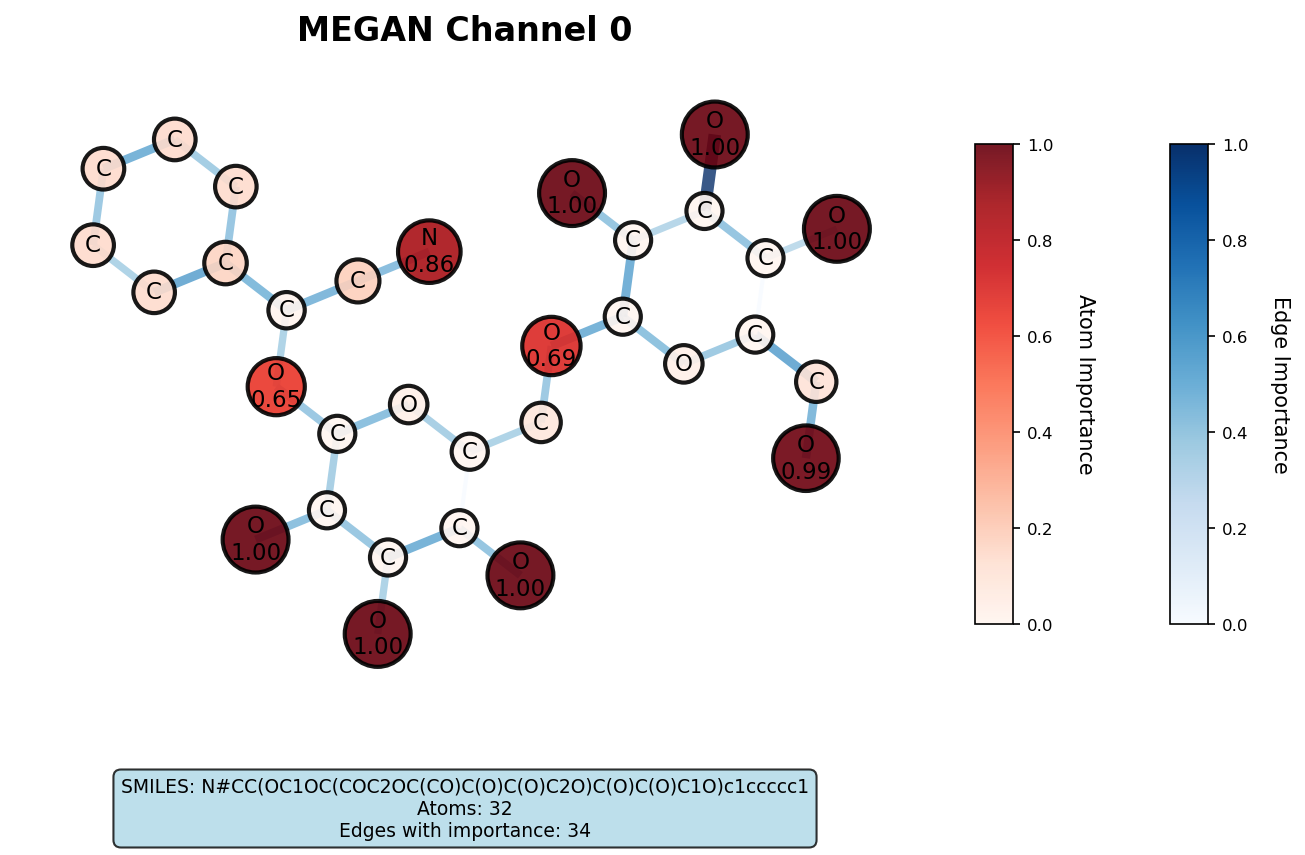

   ✅ MEGAN visualization with edges displayed
   Creating RDKit Crippen visualization...


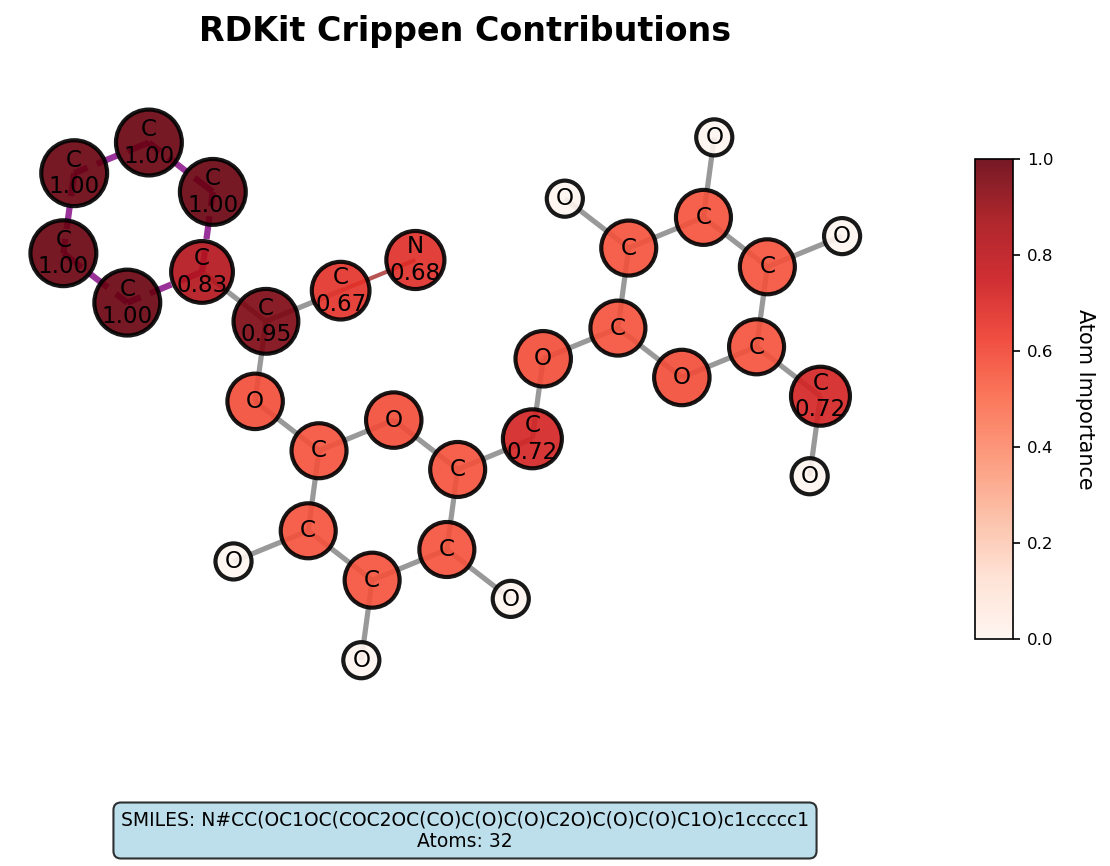

   ✅ RDKit Crippen visualization displayed
   Creating FPA ground truth visualization...
RDKit similarity map failed: GetSimilarityMapFromWeights() missing 1 required positional argument: 'draw2d', using unified visualization


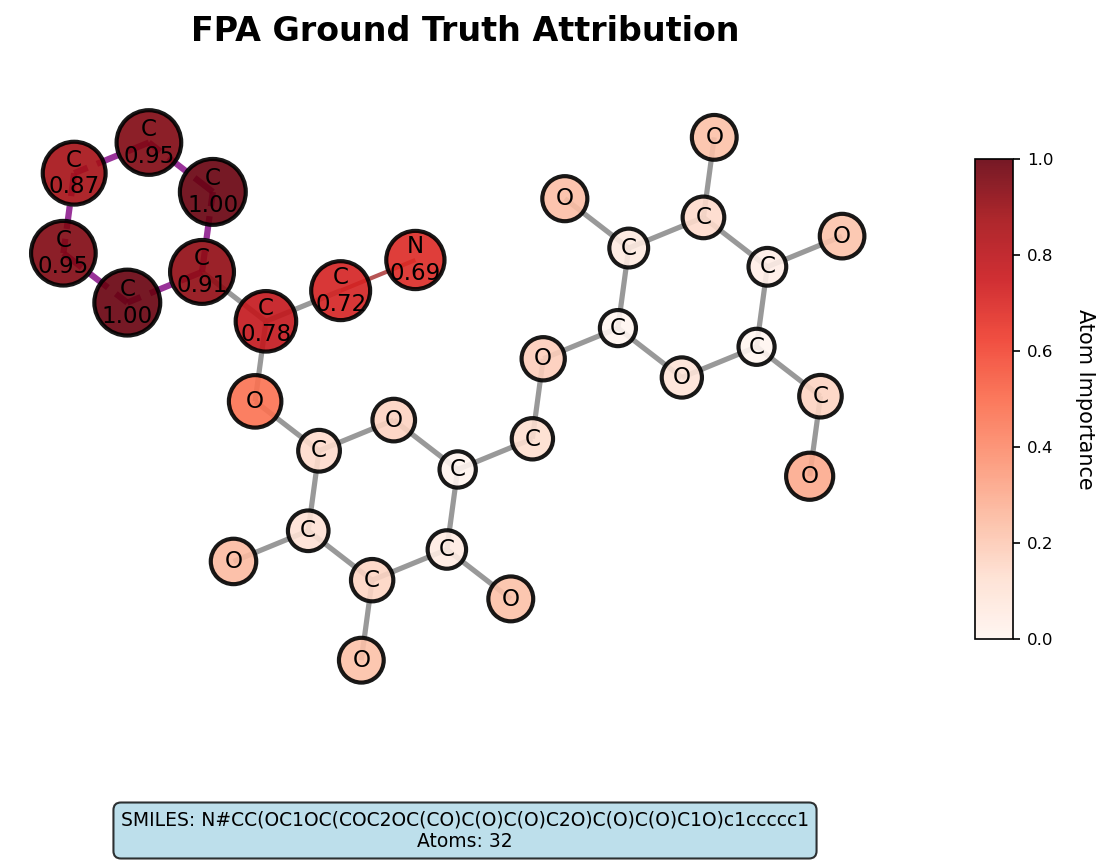

   ✅ FPA visualization displayed
   Creating comparison plot...


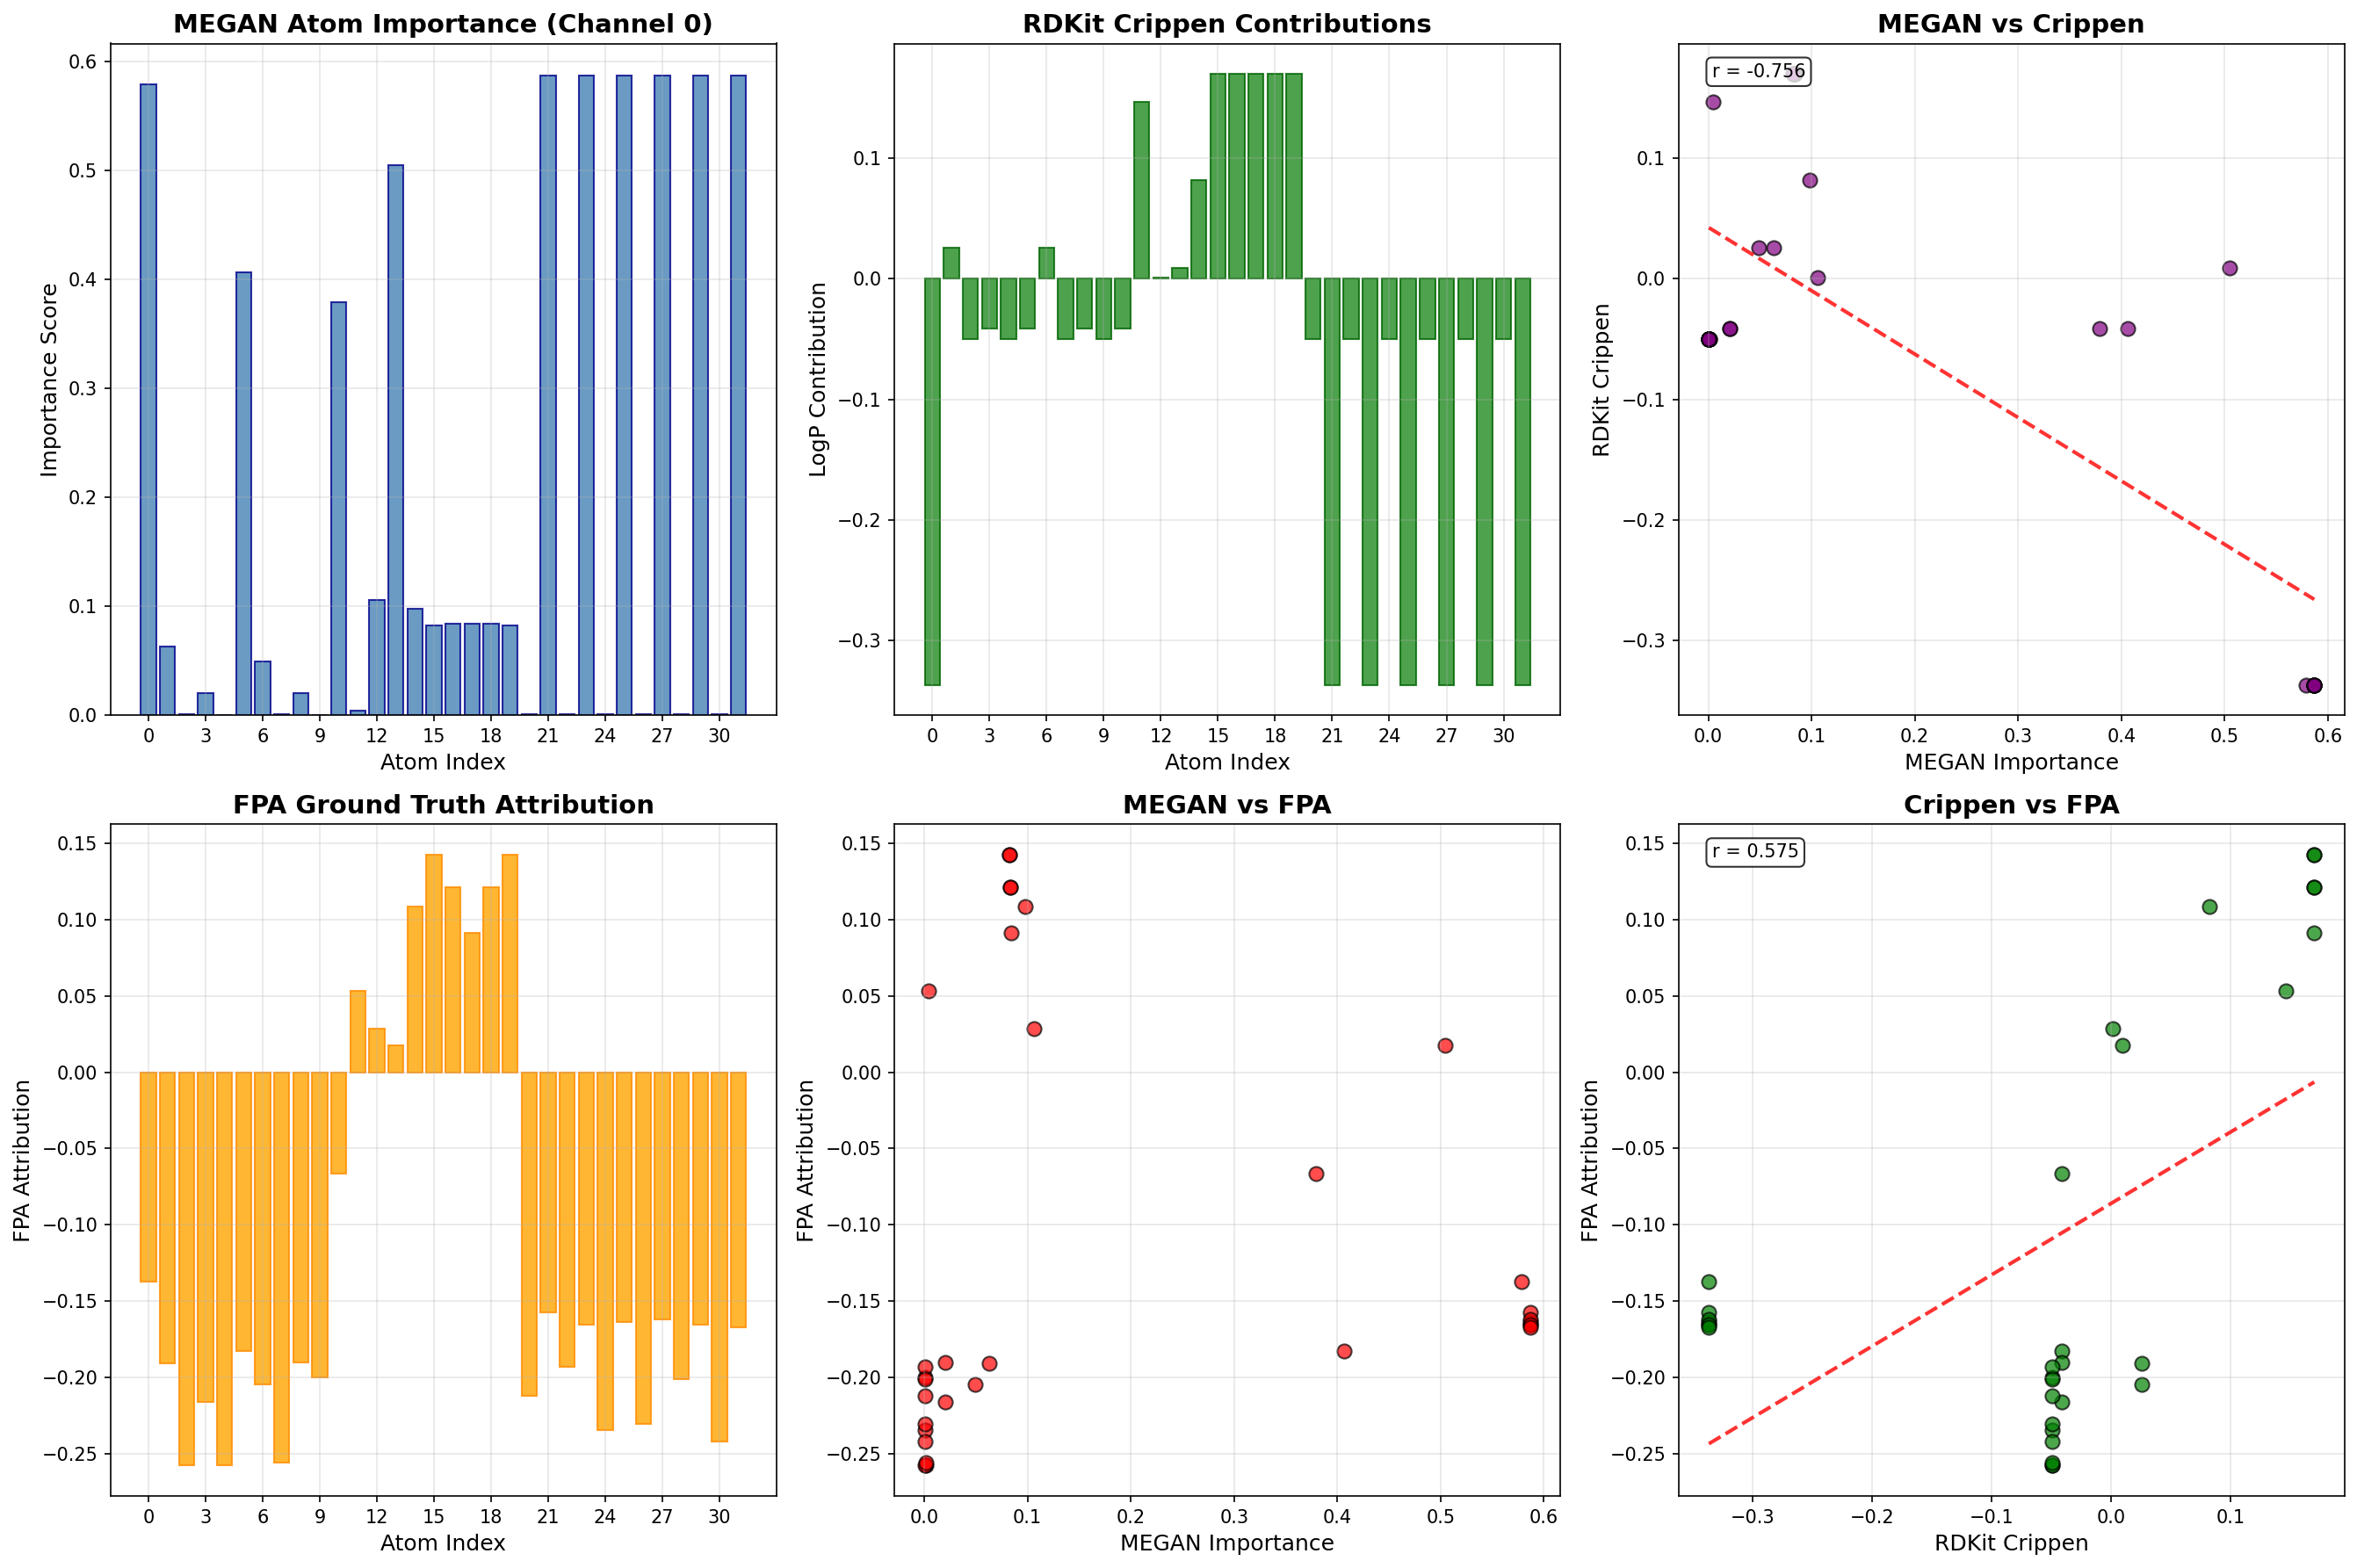

   ✅ Comparison plot displayed

📋 Top Contributing Atoms:
   MEGAN (Channel 0) - Top 5:
     1. Atom 21 (O): 0.5868
     2. Atom 27 (O): 0.5868
     3. Atom 31 (O): 0.5868
     4. Atom 25 (O): 0.5868
     5. Atom 29 (O): 0.5867
   RDKit Crippen - Top 5:
     1. Atom 31 (O): -0.3369
     2. Atom 25 (O): -0.3369
     3. Atom 21 (O): -0.3369
     4. Atom 23 (O): -0.3369
     5. Atom 0 (O): -0.3369
   FPA Ground Truth - Top 5:
     1. Atom 2 (C): -0.2577
     2. Atom 4 (C): -0.2577
     3. Atom 7 (C): -0.2556
     4. Atom 30 (C): -0.2420
     5. Atom 24 (C): -0.2346

--- Channel 1 Comparison ---

🔬 RDKit vs MEGAN Comparison (Channel 1)
📊 Weight Statistics:
   • MEGAN weights: (32,), range: [0.000, 0.658]
   • RDKit Crippen: (32,), range: [-0.337, 0.170]
   • FPA weights: (32,), range: [-0.258, 0.142]
   • Molecule atoms: 32
   • Edge importances shape: (68, 2)
   • MEGAN vs Crippen correlation: 0.497
   • MEGAN vs FPA correlation: 0.323
   • Crippen vs FPA correlation: 0.575

📈 Generating 

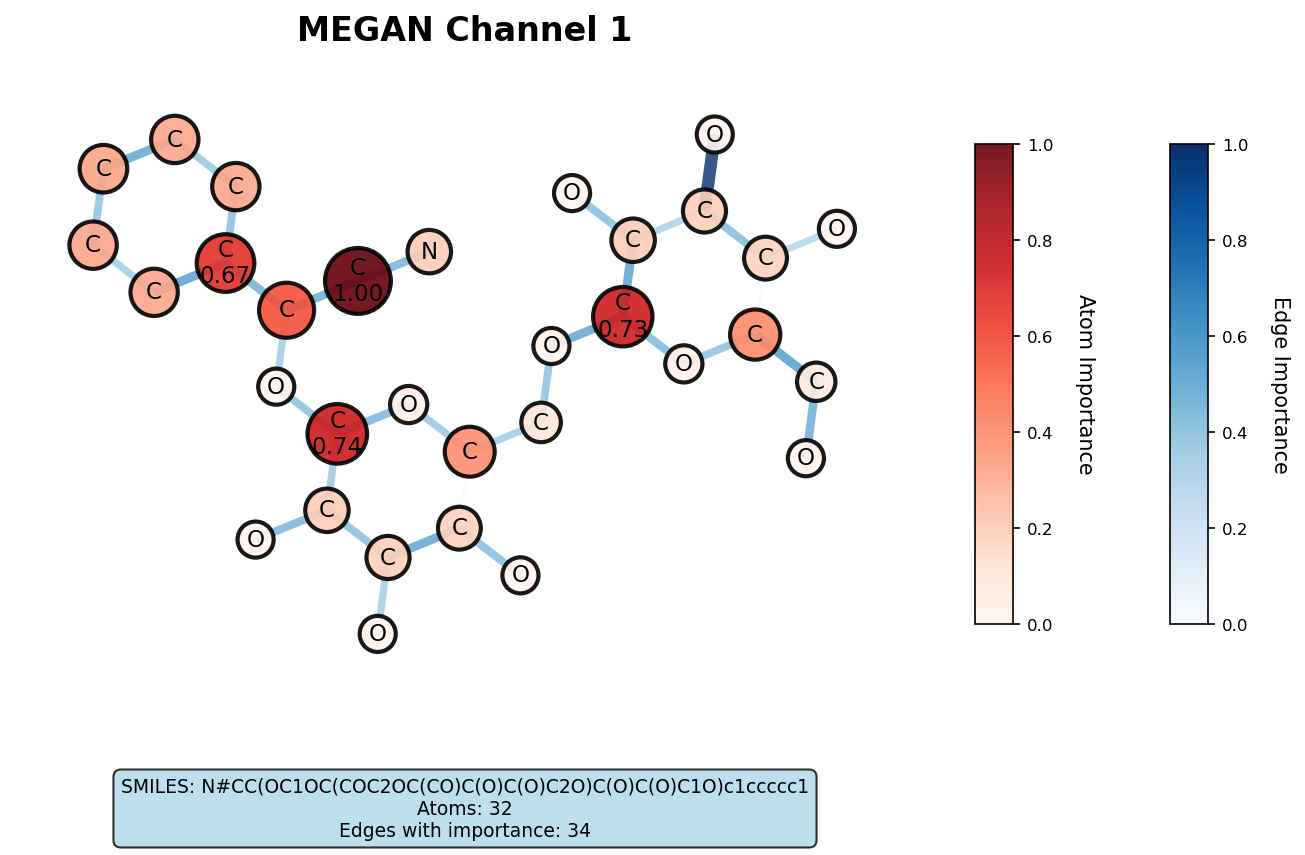

   ✅ MEGAN visualization with edges displayed
   Creating RDKit Crippen visualization...


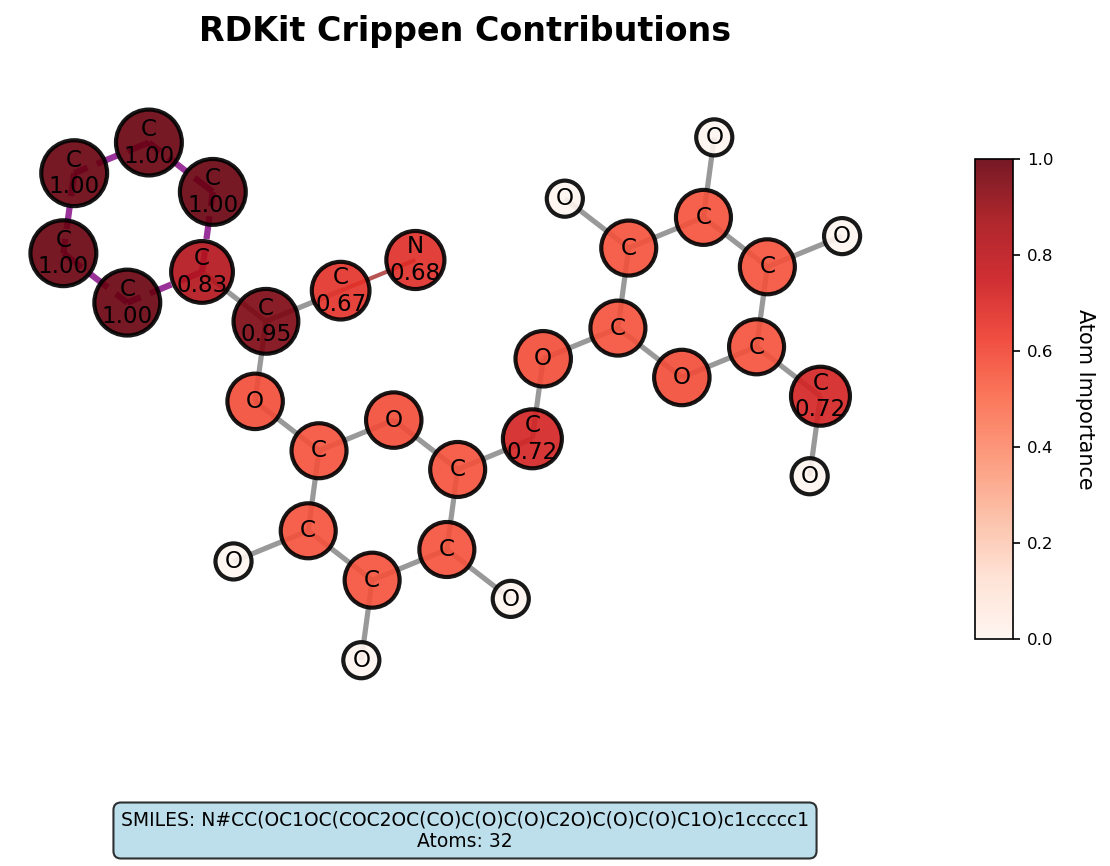

   ✅ RDKit Crippen visualization displayed
   Creating FPA ground truth visualization...
RDKit similarity map failed: GetSimilarityMapFromWeights() missing 1 required positional argument: 'draw2d', using unified visualization


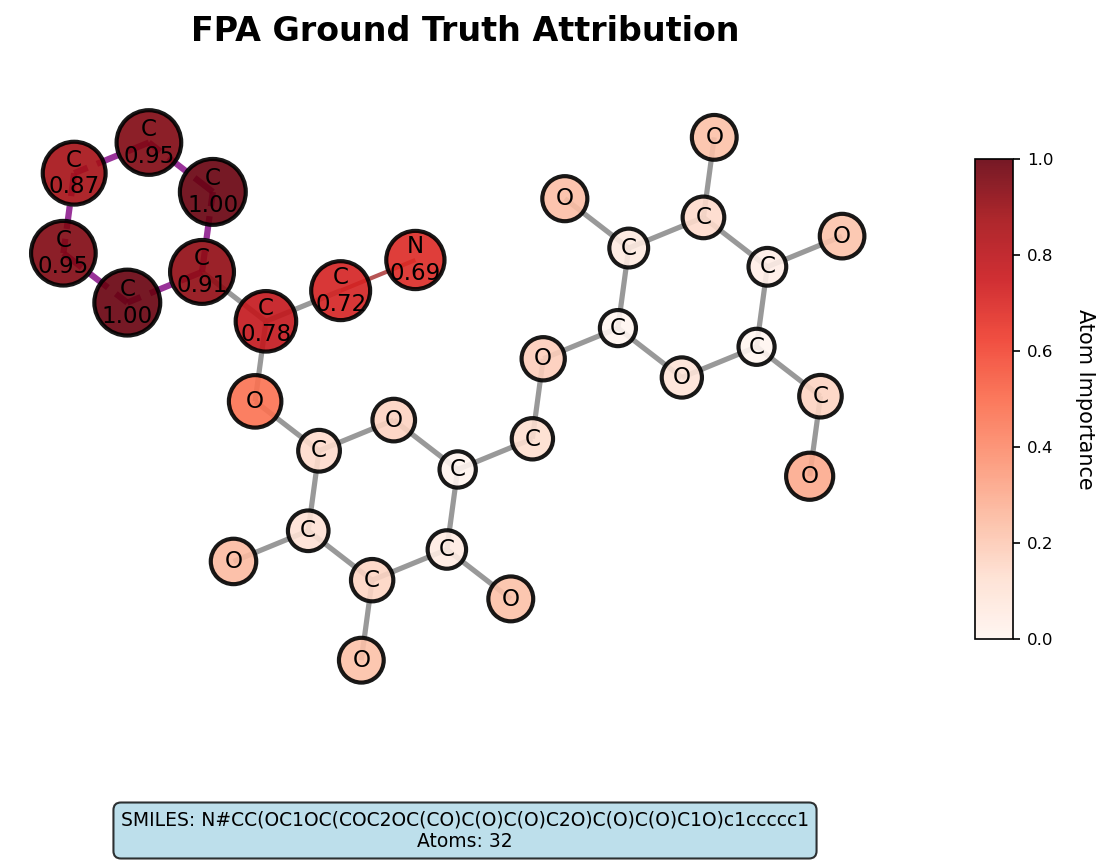

   ✅ FPA visualization displayed
   Creating comparison plot...


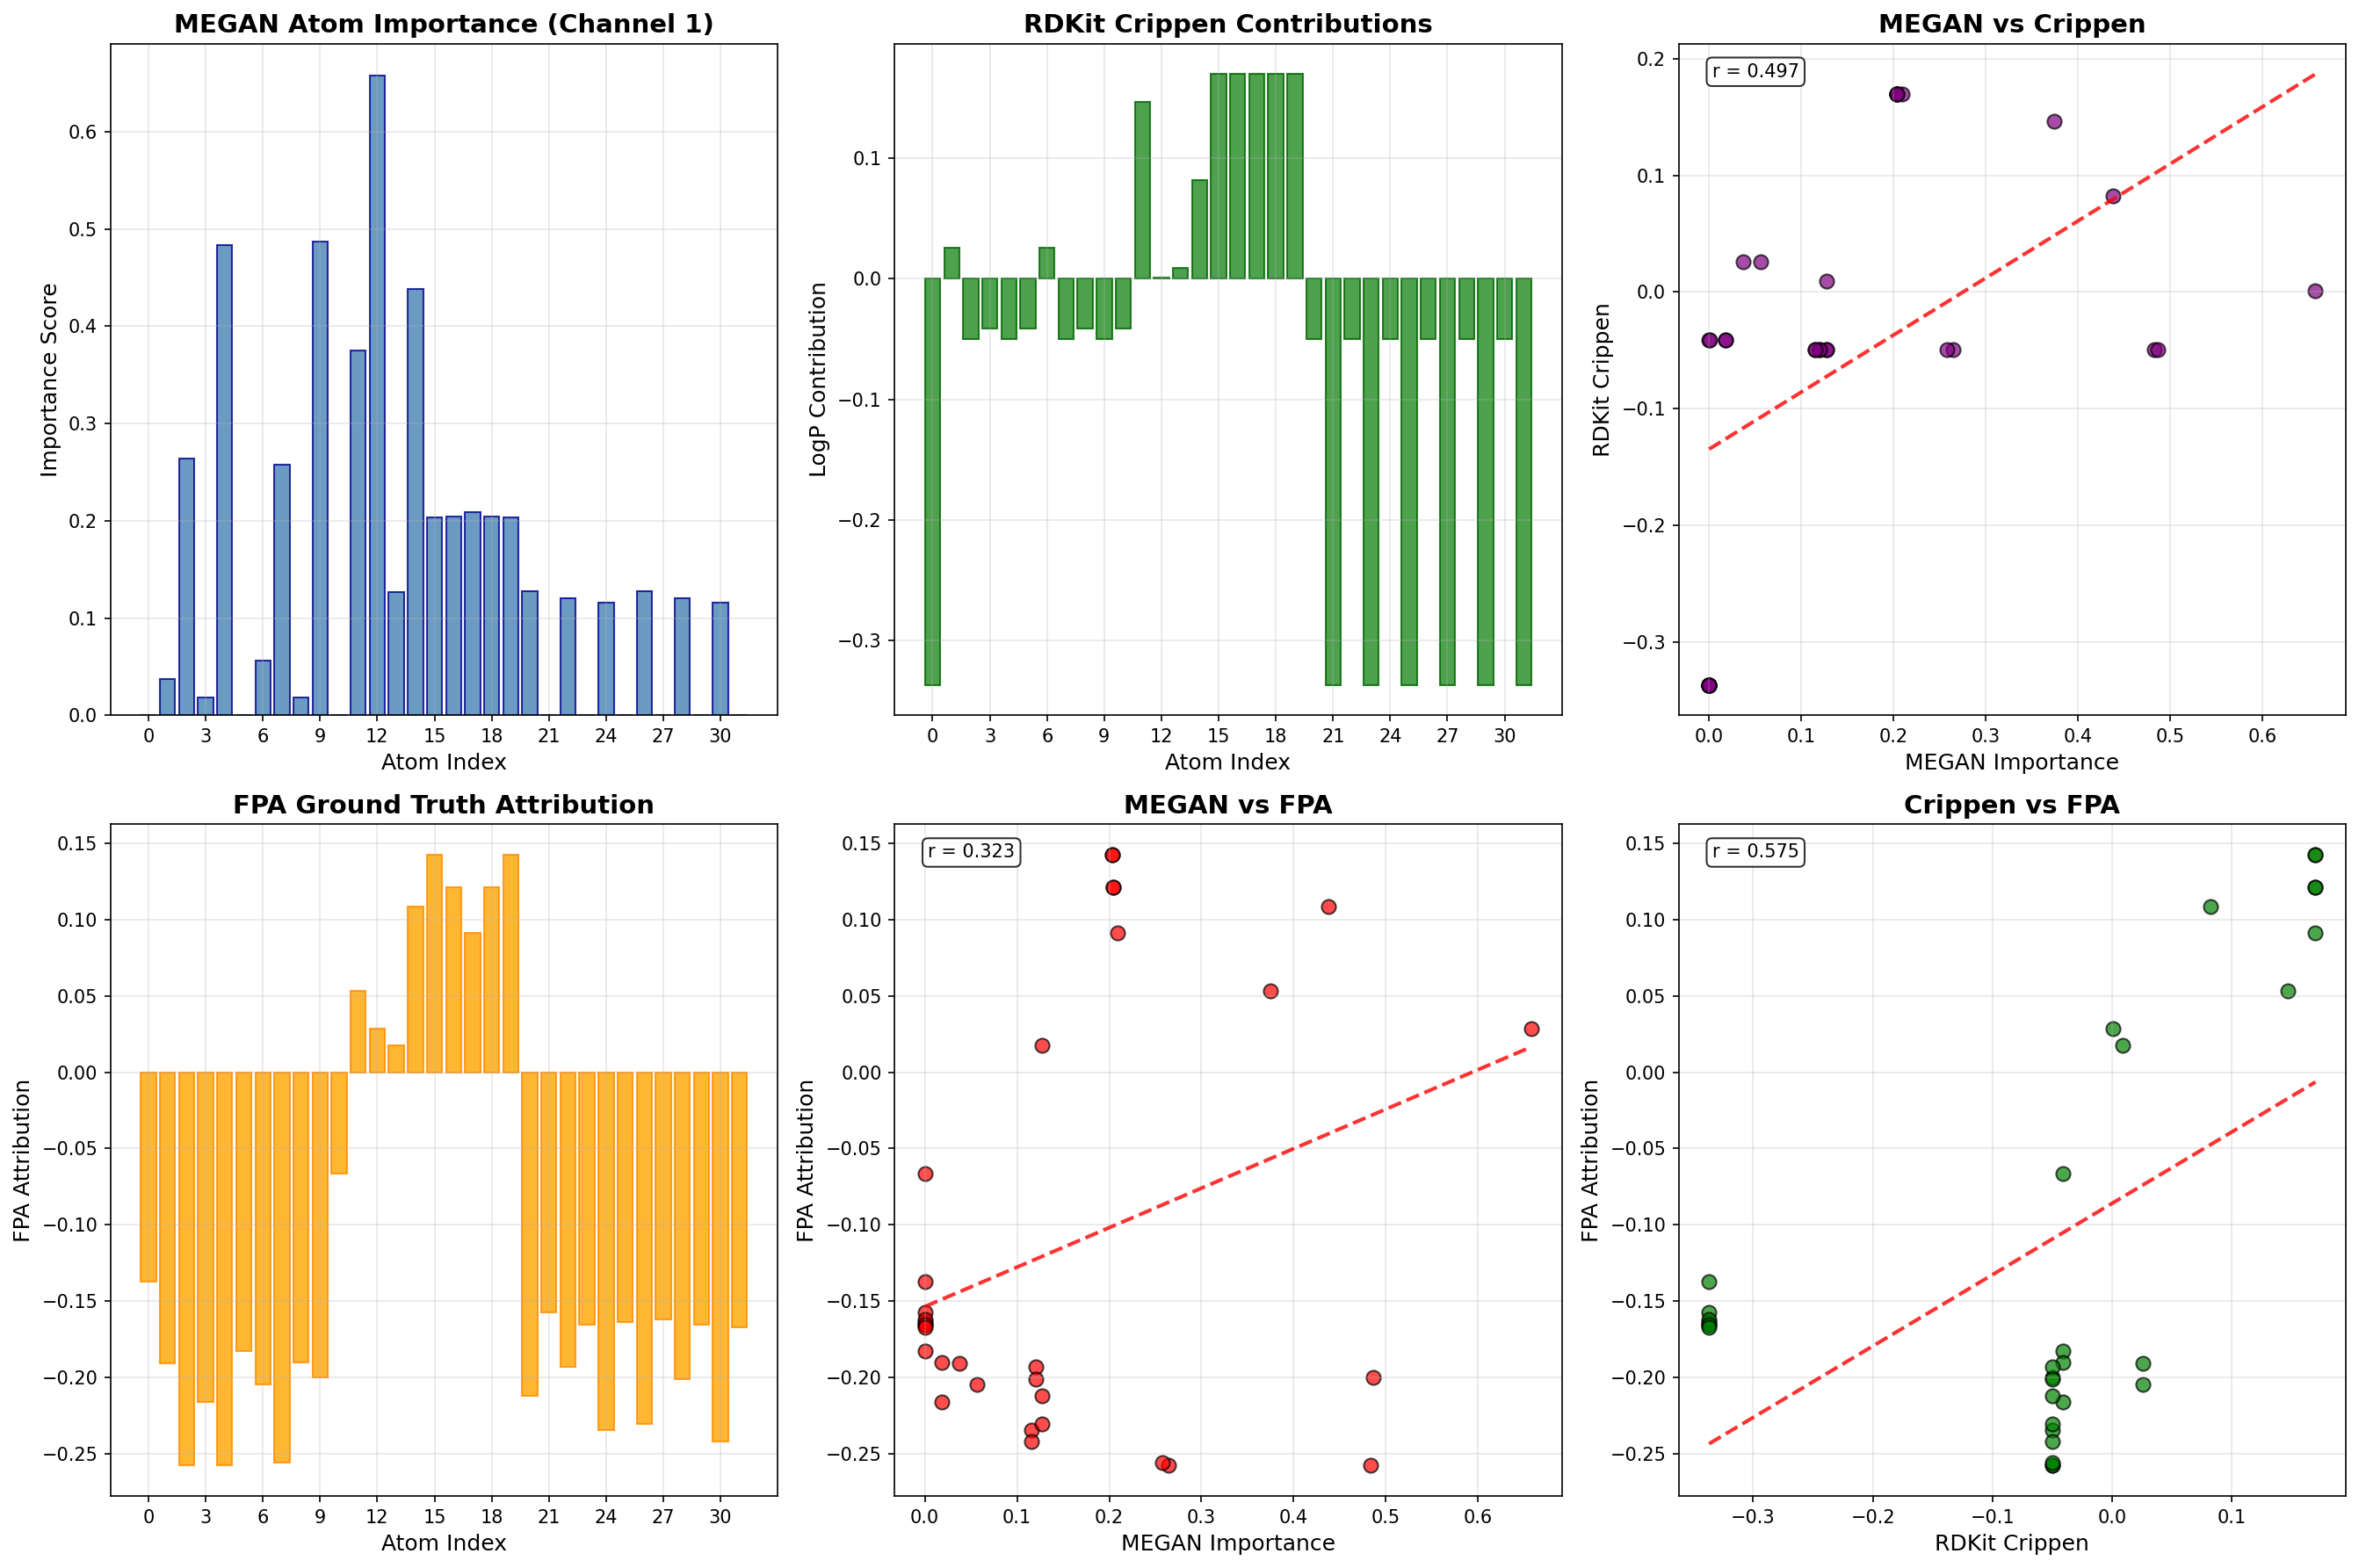

   ✅ Comparison plot displayed

📋 Top Contributing Atoms:
   MEGAN (Channel 1) - Top 5:
     1. Atom 12 (C): 0.6579
     2. Atom 9 (C): 0.4868
     3. Atom 4 (C): 0.4831
     4. Atom 14 (C): 0.4380
     5. Atom 11 (C): 0.3748
   RDKit Crippen - Top 5:
     1. Atom 31 (O): -0.3369
     2. Atom 25 (O): -0.3369
     3. Atom 21 (O): -0.3369
     4. Atom 23 (O): -0.3369
     5. Atom 0 (O): -0.3369
   FPA Ground Truth - Top 5:
     1. Atom 2 (C): -0.2577
     2. Atom 4 (C): -0.2577
     3. Atom 7 (C): -0.2556
     4. Atom 30 (C): -0.2420
     5. Atom 24 (C): -0.2346

🎲 Adding Uncertainty Analysis
🔄 Computing uncertainty analysis with 20 MC samples...
✅ UAA computed: shape (32, 2)
✅ AAU computed: shape (32, 2)

📊 Uncertainty Analysis Visualization
🎯 UAA (Uncertainty in Atomic Attribution):
   Visualizing UAA Channel 0...


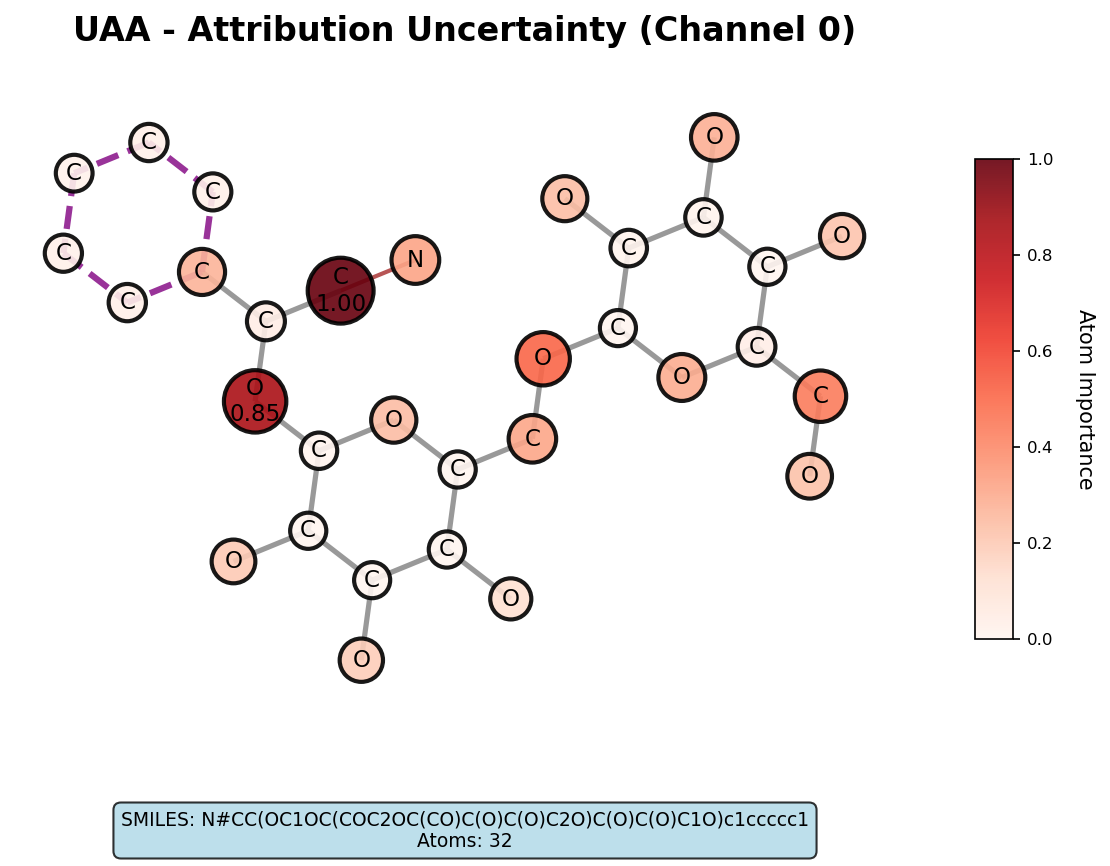

   ✅ UAA Channel 0 visualized
   Visualizing UAA Channel 1...


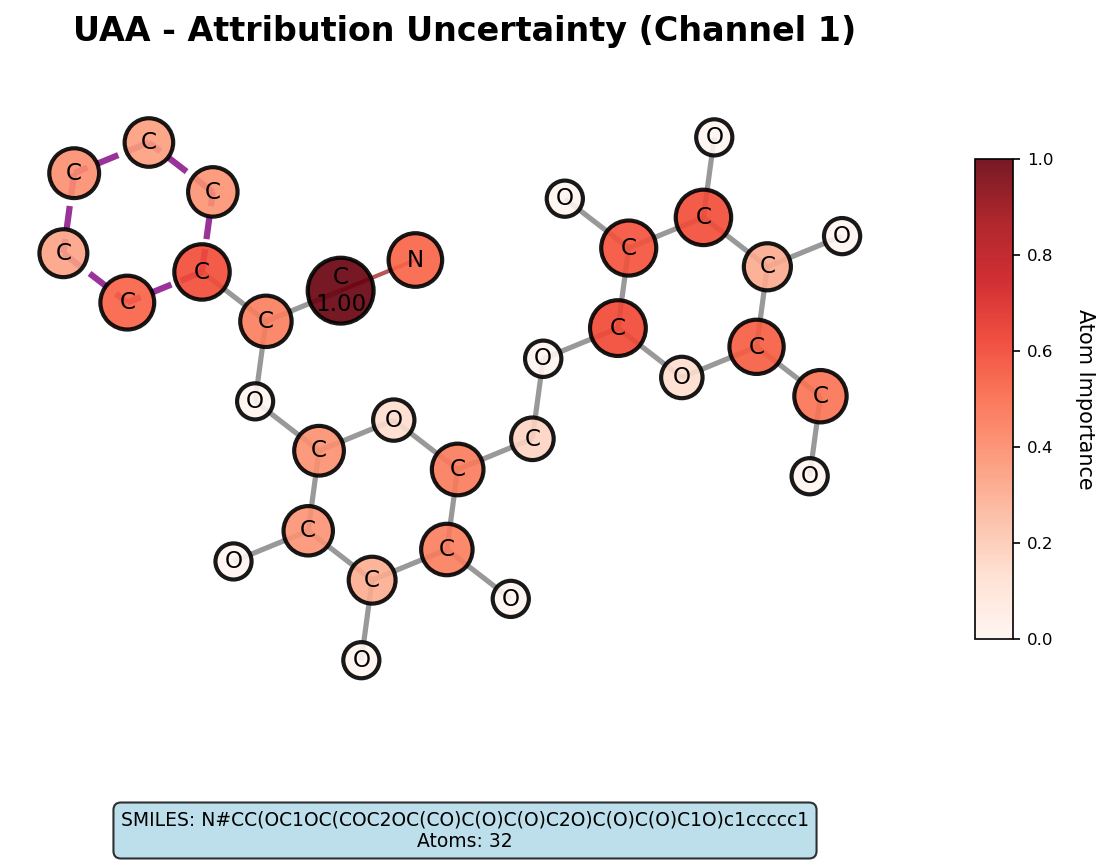

   ✅ UAA Channel 1 visualized
🎯 AAU (Atomic Attribution of Uncertainty):
   Visualizing AAU Channel 0...


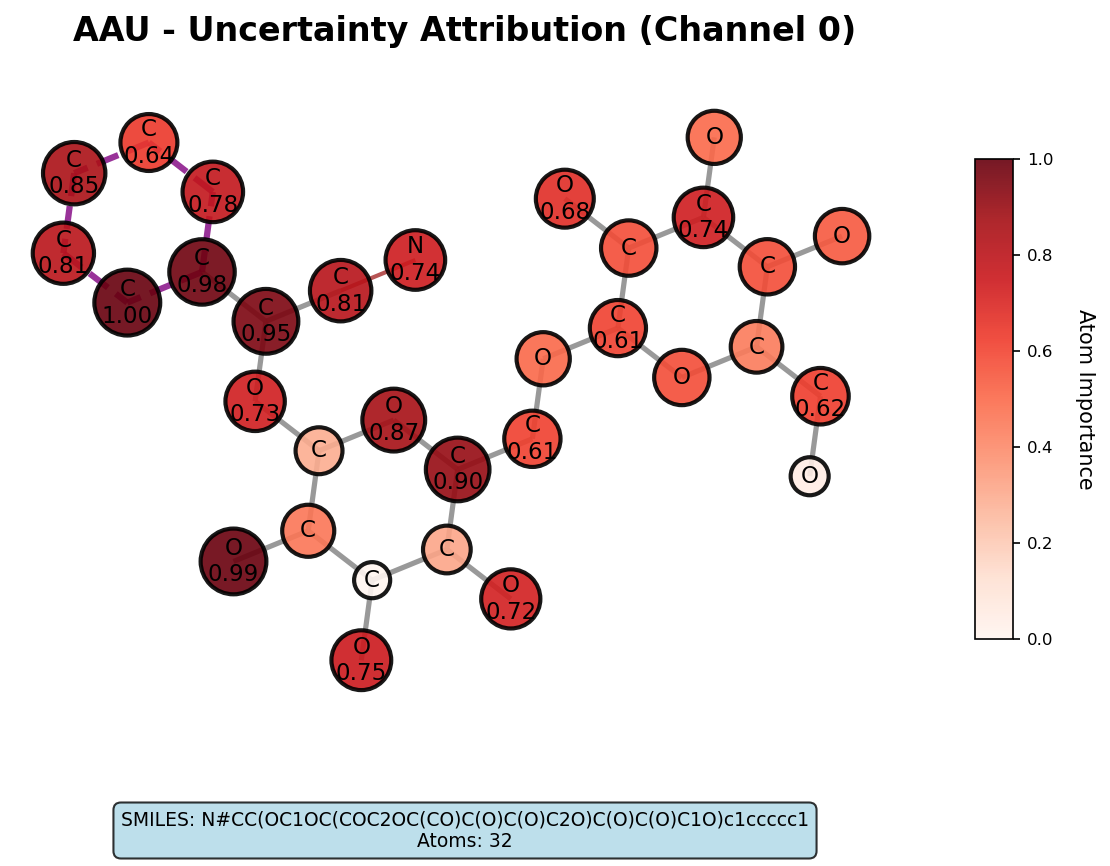

   ✅ AAU Channel 0 visualized
   Visualizing AAU Channel 1...


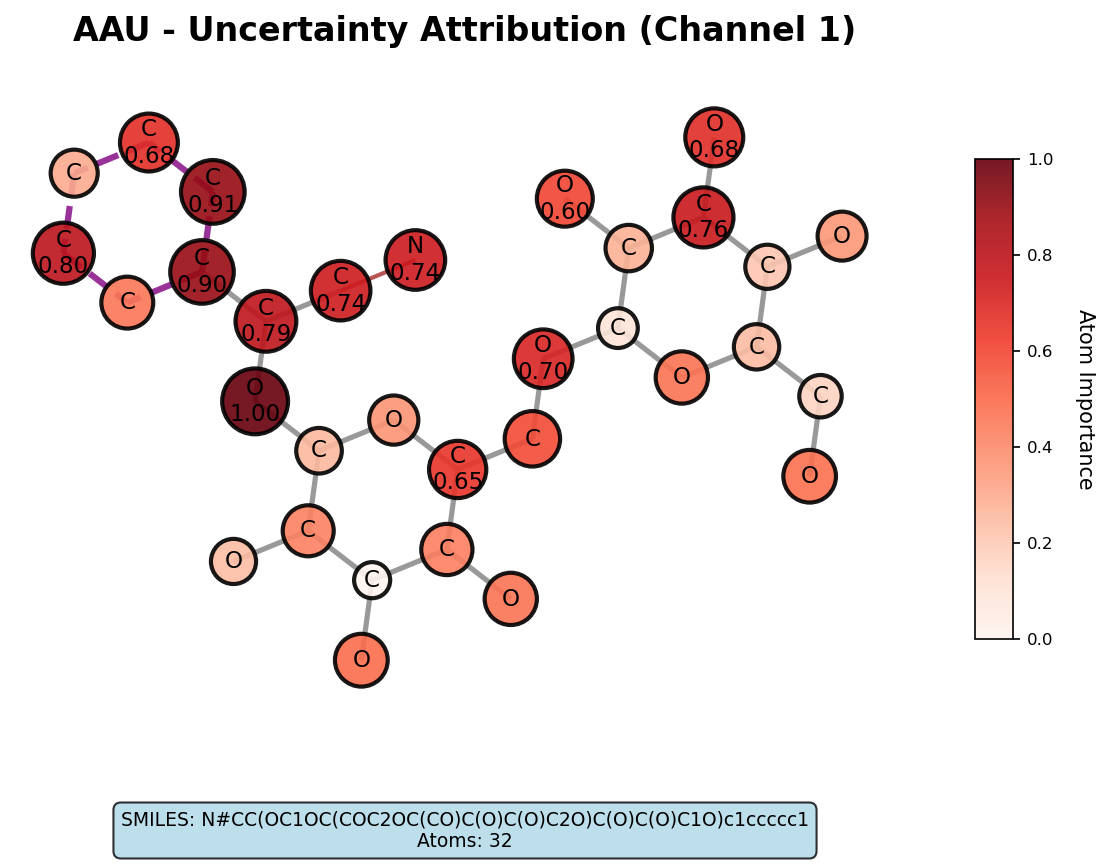

   ✅ AAU Channel 1 visualized

📈 Uncertainty Statistics:
   • Prediction Uncertainty (σ): 0.1748
   • UAA Channel 0 - Mean: 0.0128, Max: 0.0665
   • UAA Channel 1 - Mean: 0.0385, Max: 0.1233
   • AAU Channel 0 - Mean: 0.0154, Max: 0.0595
   • AAU Channel 1 - Mean: 0.0016, Max: 0.0799
✅ Uncertainty analysis completed

✅ Analysis with uncertainty completed
   Results stored in 'results' variable

📊 Analysis Summary:
   • MEGAN Prediction: -0.679 log(mol/L)
   • Molecule: OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)C(O)C3O 
   • RDKit LogP: -3.108
   • FPA Available: True

🔗 Method Correlations:
   Channel 0:
     • MEGAN vs Crippen: -0.756
     • MEGAN vs FPA: -0.012
   Channel 1:
     • MEGAN vs Crippen: 0.497
     • MEGAN vs FPA: 0.323

🎲 Uncertainty Analysis:
   • Prediction Uncertainty: 0.1748
   • MC Samples: 20
   • UAA computed for 2 channels
     Channel 0 UAA mean: 0.0128
     Channel 1 UAA mean: 0.0385
   • AAU computed for 2 channels
     Channel 0 AAU mean: 0.0154
     Chan

In [52]:
# =============================================================================
# SINGLE MOLECULE INFERENCE EXECUTION
# =============================================================================

# Choose molecule to analyze
MOLECULE_IDX = 0  # Change this to analyze different molecules
INCLUDE_UNCERTAINTY = True  # Enable uncertainty analysis
N_UNCERTAINTY_SAMPLES = 20  # Number of MC samples for uncertainty

# Load dataset (if not already loaded)
if 'dataset' not in globals():
    try:
        from torch_geometric.datasets import MoleculeNet
        from torch_geometric.transforms import ToUndirected
        dataset = MoleculeNet(root="data/ESOL", name="ESOL", transform=ToUndirected())
    except Exception as e:
        print(f"❌ Could not load dataset: {e}")
        dataset = None

# Run single molecule analysis with uncertainty
if dataset is not None:
    print(f"\n🚀 Running Analysis with Uncertainty Estimation")
    print("=" * 80)
    
    # Analysis with uncertainty
    results = single_molecule_analysis(
        molecule_idx=MOLECULE_IDX,
        dataset=dataset,
        save_dir="saved_models",
        include_uncertainty=INCLUDE_UNCERTAINTY,
        n_samples=N_UNCERTAINTY_SAMPLES
    )
    
    if results:
        print(f"\n✅ Analysis with uncertainty completed")
        print(f"   Results stored in 'results' variable")
        
        # Summary
        print(f"\n📊 Analysis Summary:")
        print(f"   • MEGAN Prediction: {results['prediction']:.3f} log(mol/L)")
        print(f"   • Molecule: {results['smiles']}")
        
        # RDKit comparison summary
        if 'rdkit_analysis' in results and 'error' not in results['rdkit_analysis']:
            rdkit_data = results['rdkit_analysis']
            print(f"   • RDKit LogP: {rdkit_data['logp_rdkit']:.3f}")
            print(f"   • FPA Available: {rdkit_data.get('has_fpa', False)}")
            
            # Show correlations
            if 'comparisons' in results:
                print(f"\n🔗 Method Correlations:")
                for ch_key, comp_data in results['comparisons'].items():
                    if comp_data and 'correlations' in comp_data:
                        corrs = comp_data['correlations']
                        ch_name = ch_key.replace('_', ' ').title()
                        print(f"   {ch_name}:")
                        if corrs.get('megan_vs_crippen') is not None:
                            print(f"     • MEGAN vs Crippen: {corrs['megan_vs_crippen']:.3f}")
                        if corrs.get('megan_vs_fpa') is not None:
                            print(f"     • MEGAN vs FPA: {corrs['megan_vs_fpa']:.3f}")
        
        # Uncertainty analysis summary
        if 'uncertainty_analysis' in results and 'error' not in results['uncertainty_analysis']:
            uncertainty_data = results['uncertainty_analysis']
            print(f"\n🎲 Uncertainty Analysis:")
            if uncertainty_data['prediction_uncertainty'] is not None:
                print(f"   • Prediction Uncertainty: {uncertainty_data['prediction_uncertainty']:.4f}")
            print(f"   • MC Samples: {uncertainty_data['n_samples']}")
            
            if uncertainty_data['uaa_scores'] is not None:
                K = uncertainty_data['uaa_scores'].shape[1]
                print(f"   • UAA computed for {K} channels")
                for ch in range(K):
                    uaa_mean = uncertainty_data['uaa_scores'][:, ch].mean()
                    print(f"     Channel {ch} UAA mean: {uaa_mean:.4f}")
            
            if uncertainty_data['aau_scores'] is not None:
                print(f"   • AAU computed for {K} channels")
                for ch in range(K):
                    aau_mean = uncertainty_data['aau_scores'][:, ch].mean()
                    print(f"     Channel {ch} AAU mean: {aau_mean:.4f}")
        
        # Store enhanced results
        inference_results = results
        
    else:
        print("❌ Enhanced MEGAN inference failed")
        inference_results = None
else:
    print("❌ Dataset not available")
    inference_results = None

In [53]:
################################################################################
#                     Detailed Interpretation Analysis Cell                   #
################################################################################

def run_comprehensive_interpretation(inference_results, analysis_type="all"):
    """
    Run comprehensive interpretation analysis on inference results.
    
    Args:
        inference_results: Results from analyze_single_molecule()
        analysis_type: "original", "molt5", or "all"
    
    Returns:
        Dictionary with interpretation results
    """
    if inference_results is None:
        print("❌ No inference results available. Run the inference cell first.")
        return None
    
    data = inference_results['data']
    node_imp = inference_results['node_importances']
    edge_imp = inference_results['edge_importances']
    prediction = inference_results['prediction']
    K = inference_results['model_config'].K
    
    print(f"\n{'='*80}")
    print(f"COMPREHENSIVE INTERPRETATION ANALYSIS")
    print(f"{'='*80}")
    print(f"Molecule: {inference_results['smiles']}")
    print(f"Prediction: {prediction:.4f} log(mol/L)")
    print(f"Channels: {K}")
    
    interpretation_results = {}
    
    # Original MEGAN interpretation
    if analysis_type in ["original", "all"]:
        print(f"\n1️⃣ ORIGINAL MEGAN INTERPRETATION:")
        print("-" * 50)
        
        try:
            original_interp = visualize_solubility_conclusion(
                data, node_imp, edge_imp, prediction, 
                channel_idx=0, show_molecular_plot=False
            )
            interpretation_results['original'] = original_interp
        except Exception as e:
            print(f"❌ Original interpretation failed: {e}")
            interpretation_results['original'] = None
    
    # MolT5 interpretation for each channel
    if analysis_type in ["molt5", "all"]:
        for channel in range(K):
            print(f"\n2️⃣ MolT5 INTERPRETATION (Channel {channel}):")
            print("-" * 50)
            
            try:
                molt5_interp = molt5_solubility_analysis(
                    data, node_imp, edge_imp, prediction, 
                    channel_idx=channel, use_mock=True
                )
                
                if not molt5_interp['error']:
                    print(f"\n🤖 MolT5 MOLECULAR ANALYSIS (Channel {channel}):")
                    print("=" * 70)
                    print(molt5_interp['analysis'])
                    print("=" * 70)
                    
                    interpretation_results[f'molt5_ch{channel}'] = molt5_interp
                else:
                    print(f"❌ MolT5 Analysis Failed for Channel {channel}: {molt5_interp['error']}")
                    interpretation_results[f'molt5_ch{channel}'] = None
                    
            except Exception as e:
                print(f"❌ MolT5 interpretation failed for channel {channel}: {e}")
                interpretation_results[f'molt5_ch{channel}'] = None
    
    # Summary
    print(f"\n3️⃣ ANALYSIS SUMMARY:")
    print("-" * 50)
    log_sol = float(prediction)
    mol_per_liter = 10 ** log_sol
    
    # Solubility classification
    if log_sol > -1:
        solubility_class = "Highly Soluble"
    elif log_sol > -2:
        solubility_class = "Moderately Soluble"
    elif log_sol > -3:
        solubility_class = "Poorly Soluble"
    elif log_sol > -4:
        solubility_class = "Very Poorly Soluble"
    else:
        solubility_class = "Practically Insoluble"
    
    print(f"📊 FINAL ASSESSMENT:")
    print(f"   • Molecule: {inference_results['smiles']}")
    print(f"   • Solubility Class: {solubility_class}")
    print(f"   • Predicted log(Solubility): {log_sol:.3f} log(mol/L)")
    print(f"   • Predicted Solubility: {mol_per_liter:.2e} mol/L")
    print(f"   • Analysis completed for {K} explanation channels")
    
    return interpretation_results

In [43]:
# =============================================================================
# RUN INTERPRETATION ANALYSIS
# =============================================================================

# Only run if we have inference results
if 'inference_results' in globals() and inference_results is not None:
    
    # Choose analysis type
    ANALYSIS_TYPE = "all"  # Options: "original", "molt5", "all"
    
    interpretation_results = run_comprehensive_interpretation(
        inference_results, 
        analysis_type=ANALYSIS_TYPE
    )
    
    if interpretation_results:
        print(f"\n✅ Interpretation analysis completed")
        print(f"   Results stored in 'interpretation_results' variable")
    else:
        print(f"❌ Interpretation analysis failed")
        
else:
    print("❌ No inference results available. Run the inference cell first.")
    print("   Make sure to execute the 'Single Molecule Inference Cell' before this cell.")


COMPREHENSIVE INTERPRETATION ANALYSIS
Molecule: OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)C(O)C3O 
Prediction: -0.6789 log(mol/L)
Channels: 2

1️⃣ ORIGINAL MEGAN INTERPRETATION:
--------------------------------------------------

🧪 SOLUBILITY ANALYSIS REPORT

📊 PREDICTION RESULTS:
   • Solubility Class: Highly Soluble
   • Description: Very water-soluble, dissolves readily
   • Predicted log(Solubility): -0.679 log(mol/L)
   • Predicted Solubility: 2.09e-01 mol/L

🔬 KEY MOLECULAR FEATURES:
   • Molecular Weight: 457.4 Da
   • LogP (Lipophilicity): -3.11
   • H-bond Donors: 7
   • H-bond Acceptors: 12
   • Topological Polar Surface Area: 202.3 Ų
   • Rotatable Bonds: 7

💡 SOLUBILITY FACTORS:
   ✅ Low lipophilicity (LogP < 1) favors water solubility
   ⚠️ Many H-bond sites may reduce solubility due to crystal packing
   ⚠️ Large polar surface area may reduce membrane permeability
   ➡️ Moderate flexibility allows conformational adaptation

⭐ MOST IMPORTANT ATOMS (Channel 0):
   • O 